In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dataPath = "datasets/Crime_Data_from_2020_to_Present_20240305.csv"
data = pd.read_csv(dataPath)
data.columns

## We keep only interesting columns for our analysis

In [ ]:
df = data[['DATE OCC', 'TIME OCC', 'AREA', 'Crm Cd','Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Weapon Used Cd']]
# Define new column names   
new_columns = ['date', 'time', 'area', 'crm_cd', 'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'weapon']
# Assign the new column names to the DataFrame
df.columns = new_columns
df.head(2)

## Checking missing values in columns

In [ ]:
def cat_stats(df):
    # df = data.copy()
    ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona',
                                        'num_miss', 'pct_miss'])
    tmp = pd.DataFrame()

    for c in df.columns:
        tmp['column'] = [c]
        if isinstance(df[c].iloc[0], (int, float, complex)):
            values = df[c].fillna(-777).unique()
        else:
            values = df[c].fillna('NaN').unique()
        values.sort()
        tmp['values'] = [values]
        tmp['values_count_incna'] = len(list(df[c].unique()))
        tmp['values_count_nona'] = int(df[c].nunique())
        tmp['num_miss'] = df[c].isnull().sum()
        tmp['pct_miss'] = (df[c].isnull().sum()/ len(df)).round(3)*100
        ds_cat_stats = pd.concat([ds_cat_stats, tmp])

    ds_cat_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

    # And set the index to Column Names
    ds_cat_stats.set_index('column', inplace = True)
    return ds_cat_stats

cat_stats(df)

### Imputing wrong and missing values for Vict Sex and Vict Descent
We have a value 'X' for unknown values in both columns

In [ ]:
descents = ["A", "B", "C", "D", "F", "G", "H", "I", "J", "K", "L", "O","P", "S", "U", "V", "W", "Z"]
df.loc[~df['vict_descent'].isin(descents), 'vict_descent'] = np.nan
df['vict_descent'] = df['vict_descent'].fillna('X')

sex_list = ['F', 'M']
df.loc[~df['vict_sex'].isin(sex_list), 'vict_sex'] = np.nan
df['vict_sex'] = df['vict_sex'].fillna('X')

cat_stats(df)

## Plotting histogram for Victim Age
First we plot the complete data, then we plot only valid Victim Age ( values > 0 )

In [ ]:
# Calculate percentage of ilogical age values ( < 1 )
wrong_values = df.loc[df['vict_age'] < 1, 'vict_age'].count() / df['vict_age'].count() * 100
print("Percentage of ilogical values in vict_age column:")
print('{:2.2f}%'.format(wrong_values))
df_invalid_age = df[df['vict_age'] <= 0].copy()
df_complete = df.copy()
df = df[df['vict_age'] > 0]

# Create a histogram
sns.histplot(data=df_complete, x='vict_age', bins=15, kde=False)
plt.show()

# Create a histogram
sns.histplot(data=df, x='vict_age', bins=15, kde=False)
plt.show()

# Definition of functions for filtering and plotting

In [293]:
cat_cols = ['vict_sex', 'vict_descent','premis_cd', 'crm_cd', 'area', 'weapon']
cols_to_filter = ['premis_cd', 'crm_cd', 'vict_descent', 'vict_sex', 'weapon']

def filterPercent(data, cols, percent):
    for col in cols:
        value_counts = data[col].value_counts()
        # Step 2: Calculate cumulative percentage
        cumulative_perc = value_counts.cumsum() / value_counts.sum() * 100
        # Identify the characters that make up the first 80% of the data
        chars_to_keep = cumulative_perc[cumulative_perc <= percent].index.tolist()
        if cumulative_perc[cumulative_perc > percent].index.size > 0:
            first_char_over_perc = cumulative_perc[cumulative_perc > percent].index[0]
            chars_to_keep.append(first_char_over_perc)
        # Step 3: Filter the DataFrame
        data = data[data[col].isin(chars_to_keep)]
    return data

def doBarplot(data):
    for col in data.columns:
        category_order = data[col].value_counts().index
        sns.countplot(y=col, data=data, order=category_order)
        plt.show()

def doBarplotWithHue(data, normalize=False, filterPercentage = 0):
    data_complete = data.copy()
    for col1 in data.columns:
        # print(col1)
        fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Creates a 2x2 grid of subplots
        axs = axs.flatten()  # Flatten the array to make iteration easier
        cols = [x for x in data.columns if x != col1]
        for ax, col2 in zip(axs, cols):
            if filterPercentage > 0:
                data = data_complete.copy()
                cols_being_filtered = [x for x in cols_to_filter if x in [col1, col2]]
                data = filterPercent(data, cols_being_filtered, filterPercentage)
            data_grouped = (data
                .groupby(col1)[col2]
                .value_counts(normalize=normalize)
                .mul(100)
                .round(2)
                .unstack()
                )
            data_grouped.plot.bar(stacked = True,
                        ax = ax,
                        width = 0.65,
                        edgecolor = "black")
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            ax.set_title(f"Distribution of {col1} by {col2}")
            
            if normalize:
                ax.set_ylabel("Percent")
            else:
                ax.set_ylabel("Counts")
        fig.tight_layout()

def doBoxplotVsAge(data):
    for col in cat_cols:
        sns.boxplot(x=col, y='vict_age', data=data, orient='v')
        plt.show()

def plotFrecuency(data, filterPercentage = 0):
    fig = plt.figure(figsize=(15,10))
    iax = 1
    data_complete = data.copy()
    for col in cat_cols:
        if filterPercentage > 0:
            data = data_complete.copy()
            data = filterPercent(data, [col], filterPercentage)
        if iax <= 3:
            ax1 = fig.add_subplot(2, 3, iax)
            category_order = data[col].value_counts().index
            sns.countplot(y=col, data=data, order=category_order, ax=ax1, orient='h')

            ax2 = fig.add_subplot(2, 3, iax+3)
            sns.boxplot(y=col, x='vict_age', data=data, orient='h', ax=ax2)
        iax += 1
        if iax > 3:
            fig = plt.figure(figsize=(18,10))
            iax = 1

def plotHeatmaps(data, normalize=False, filterPercentage=0):
    data_complete = data.copy()
    for col1 in data.columns:
        fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Creates a 2x2 grid of subplots
        axs = axs.flatten()  # Flatten the array to make iteration easier
        cols = [x for x in data.columns if x != col1]
        for ax, col2 in zip(axs, cols):
            if filterPercentage > 0:
                data = data_complete.copy()
                data = filterPercent(data, [x for x in cols_to_filter if x in [col1, col2]], filterPercentage)
            data_grouped = (data
                .groupby(col1)[col2]
                .value_counts(normalize=normalize)
                .mul(100)
                .round(2)
                .unstack().T
                )
            
            if normalize:
                sns.heatmap(data_grouped, ax=ax, vmin=0, vmax=100)
                color_bar = ax.collections[0].colorbar
                color_bar.set_label('Percent')
            else:
                sns.heatmap(data_grouped, ax=ax)
                color_bar = ax.collections[0].colorbar
                color_bar.set_label('Counts')

# Barplots and Boxplots
- Barplot was created for each categorical column
- Boxplot was created for each categorical column vs 'Victim Age' numerical column

### Frecuency plots BEFORE filtering categorical values with too little frecuency

In [ ]:
plotFrecuency(df_complete[cat_cols + ['vict_age']])

### Frecuency plots AFTER filtering categorical values with too little frecuency

In [ ]:
plotFrecuency(df_complete[cat_cols + ['vict_age']], filterPercentage=85)

### Frecuency plots AFTER filtering rows with Vict Age < 1  (Invalid / Unknown Vict Age)

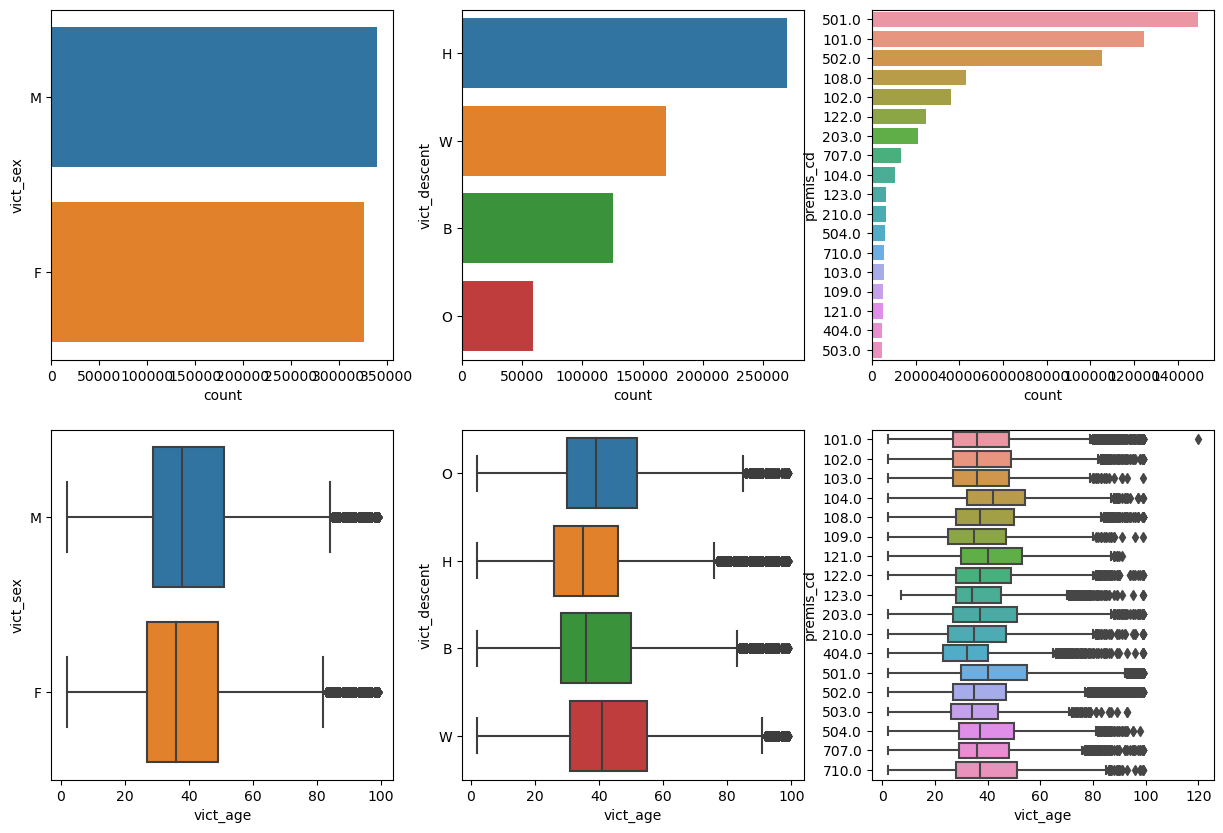

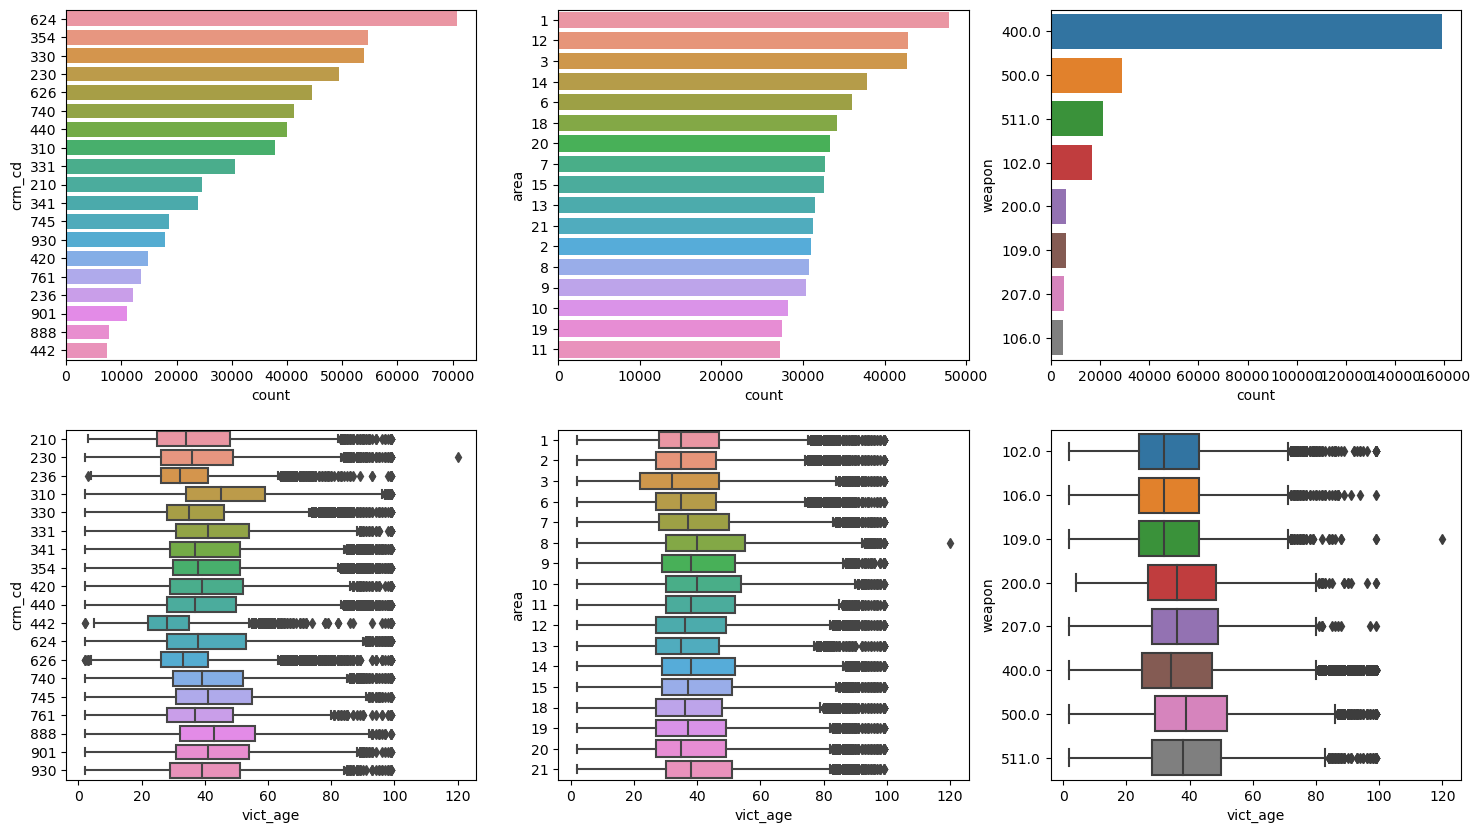

<Figure size 1800x1000 with 0 Axes>

In [294]:
# df = filterPercent(df, [ 'premis_cd', 'crm_cd'], 90)
plotFrecuency(df[cat_cols + ['vict_age']], filterPercentage=85)

### Frecuency plots of data with invalid or unknown Vict Age

C:\Users\gemj9\AppData\Local\Temp\ipykernel_16300\2205305301.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ds_cat_stats = pd.concat([ds_cat_stats, tmp])


values  \
column                                                            
vict_sex                                              [F, M, X]   
vict_age                                    [-4, -3, -2, -1, 0]   
vict_descent      [A, B, C, F, H, I, J, K, O, P, S, U, V, W, X]   
area          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
weapon        [-777.0, 101.0, 102.0, 103.0, 104.0, 105.0, 10...   
crm_cd        [110, 121, 122, 210, 220, 230, 231, 235, 236, ...   
premis_cd     [-777.0, 101.0, 102.0, 103.0, 104.0, 105.0, 10...   
time          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
date          [01/01/2020 12:00:00 AM, 01/01/2021 12:00:00 A...   

             values_count_incna values_count_nona num_miss  pct_miss  
column                                                                
vict_sex                      3                 3        0       0.0  
vict_age                      5                 5        0       0.0  
vict_descent                 15                15        0       0.0  
area                         21                21        0       0.0  
weapon                       73                72   201532      88.9  
crm_cd                      134               134        0       0.0  
premis_cd                   291               290        9       0.0  
time                       1439              1439        0       0.0  
date                       1511              1511        0       0.0

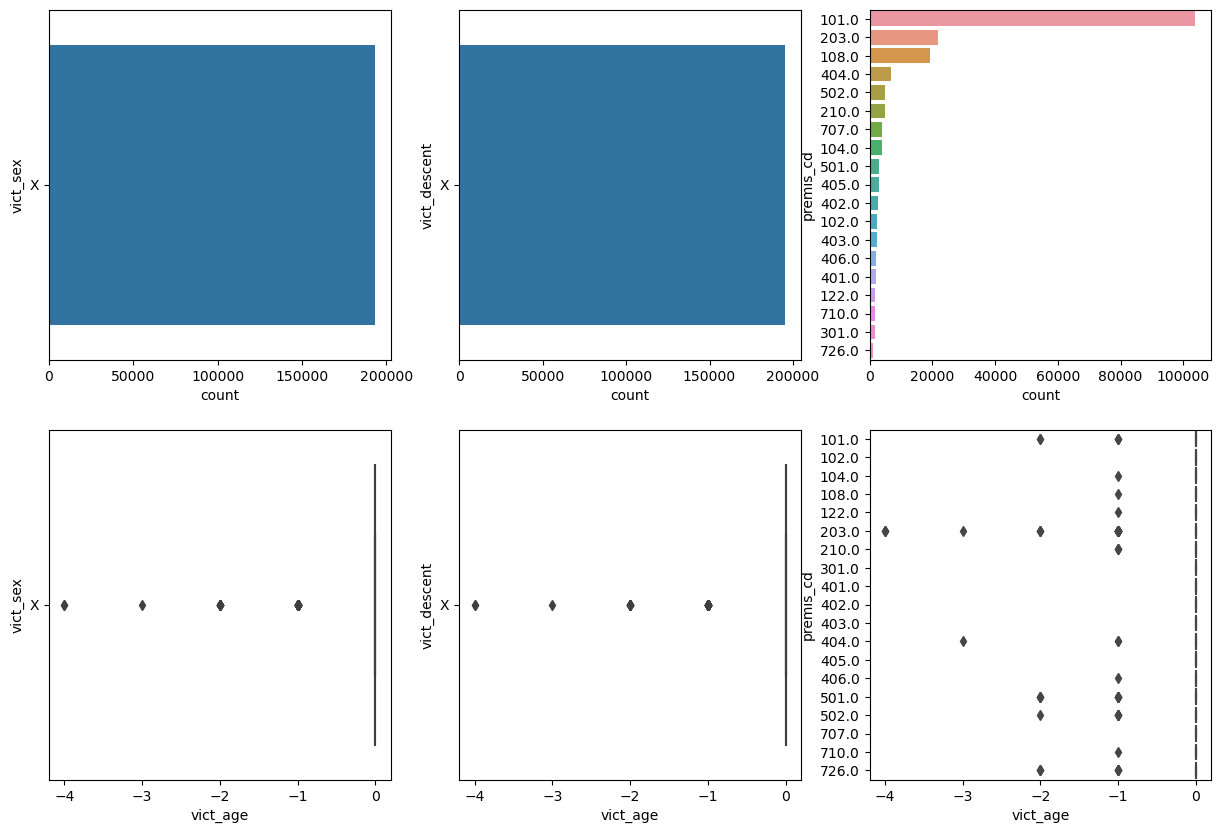

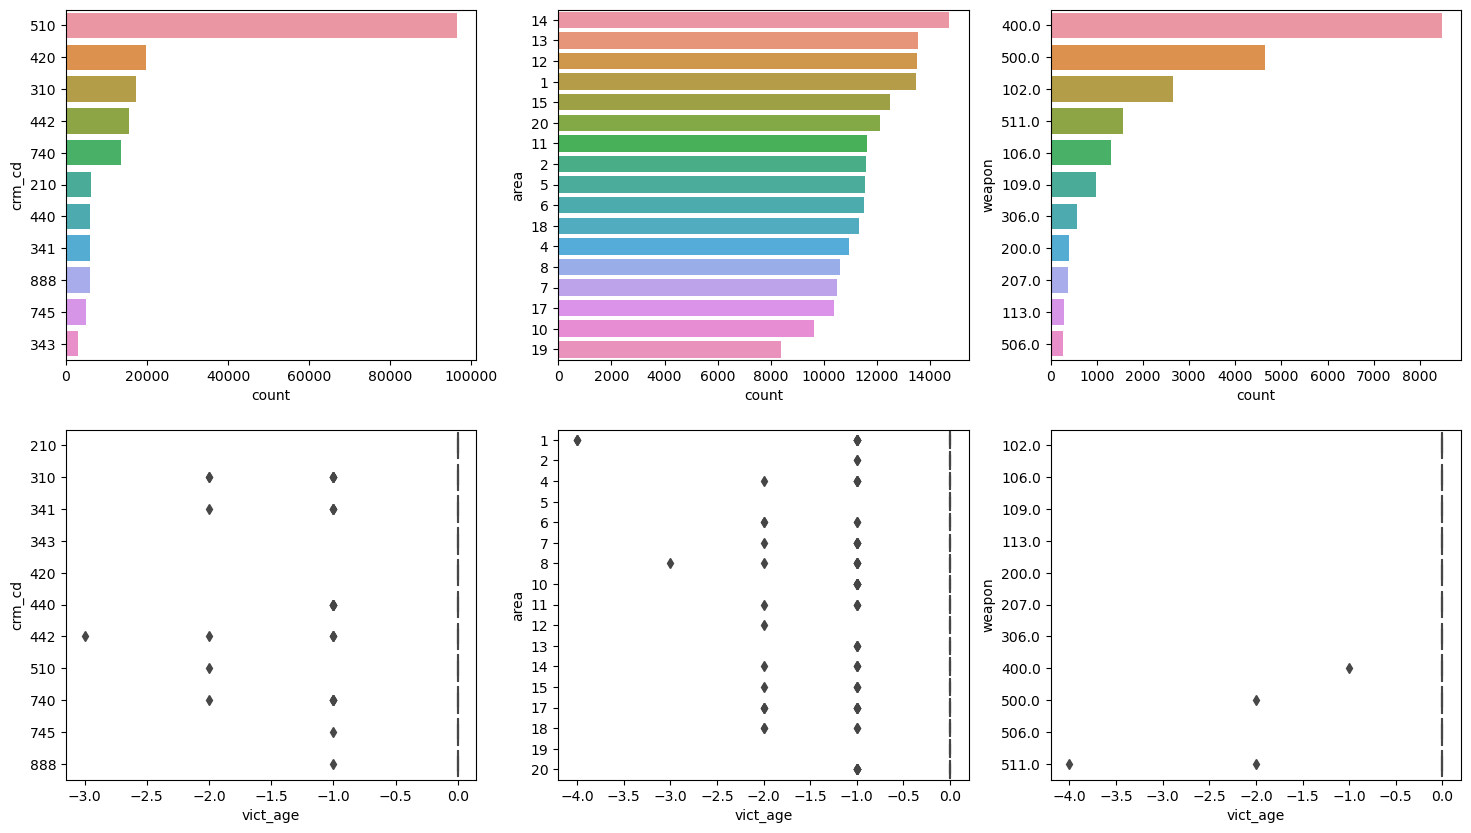

<Figure size 1800x1000 with 0 Axes>

In [295]:
plotFrecuency(df_invalid_age[cat_cols + ['vict_age']], filterPercentage=85)
cat_stats(df_invalid_age)

### Stacked barplots for each categorical feature vs other categorical features
The y-axis is the number of ocurrencies for each combination.

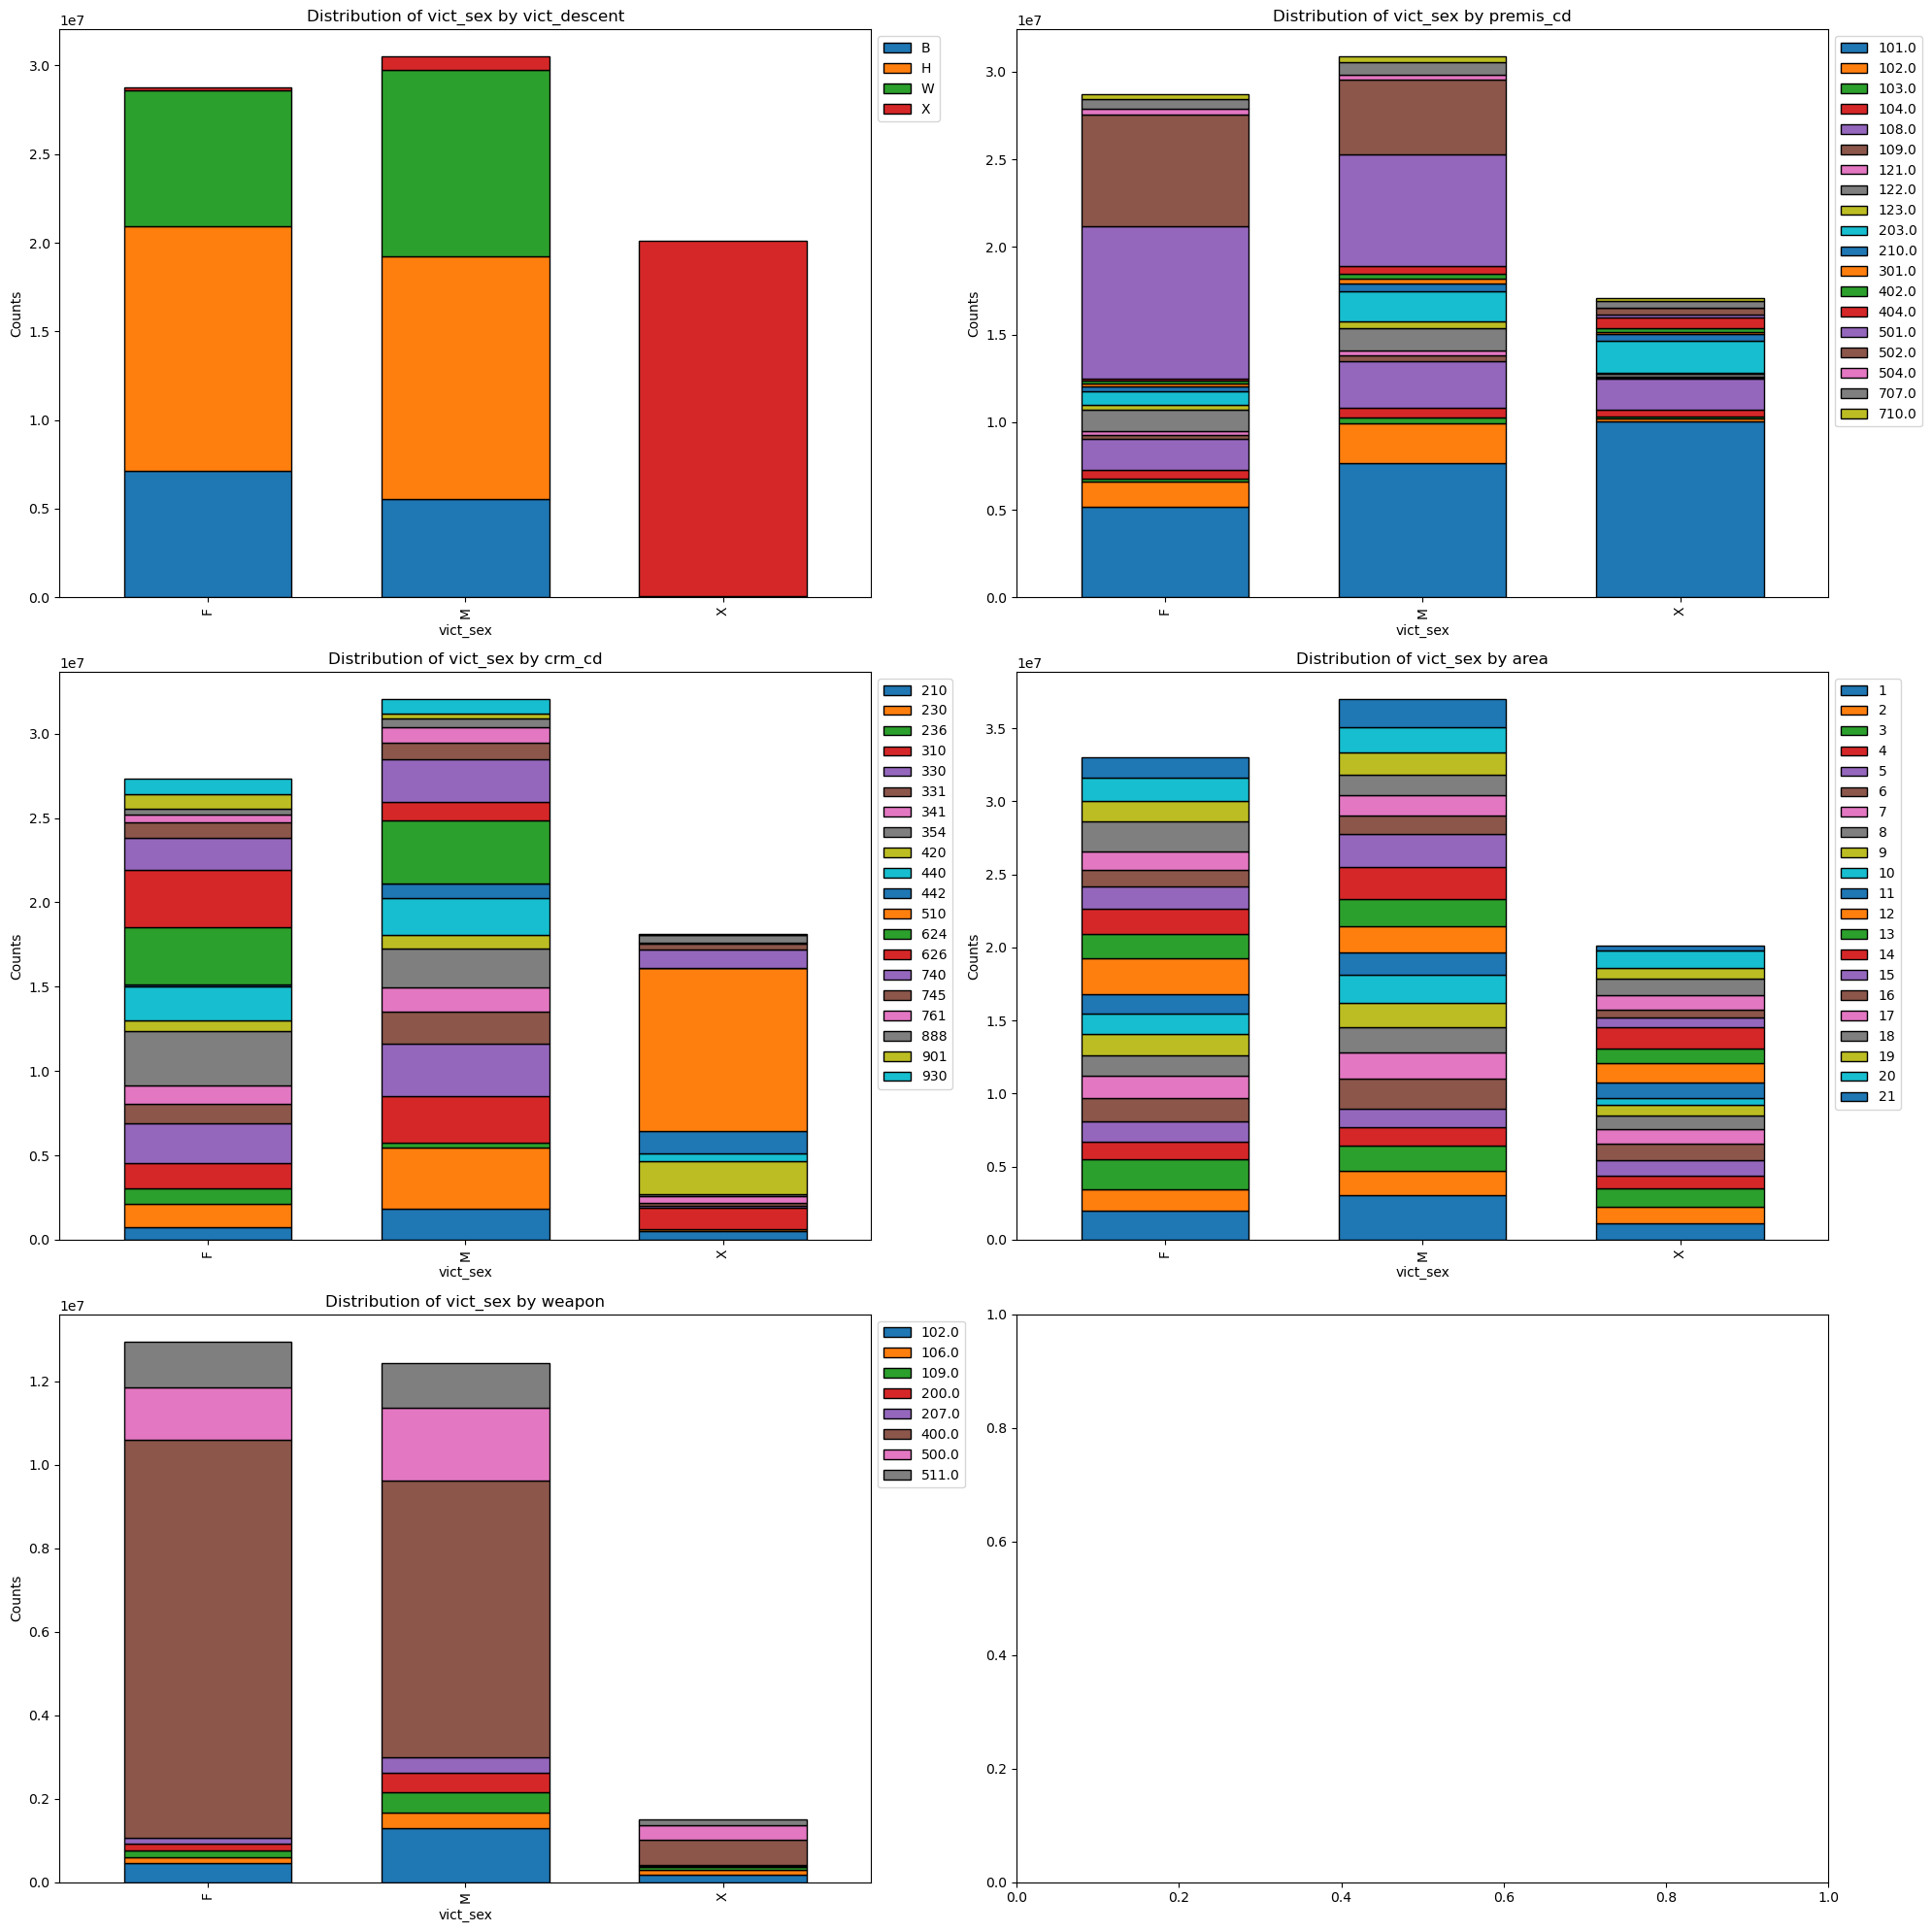

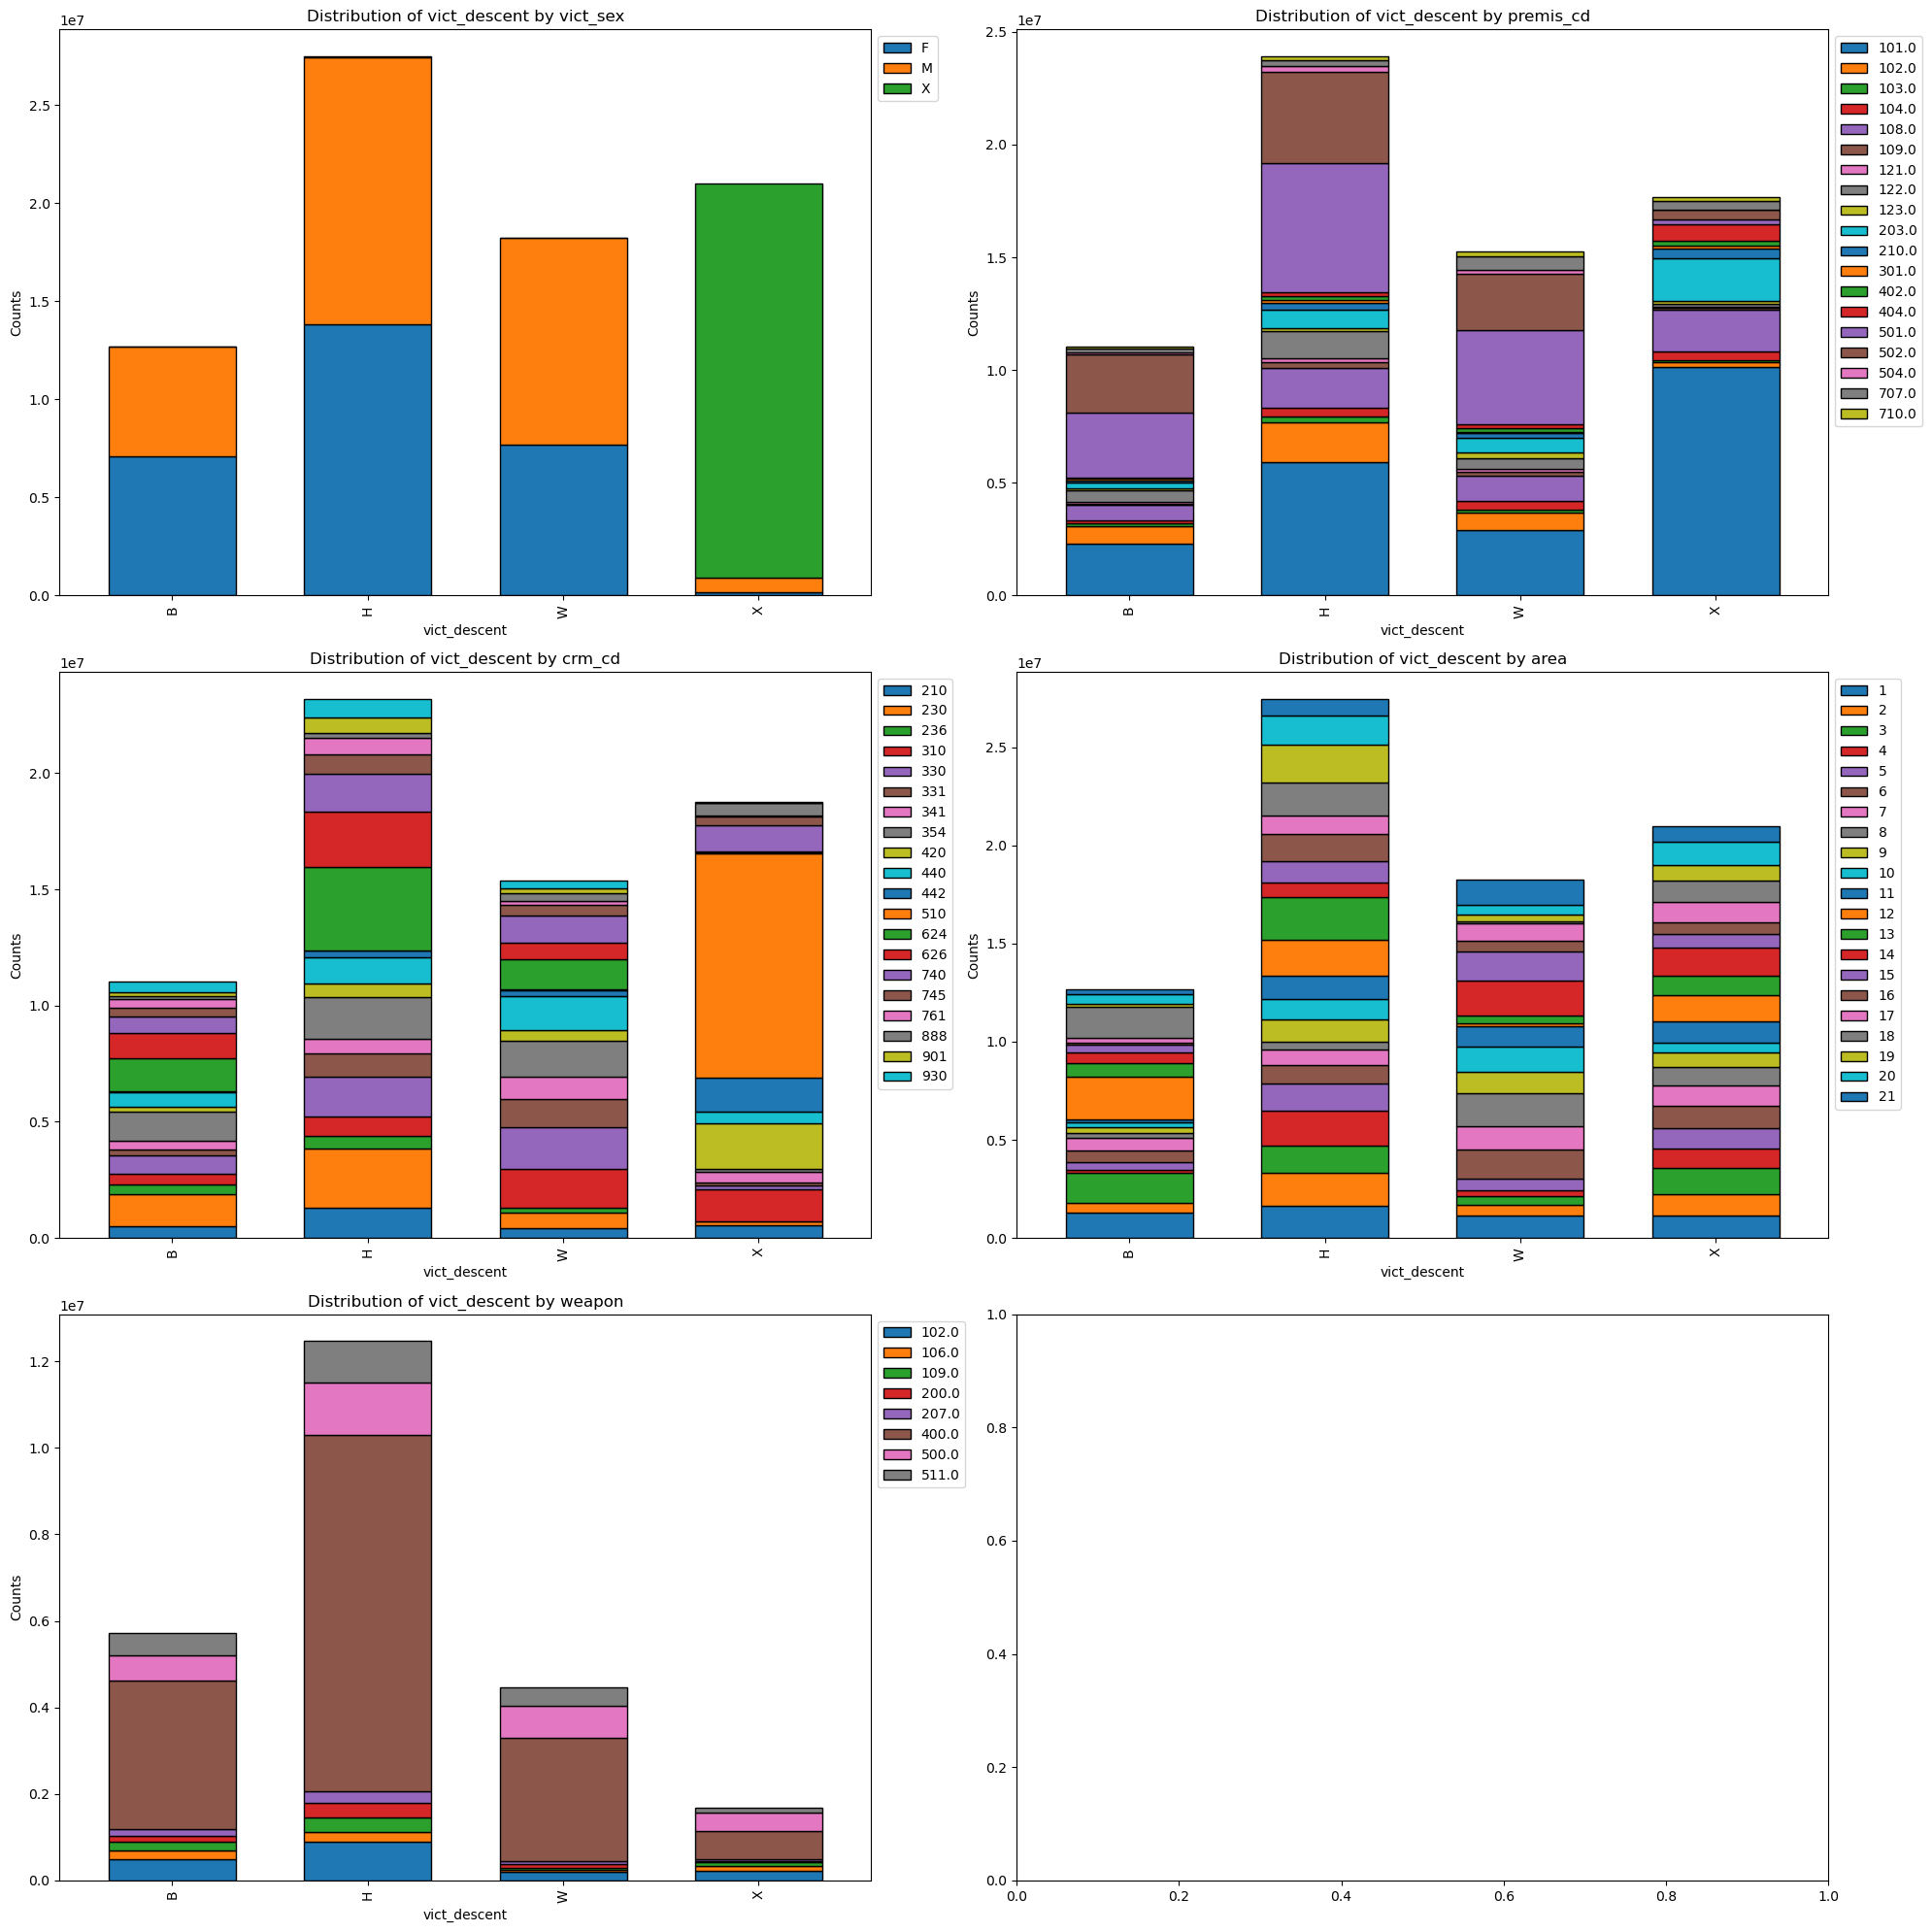

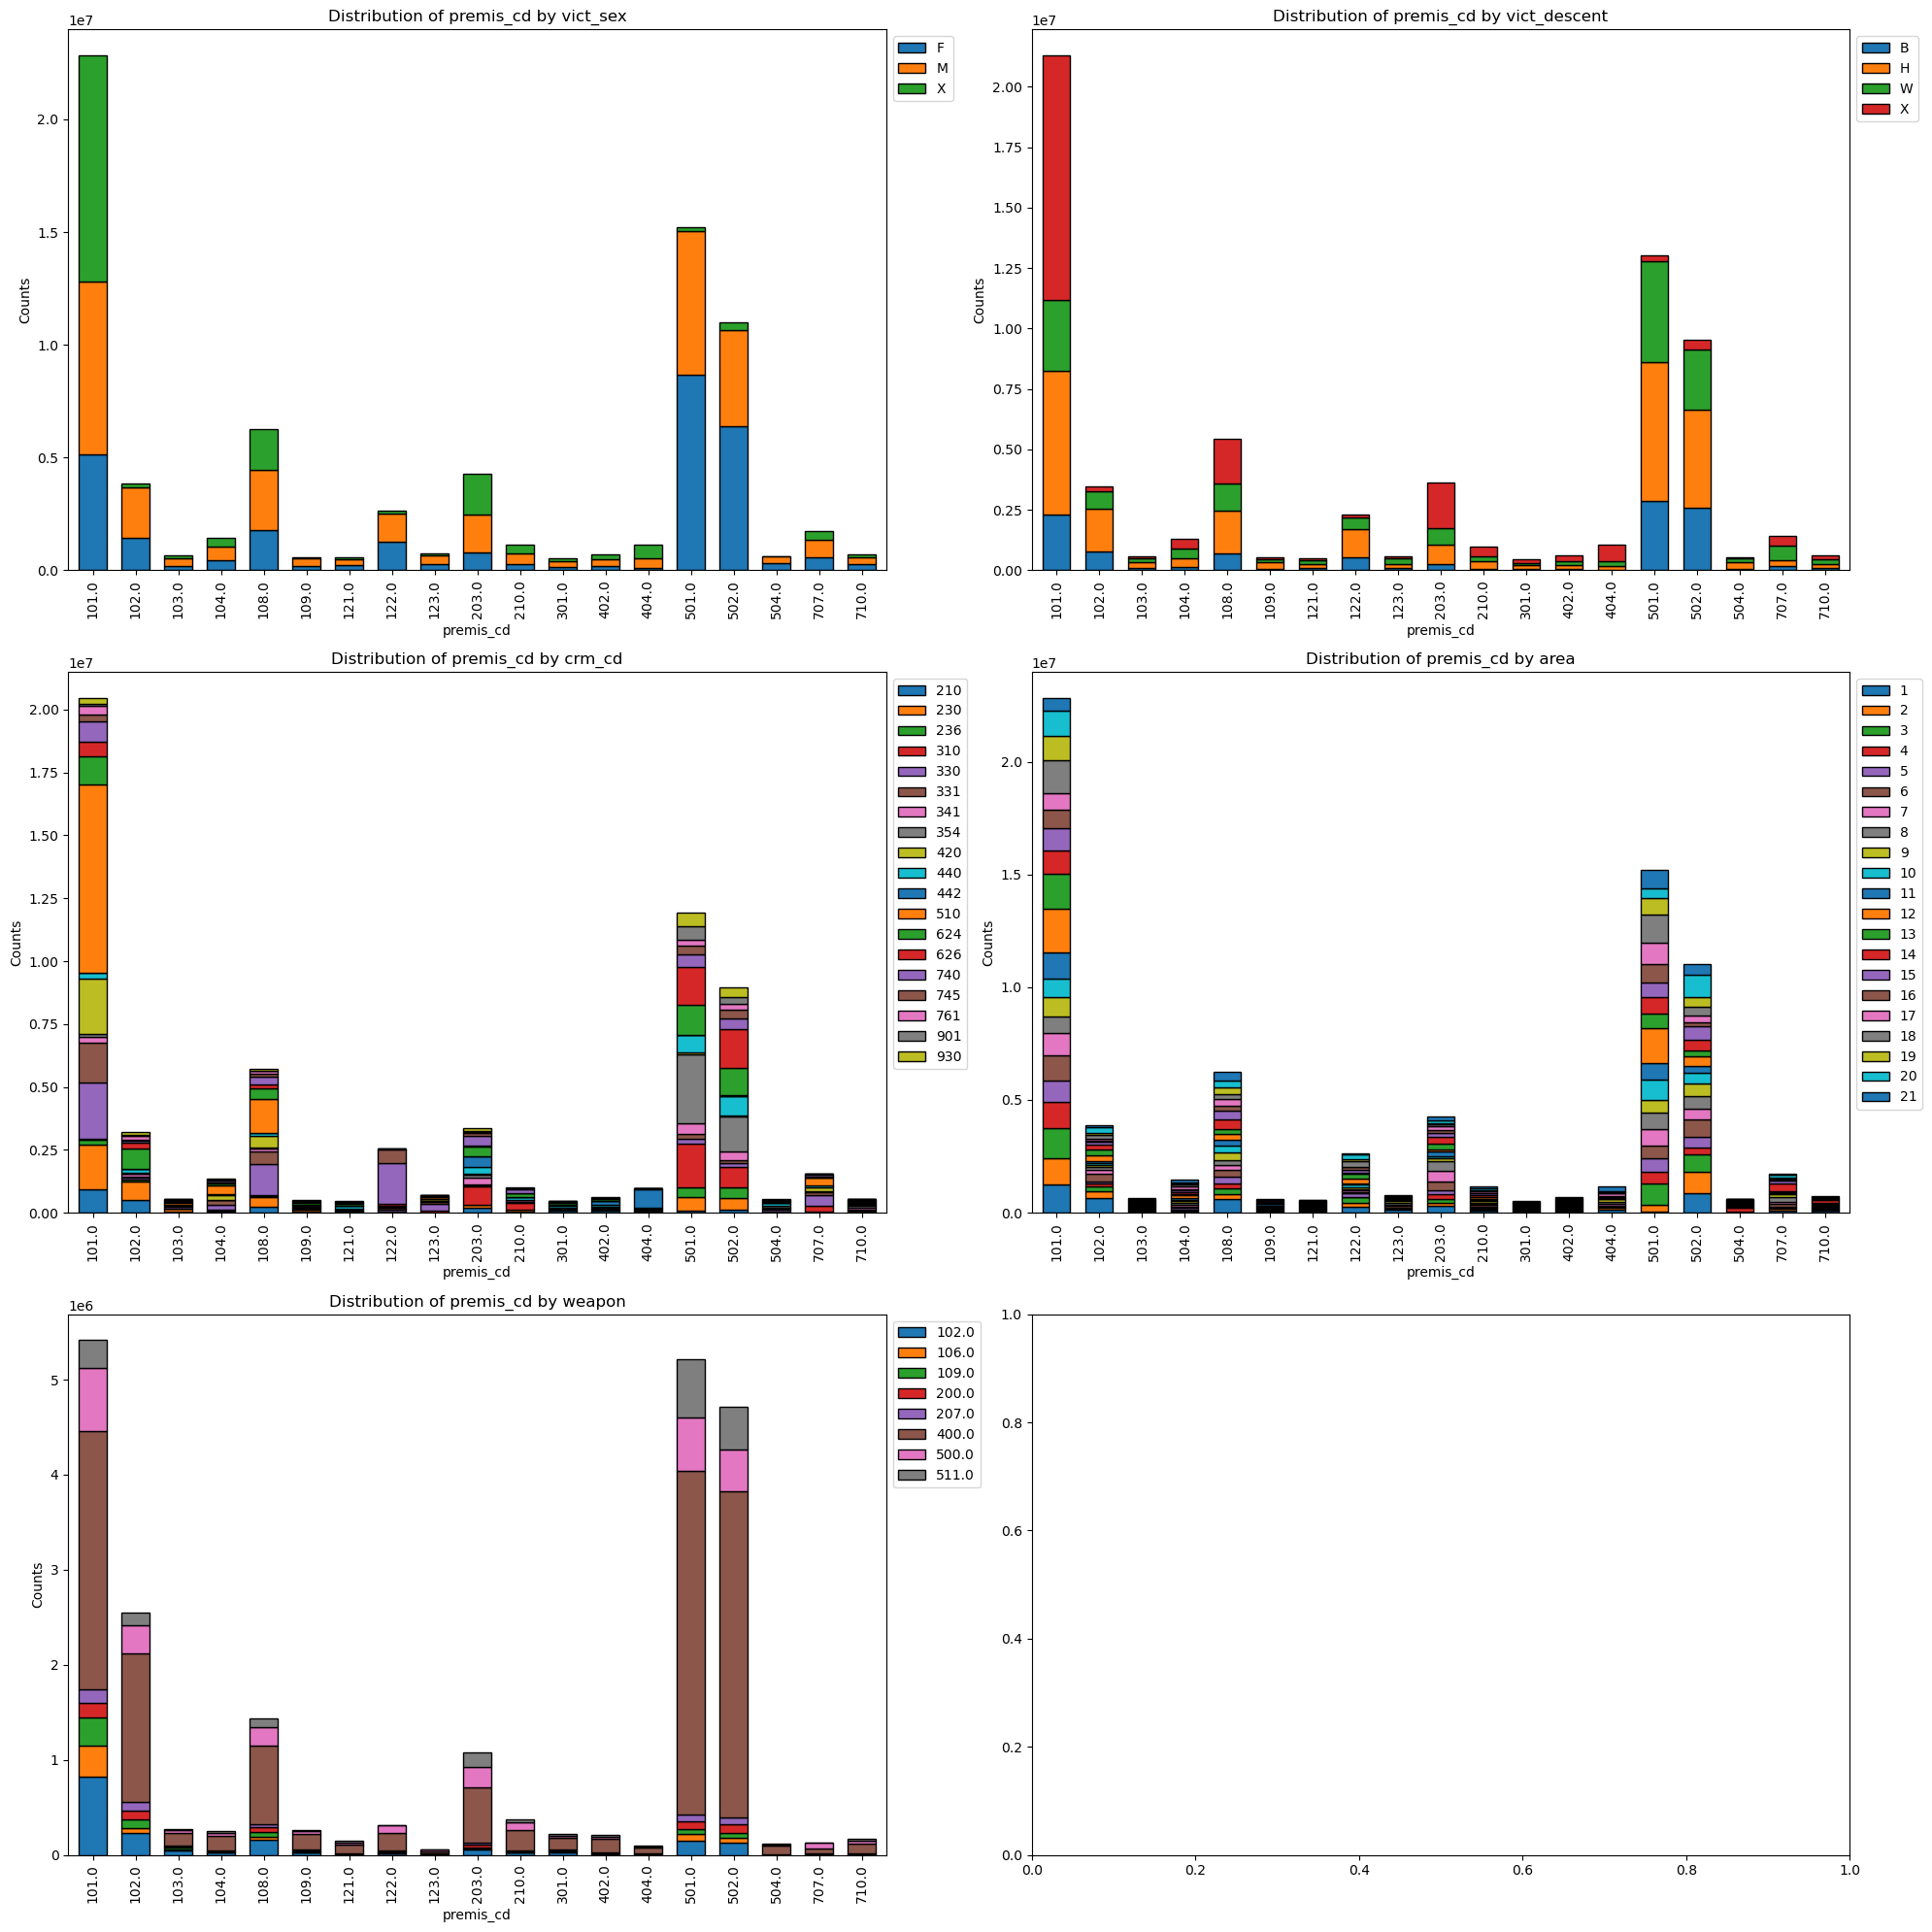

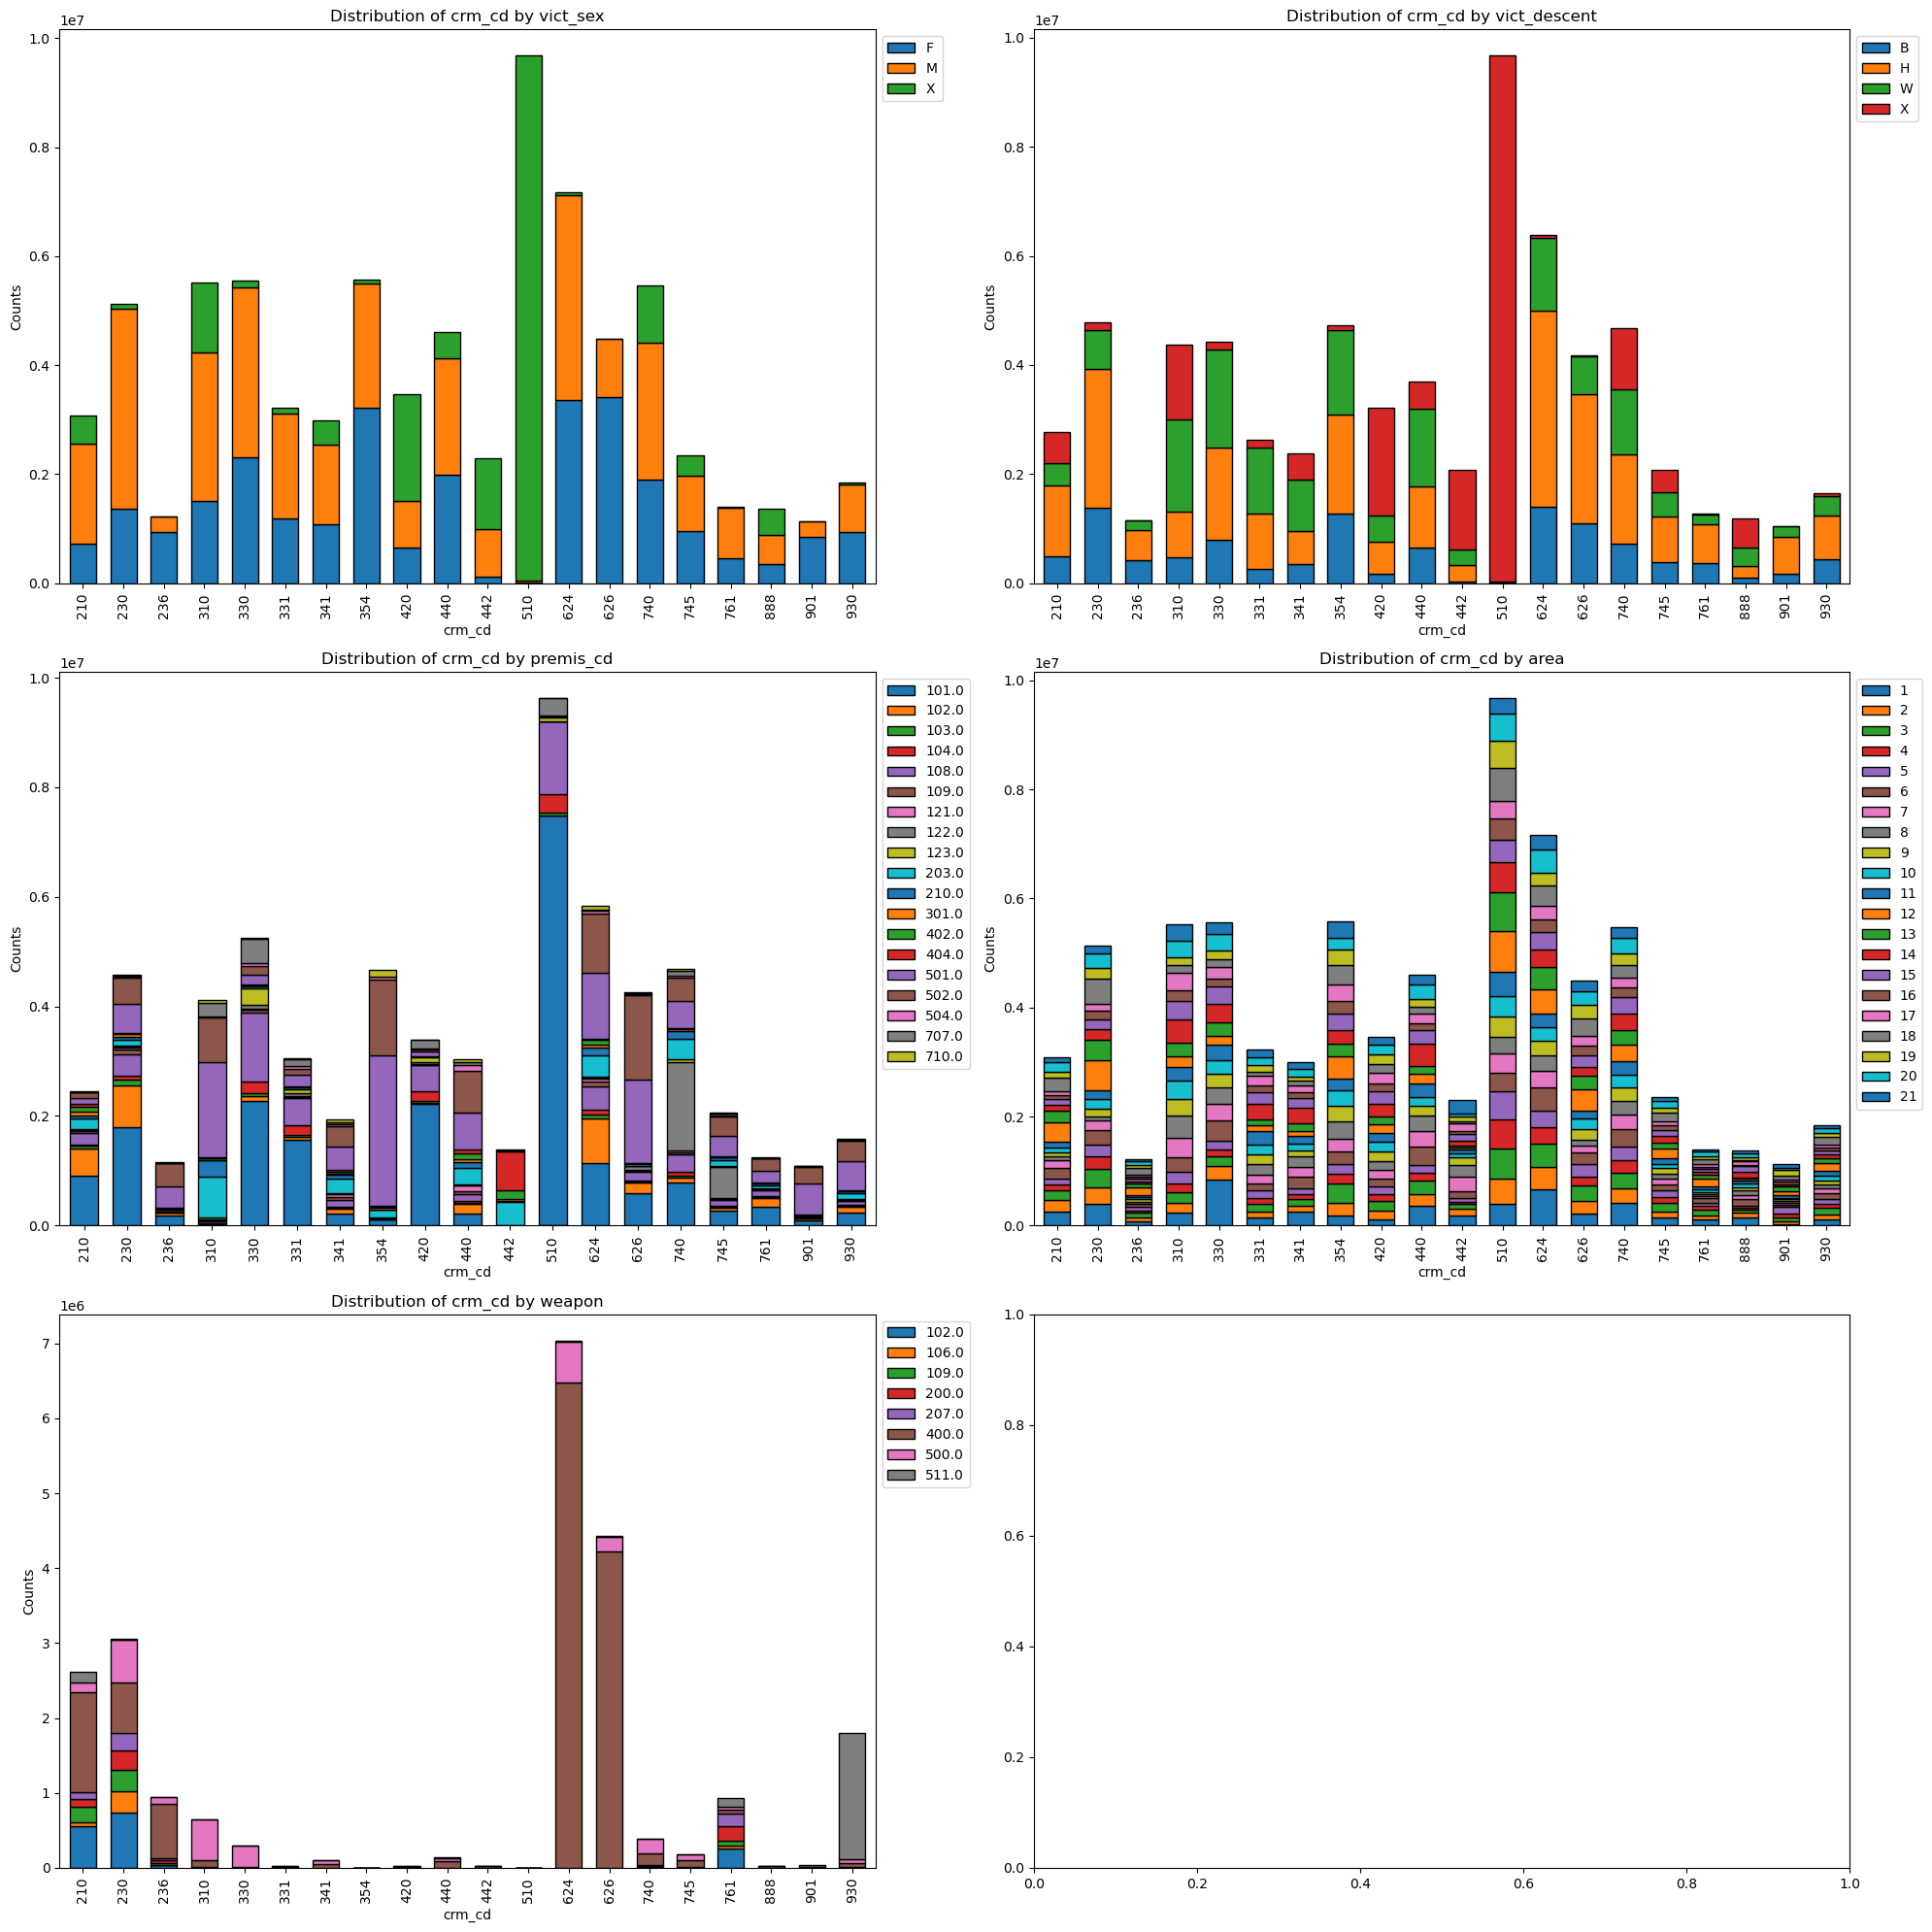

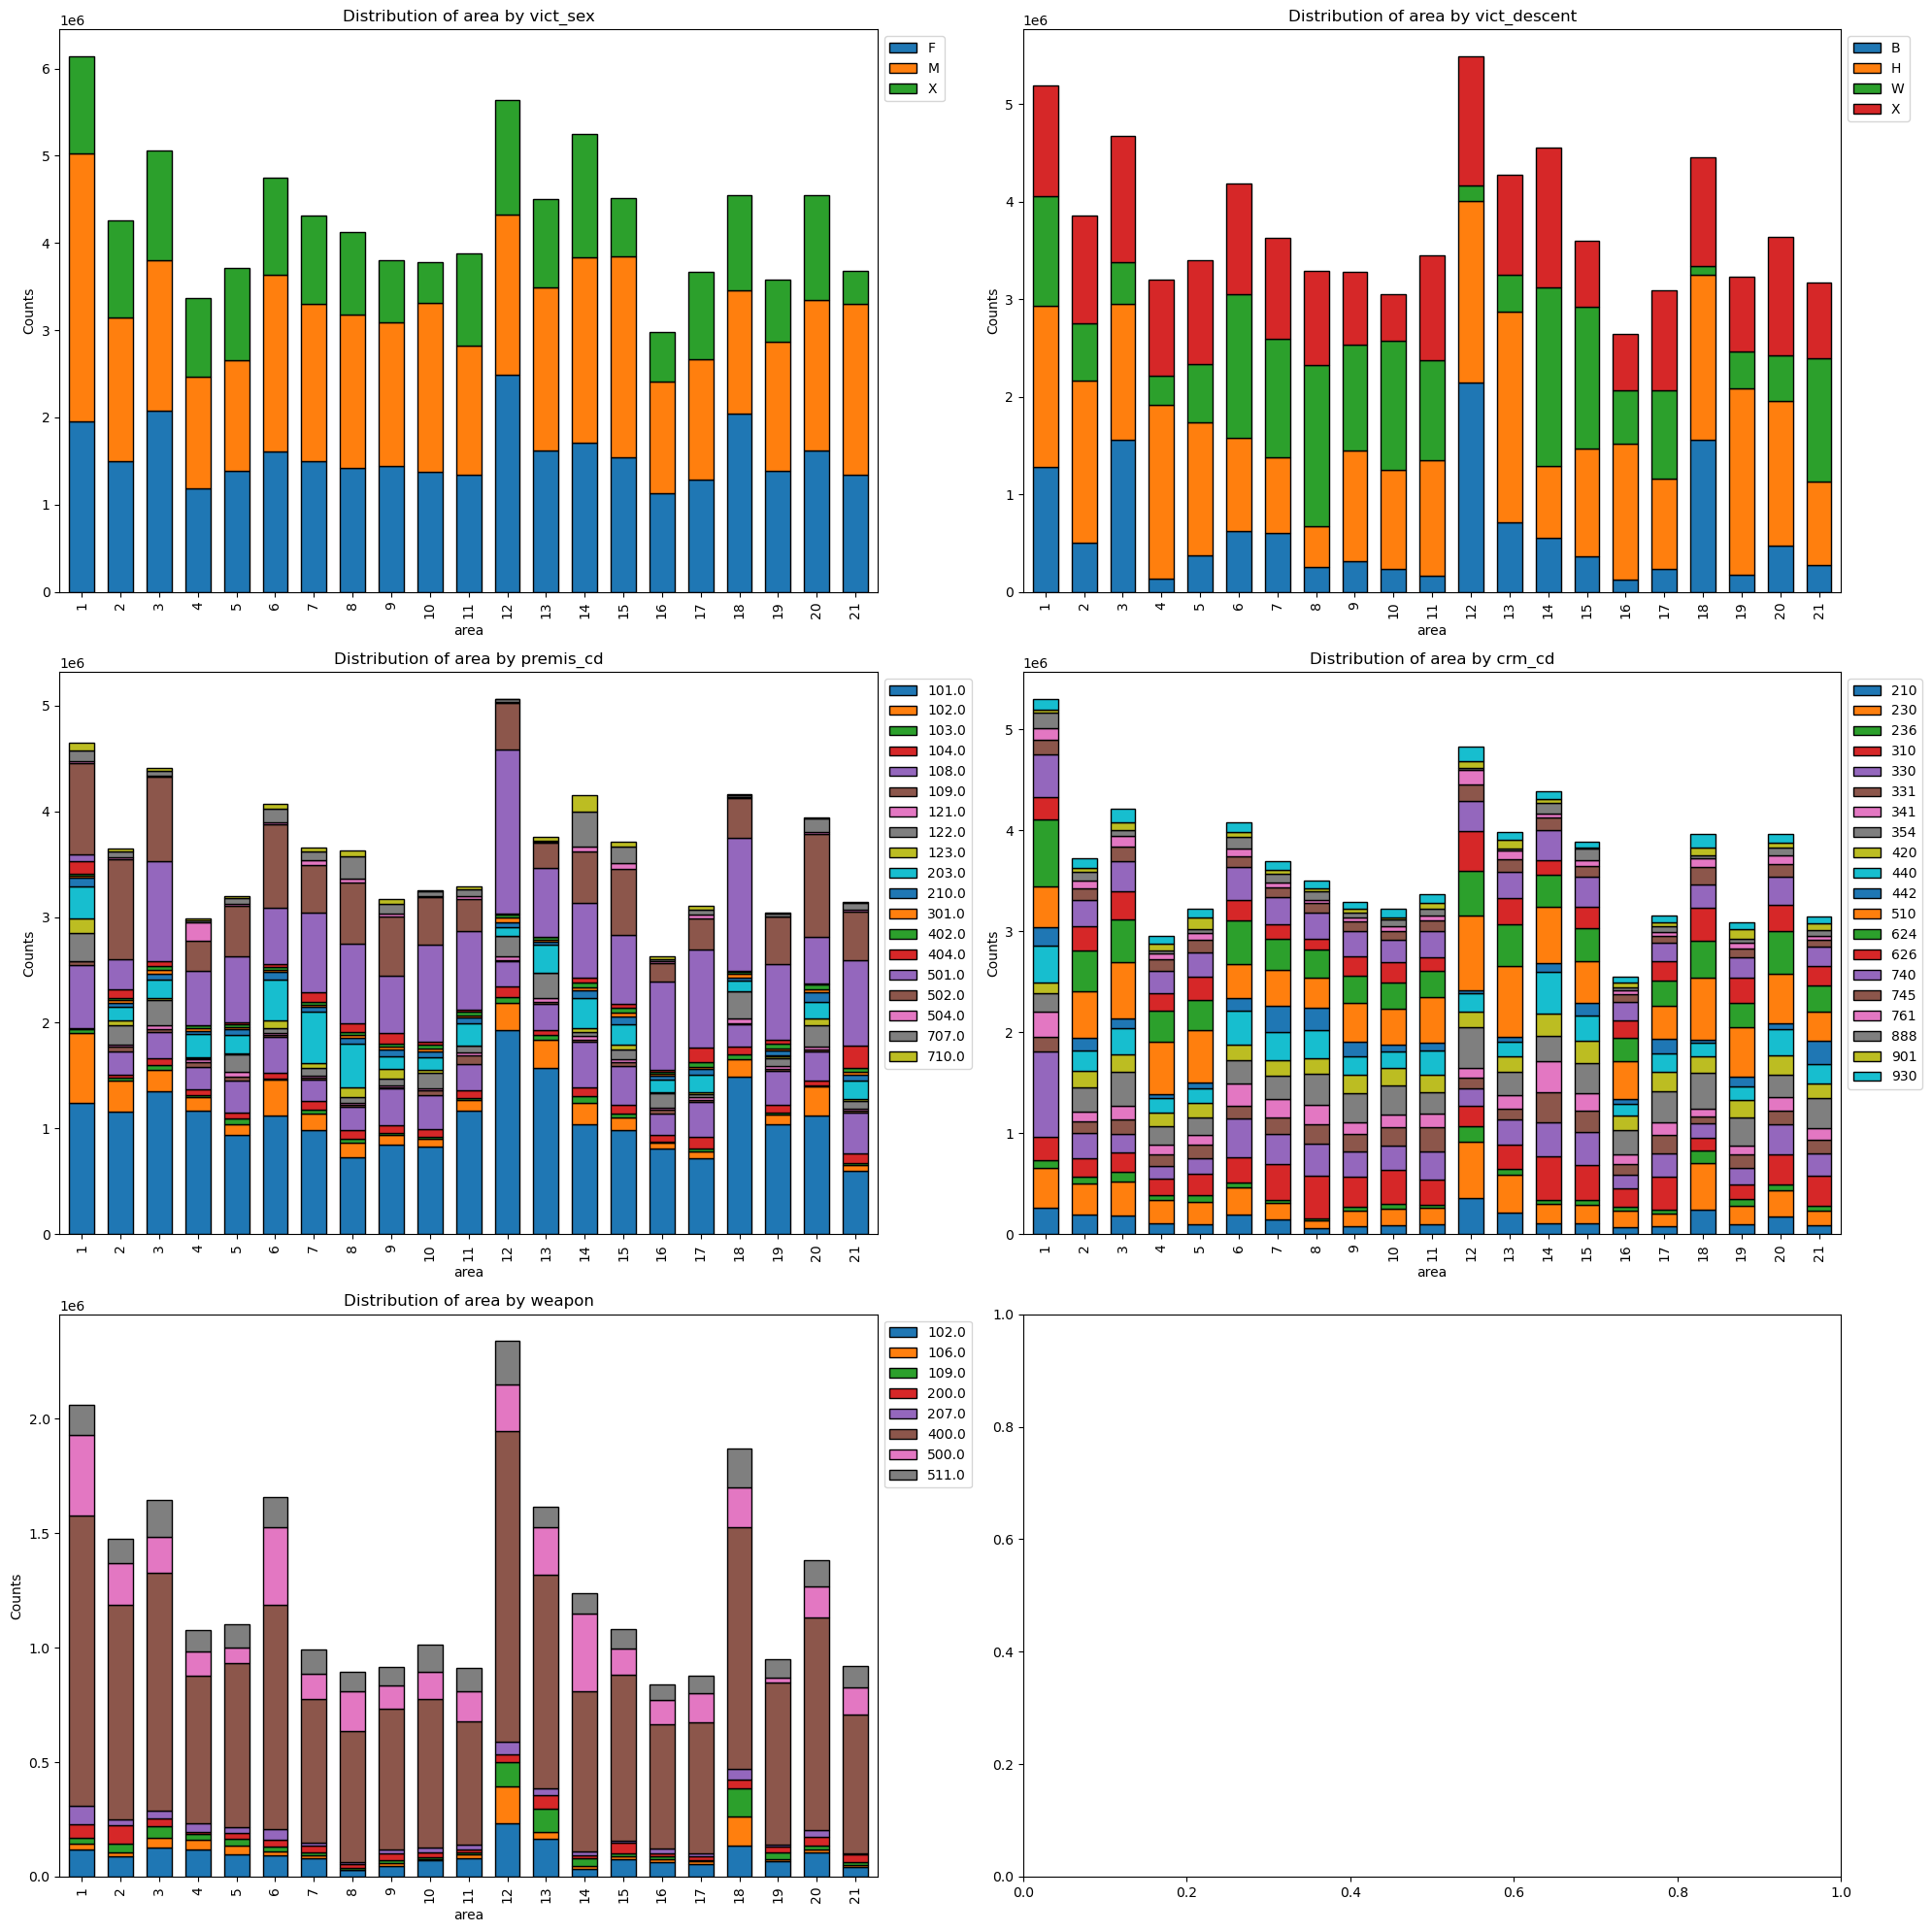

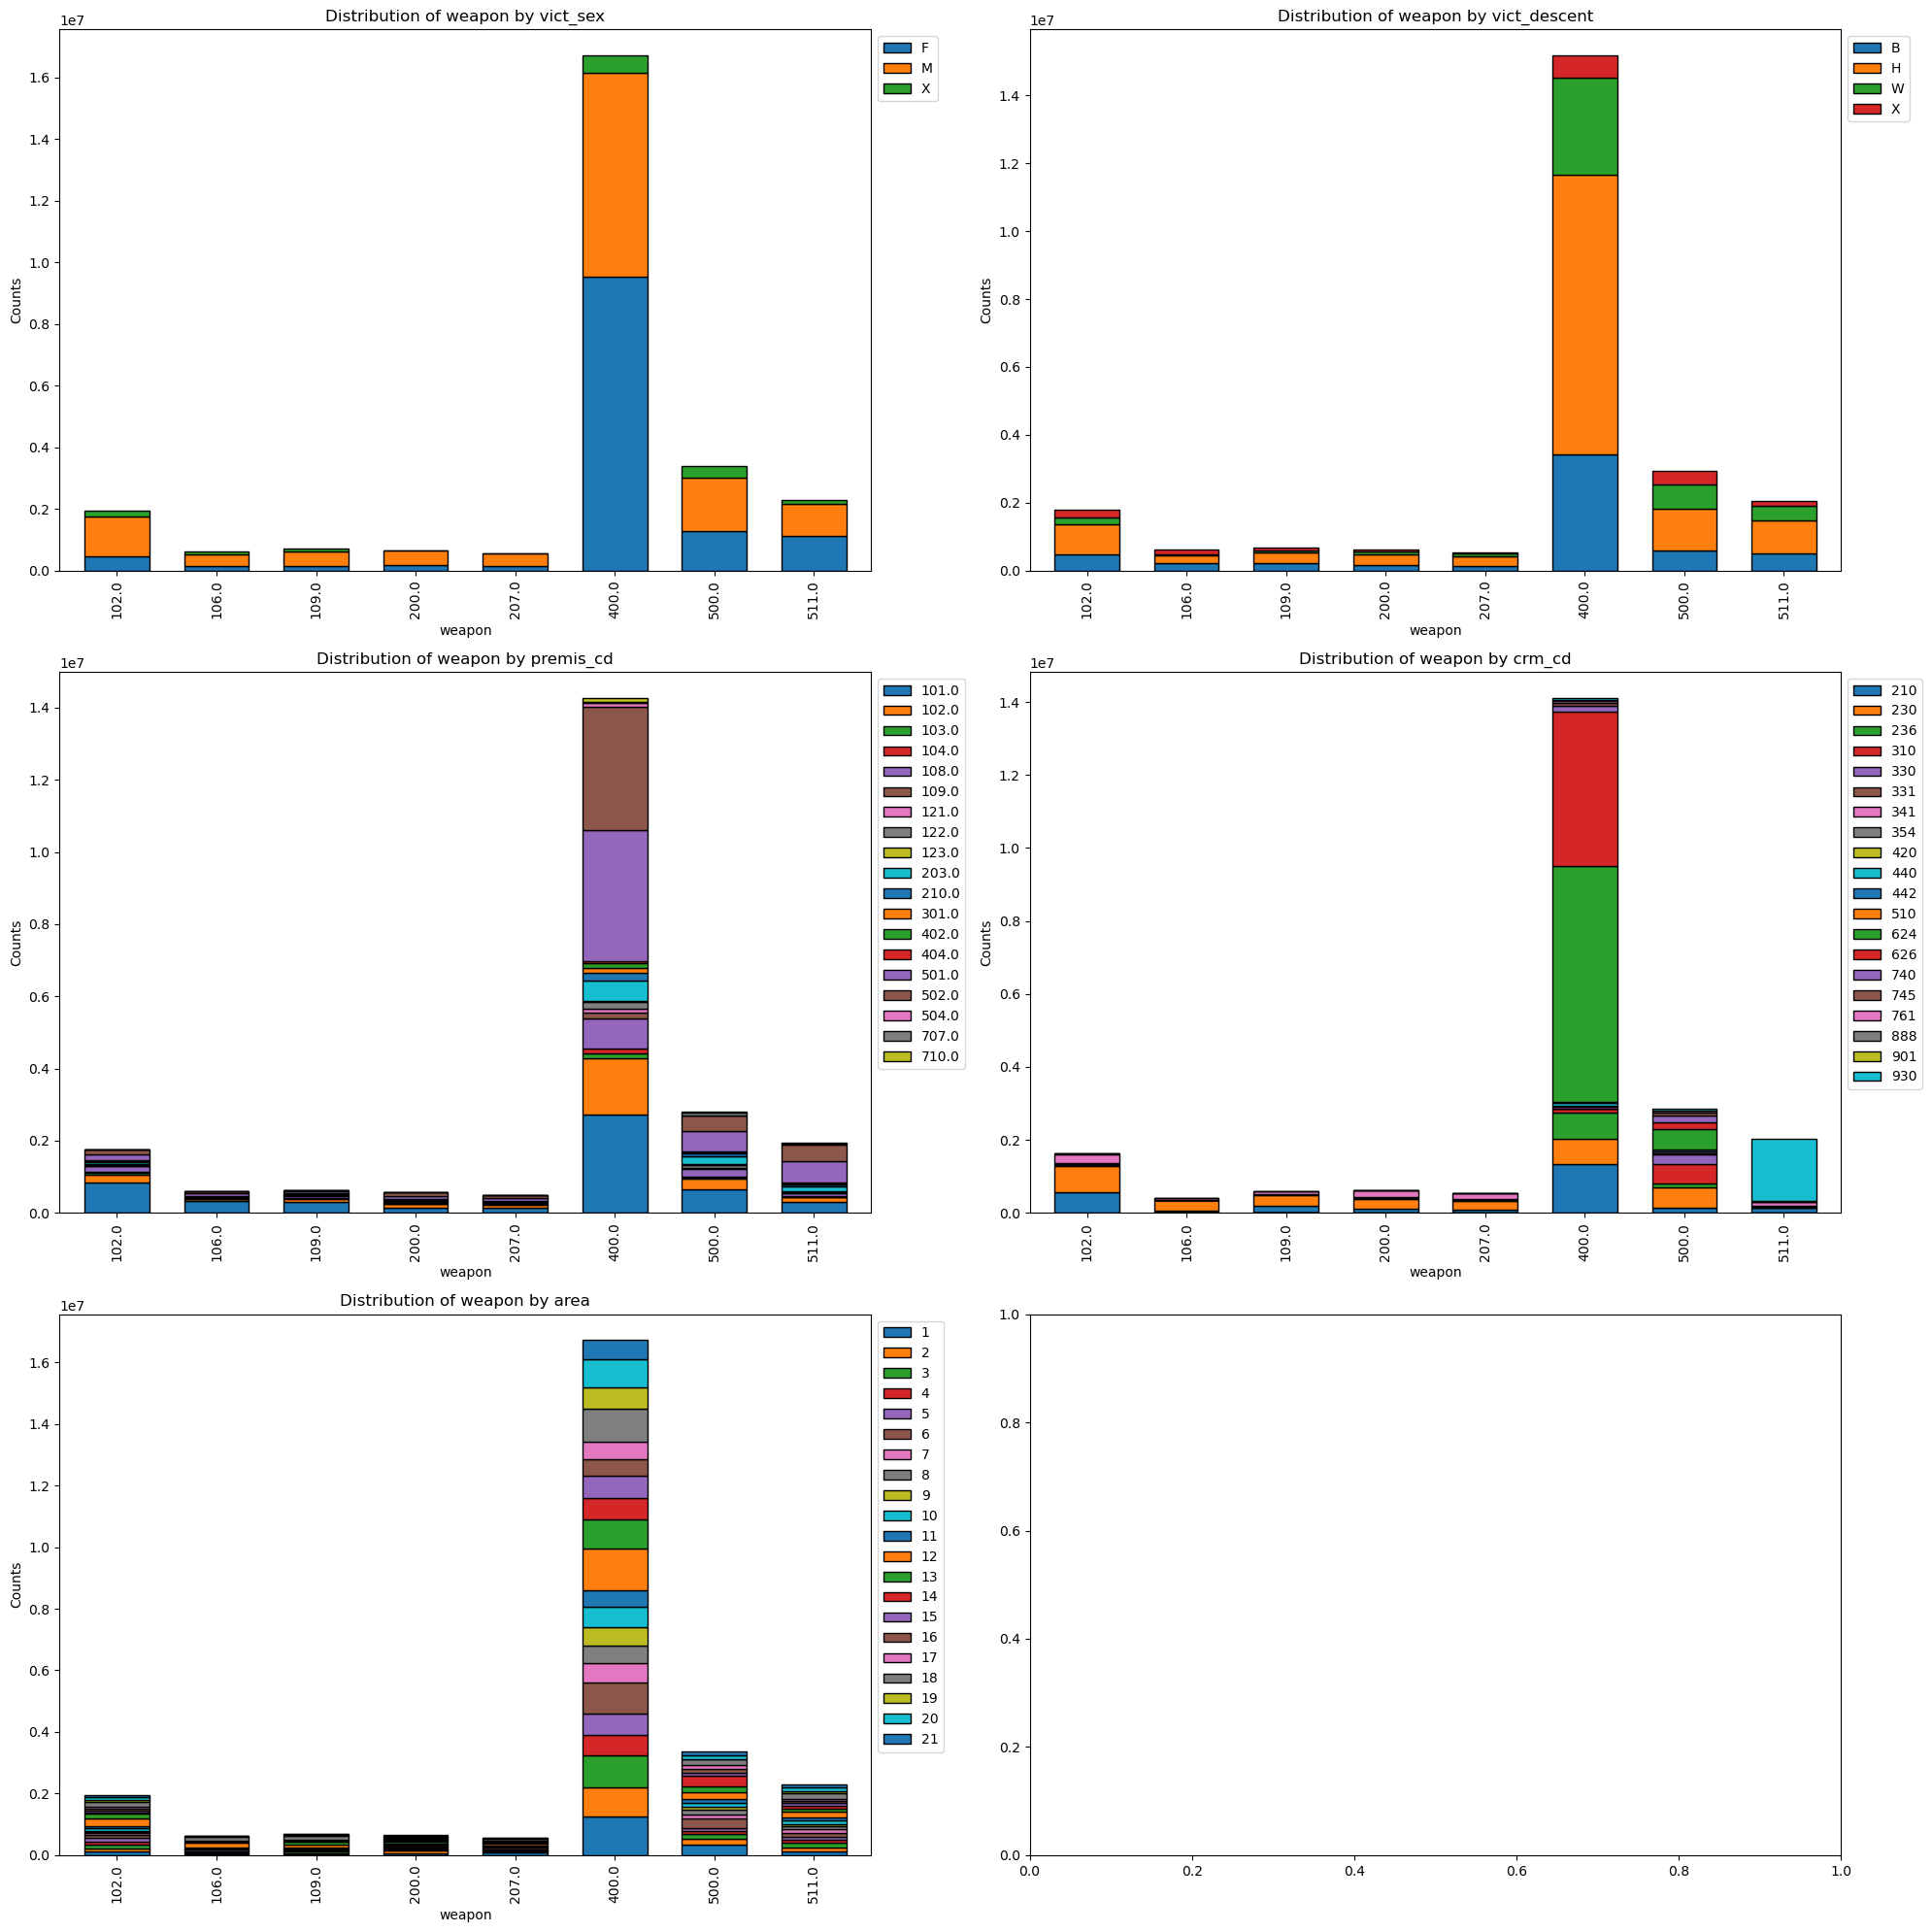

In [296]:
doBarplotWithHue(data=df_complete[cat_cols], normalize=False, filterPercentage=85)

### Stacked barplots for each categorical feature vs other categorical features (Normalized)
The y-axis is the percentage of each combination for the feature in x-axis.

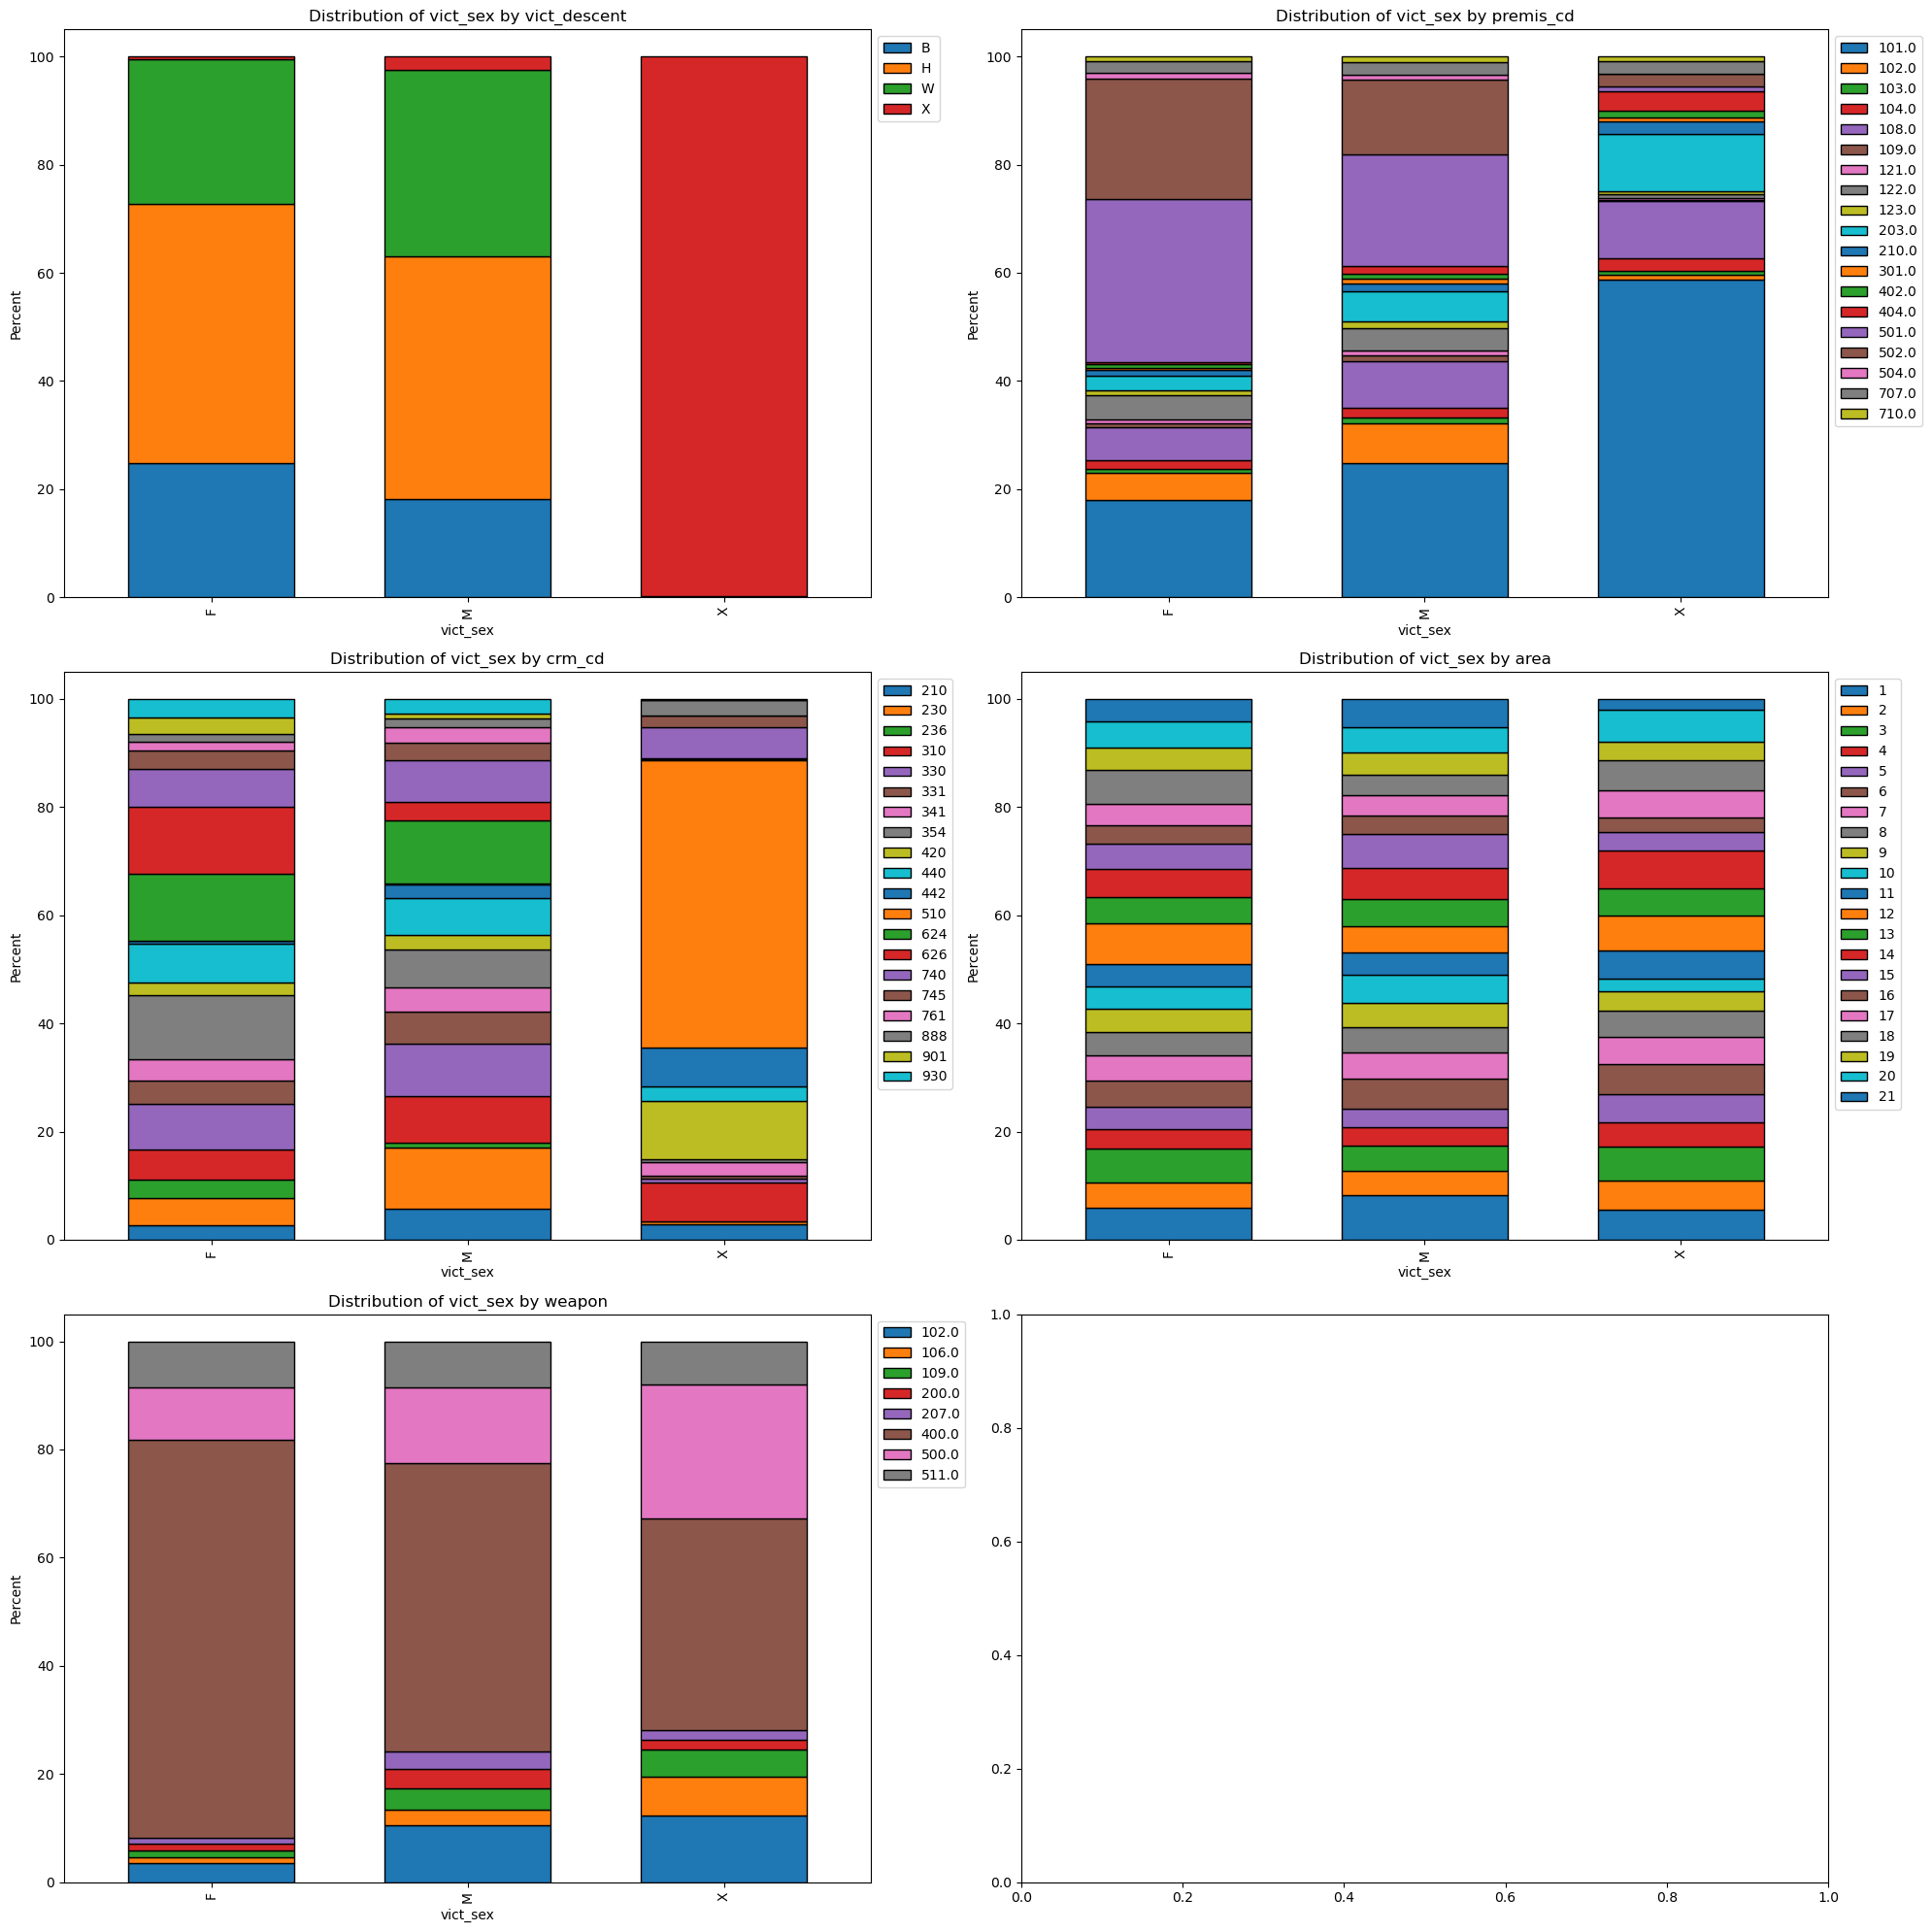

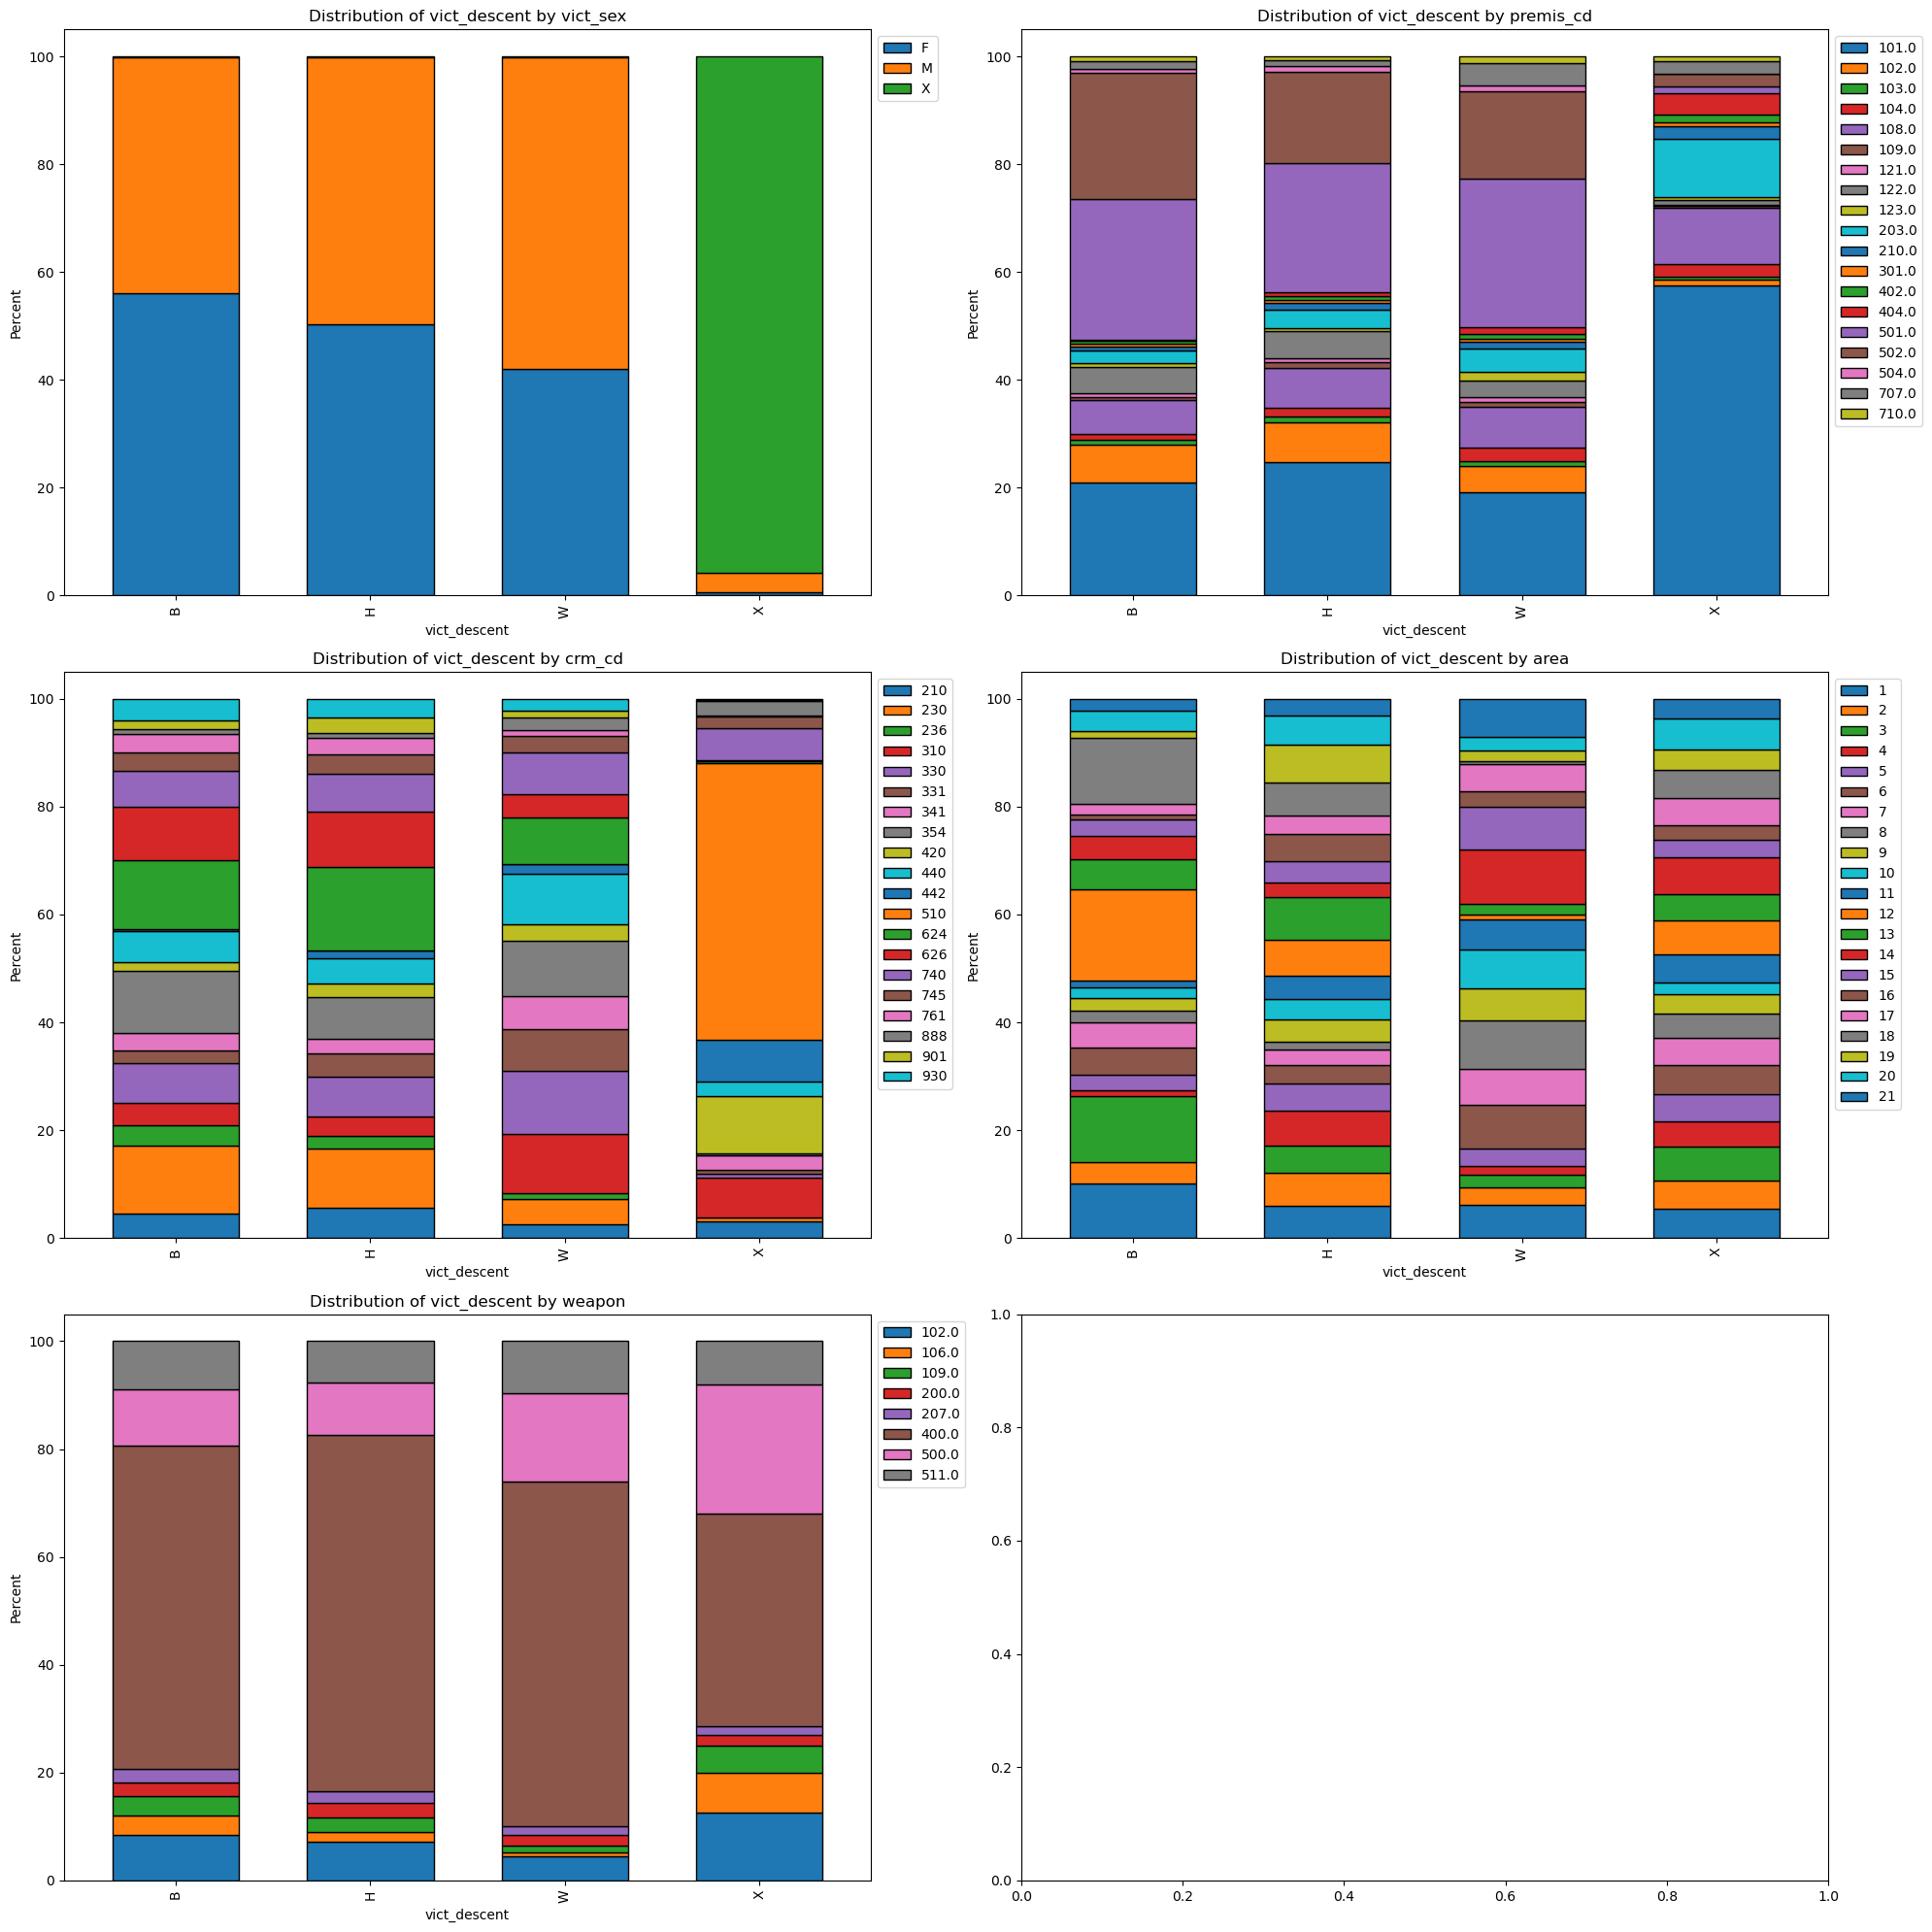

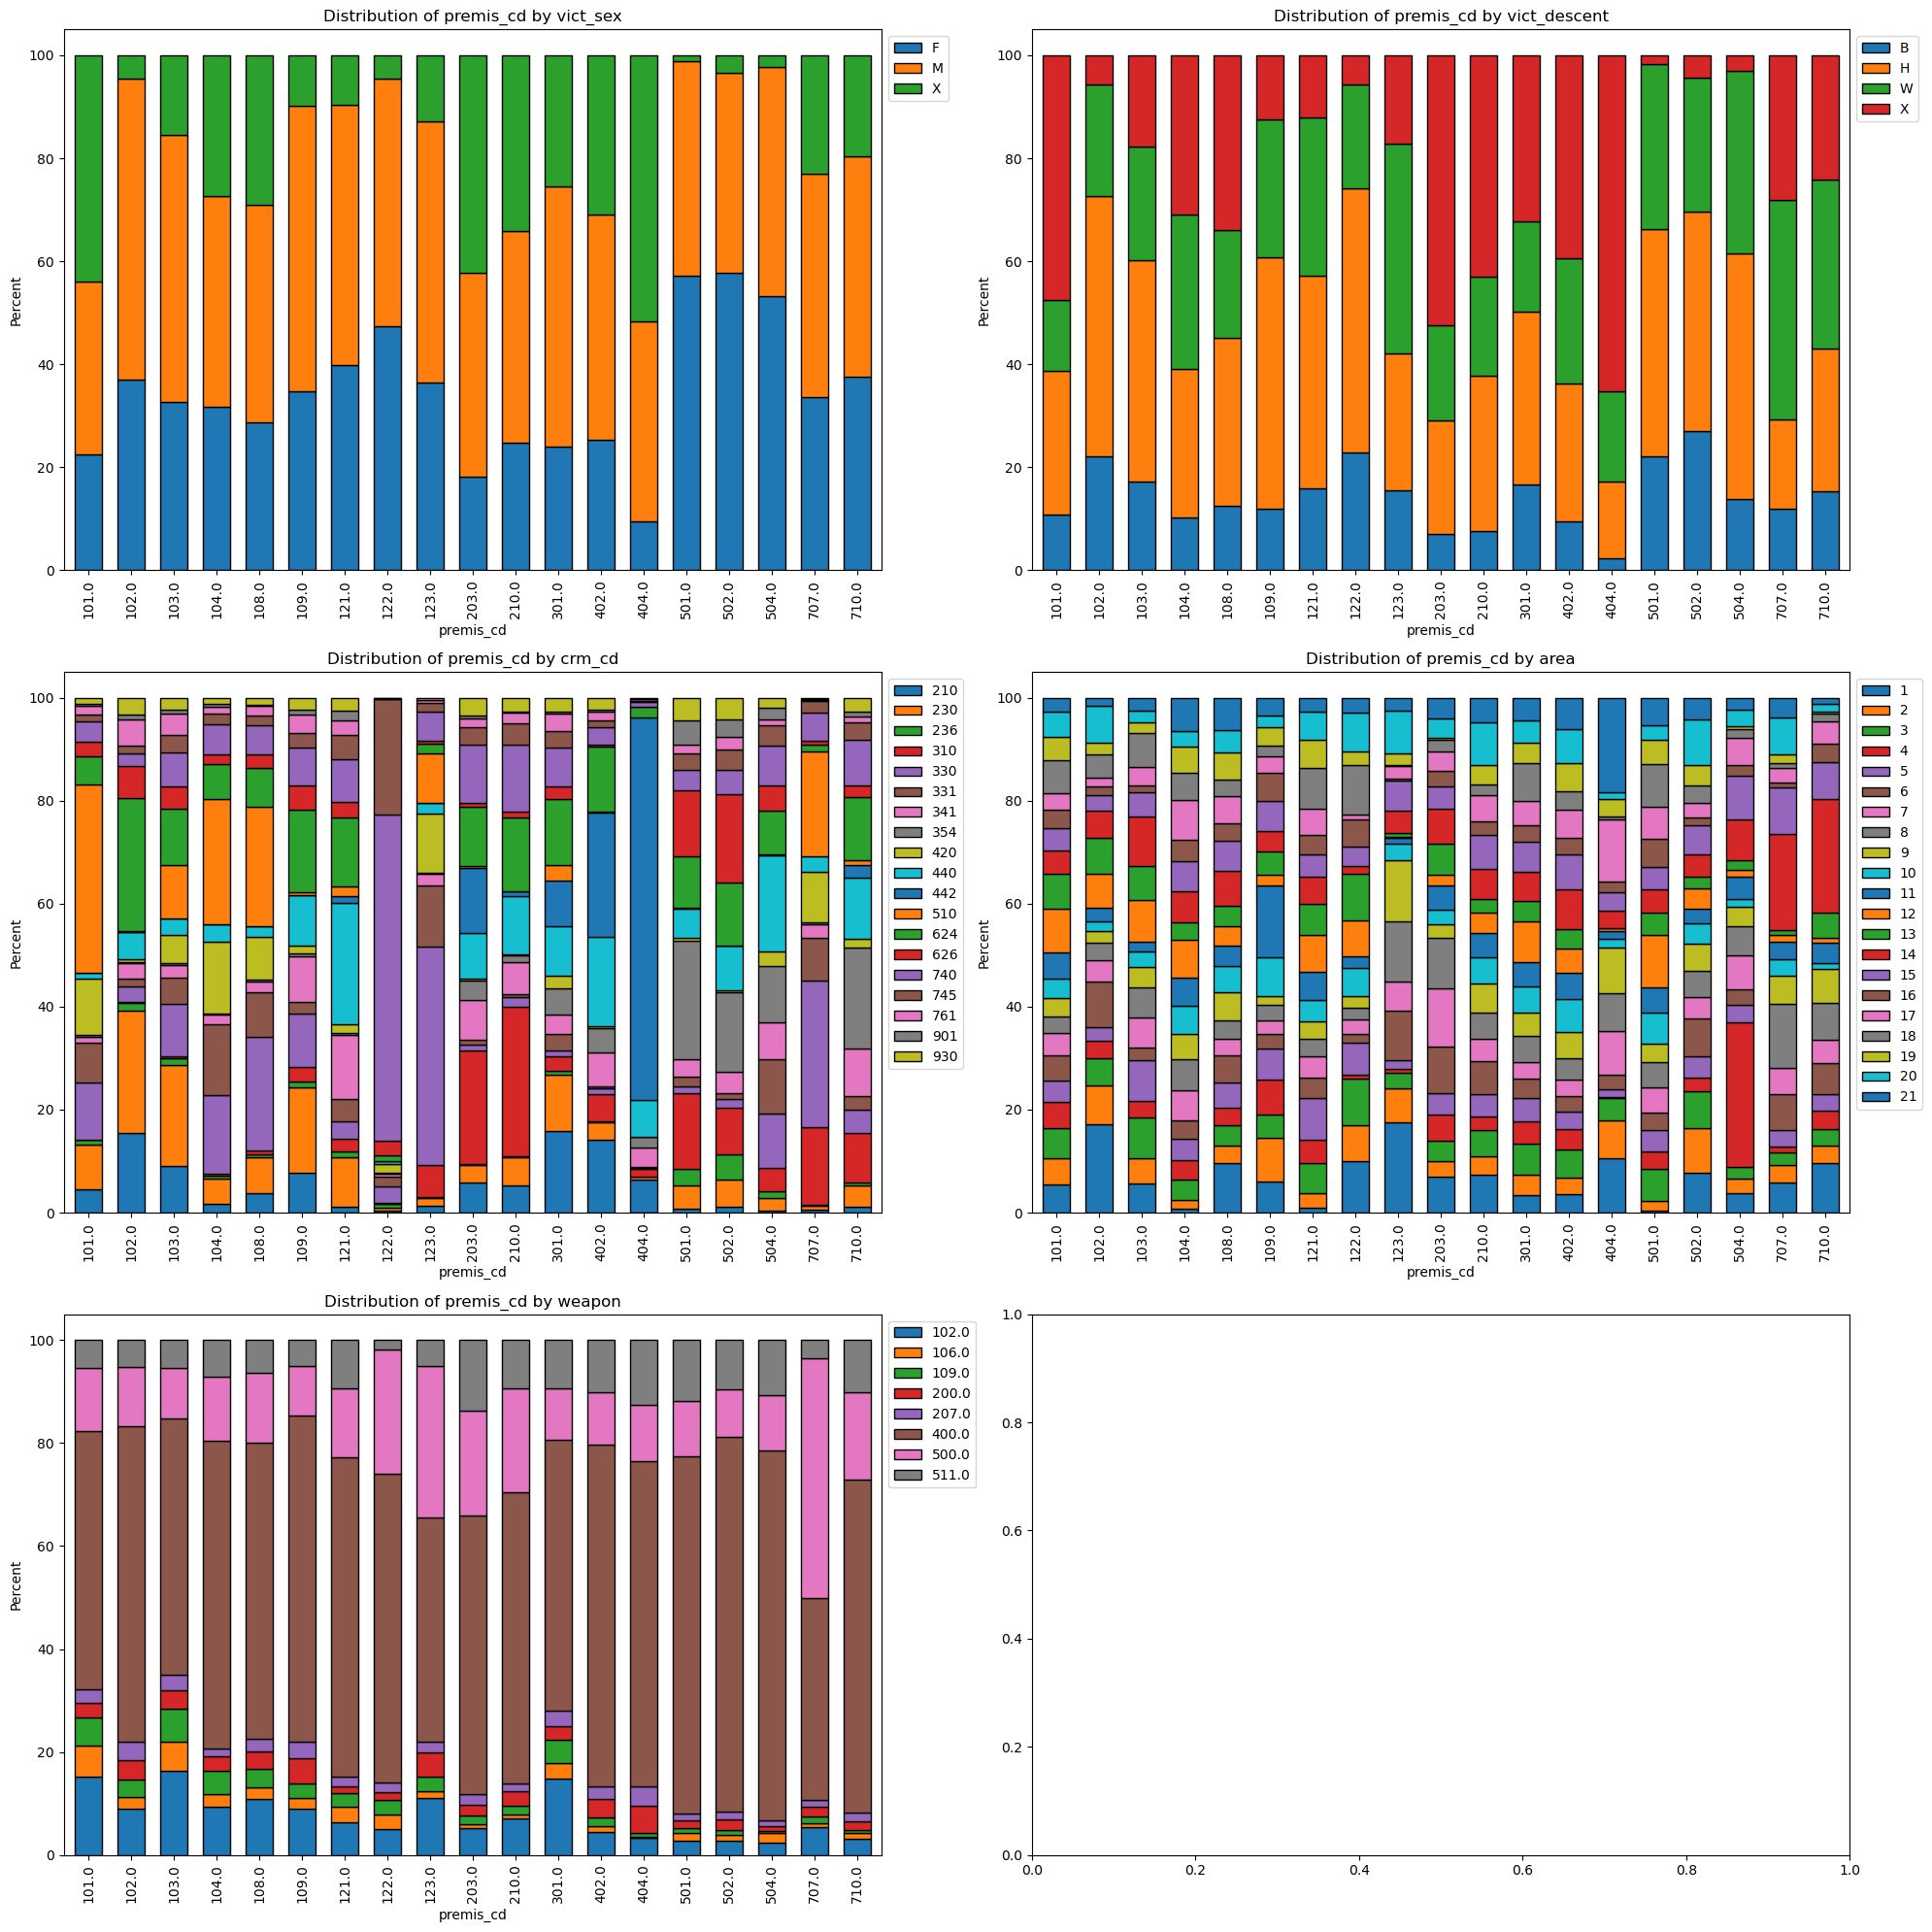

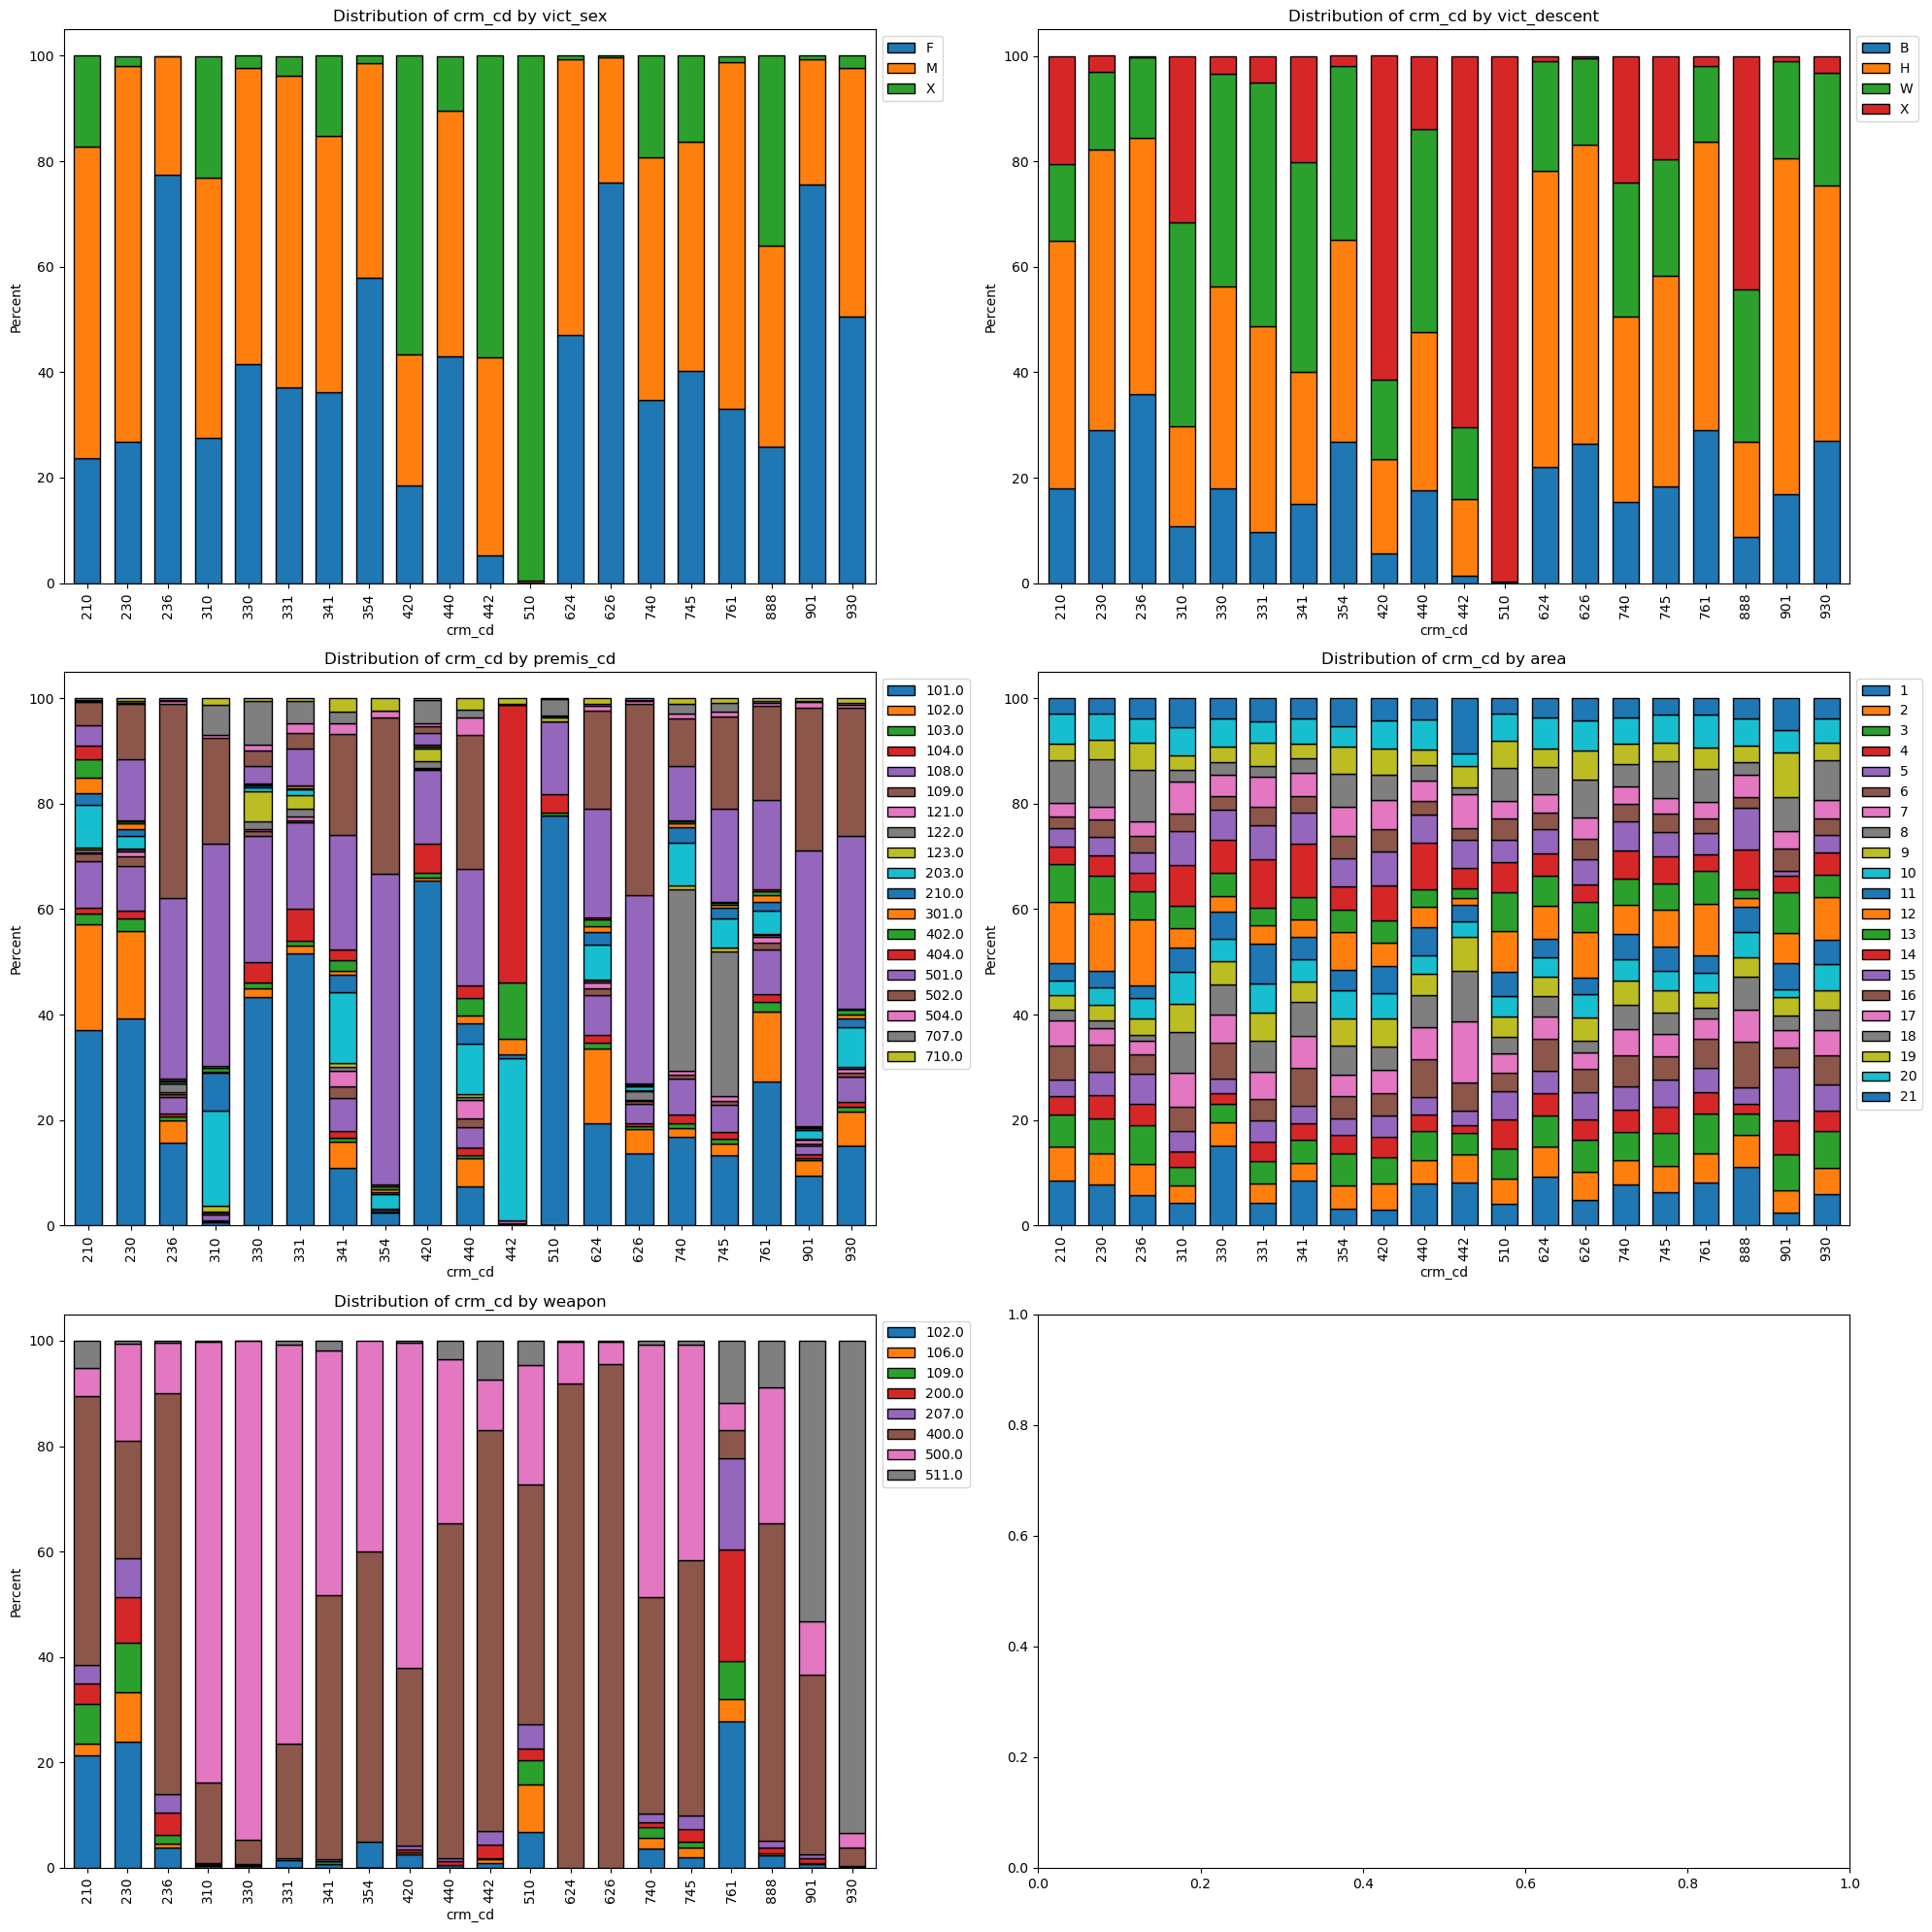

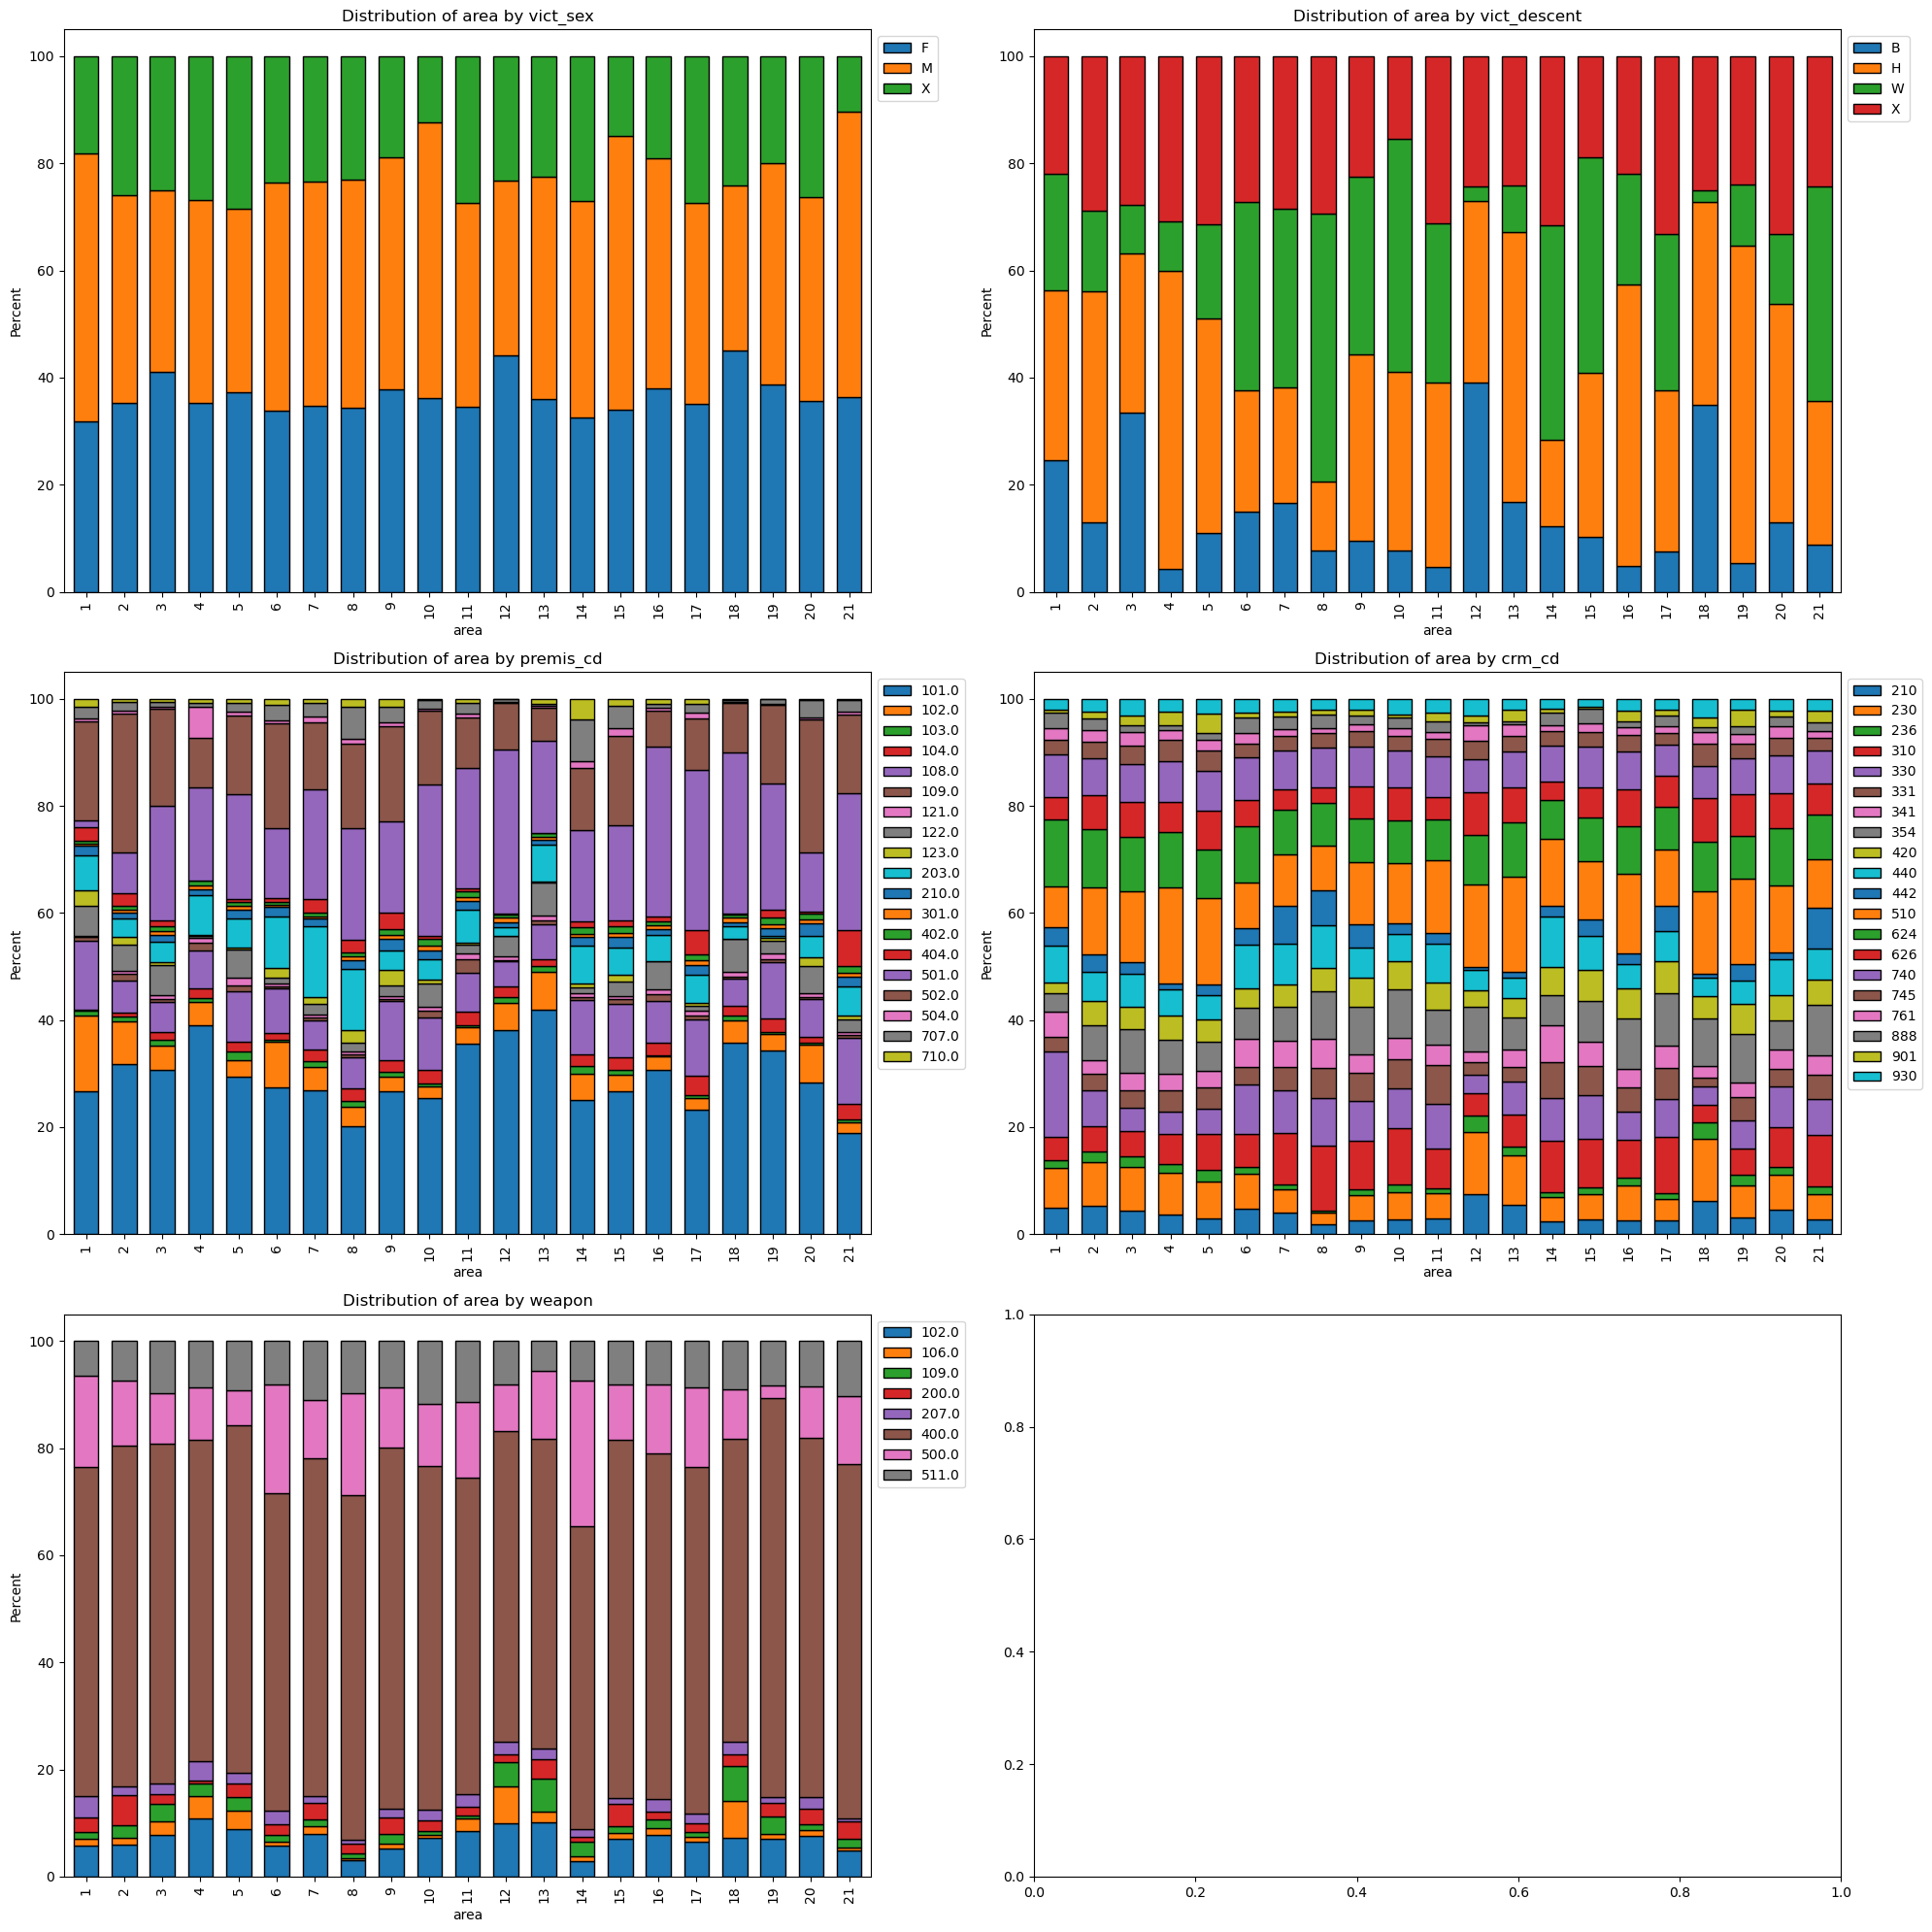

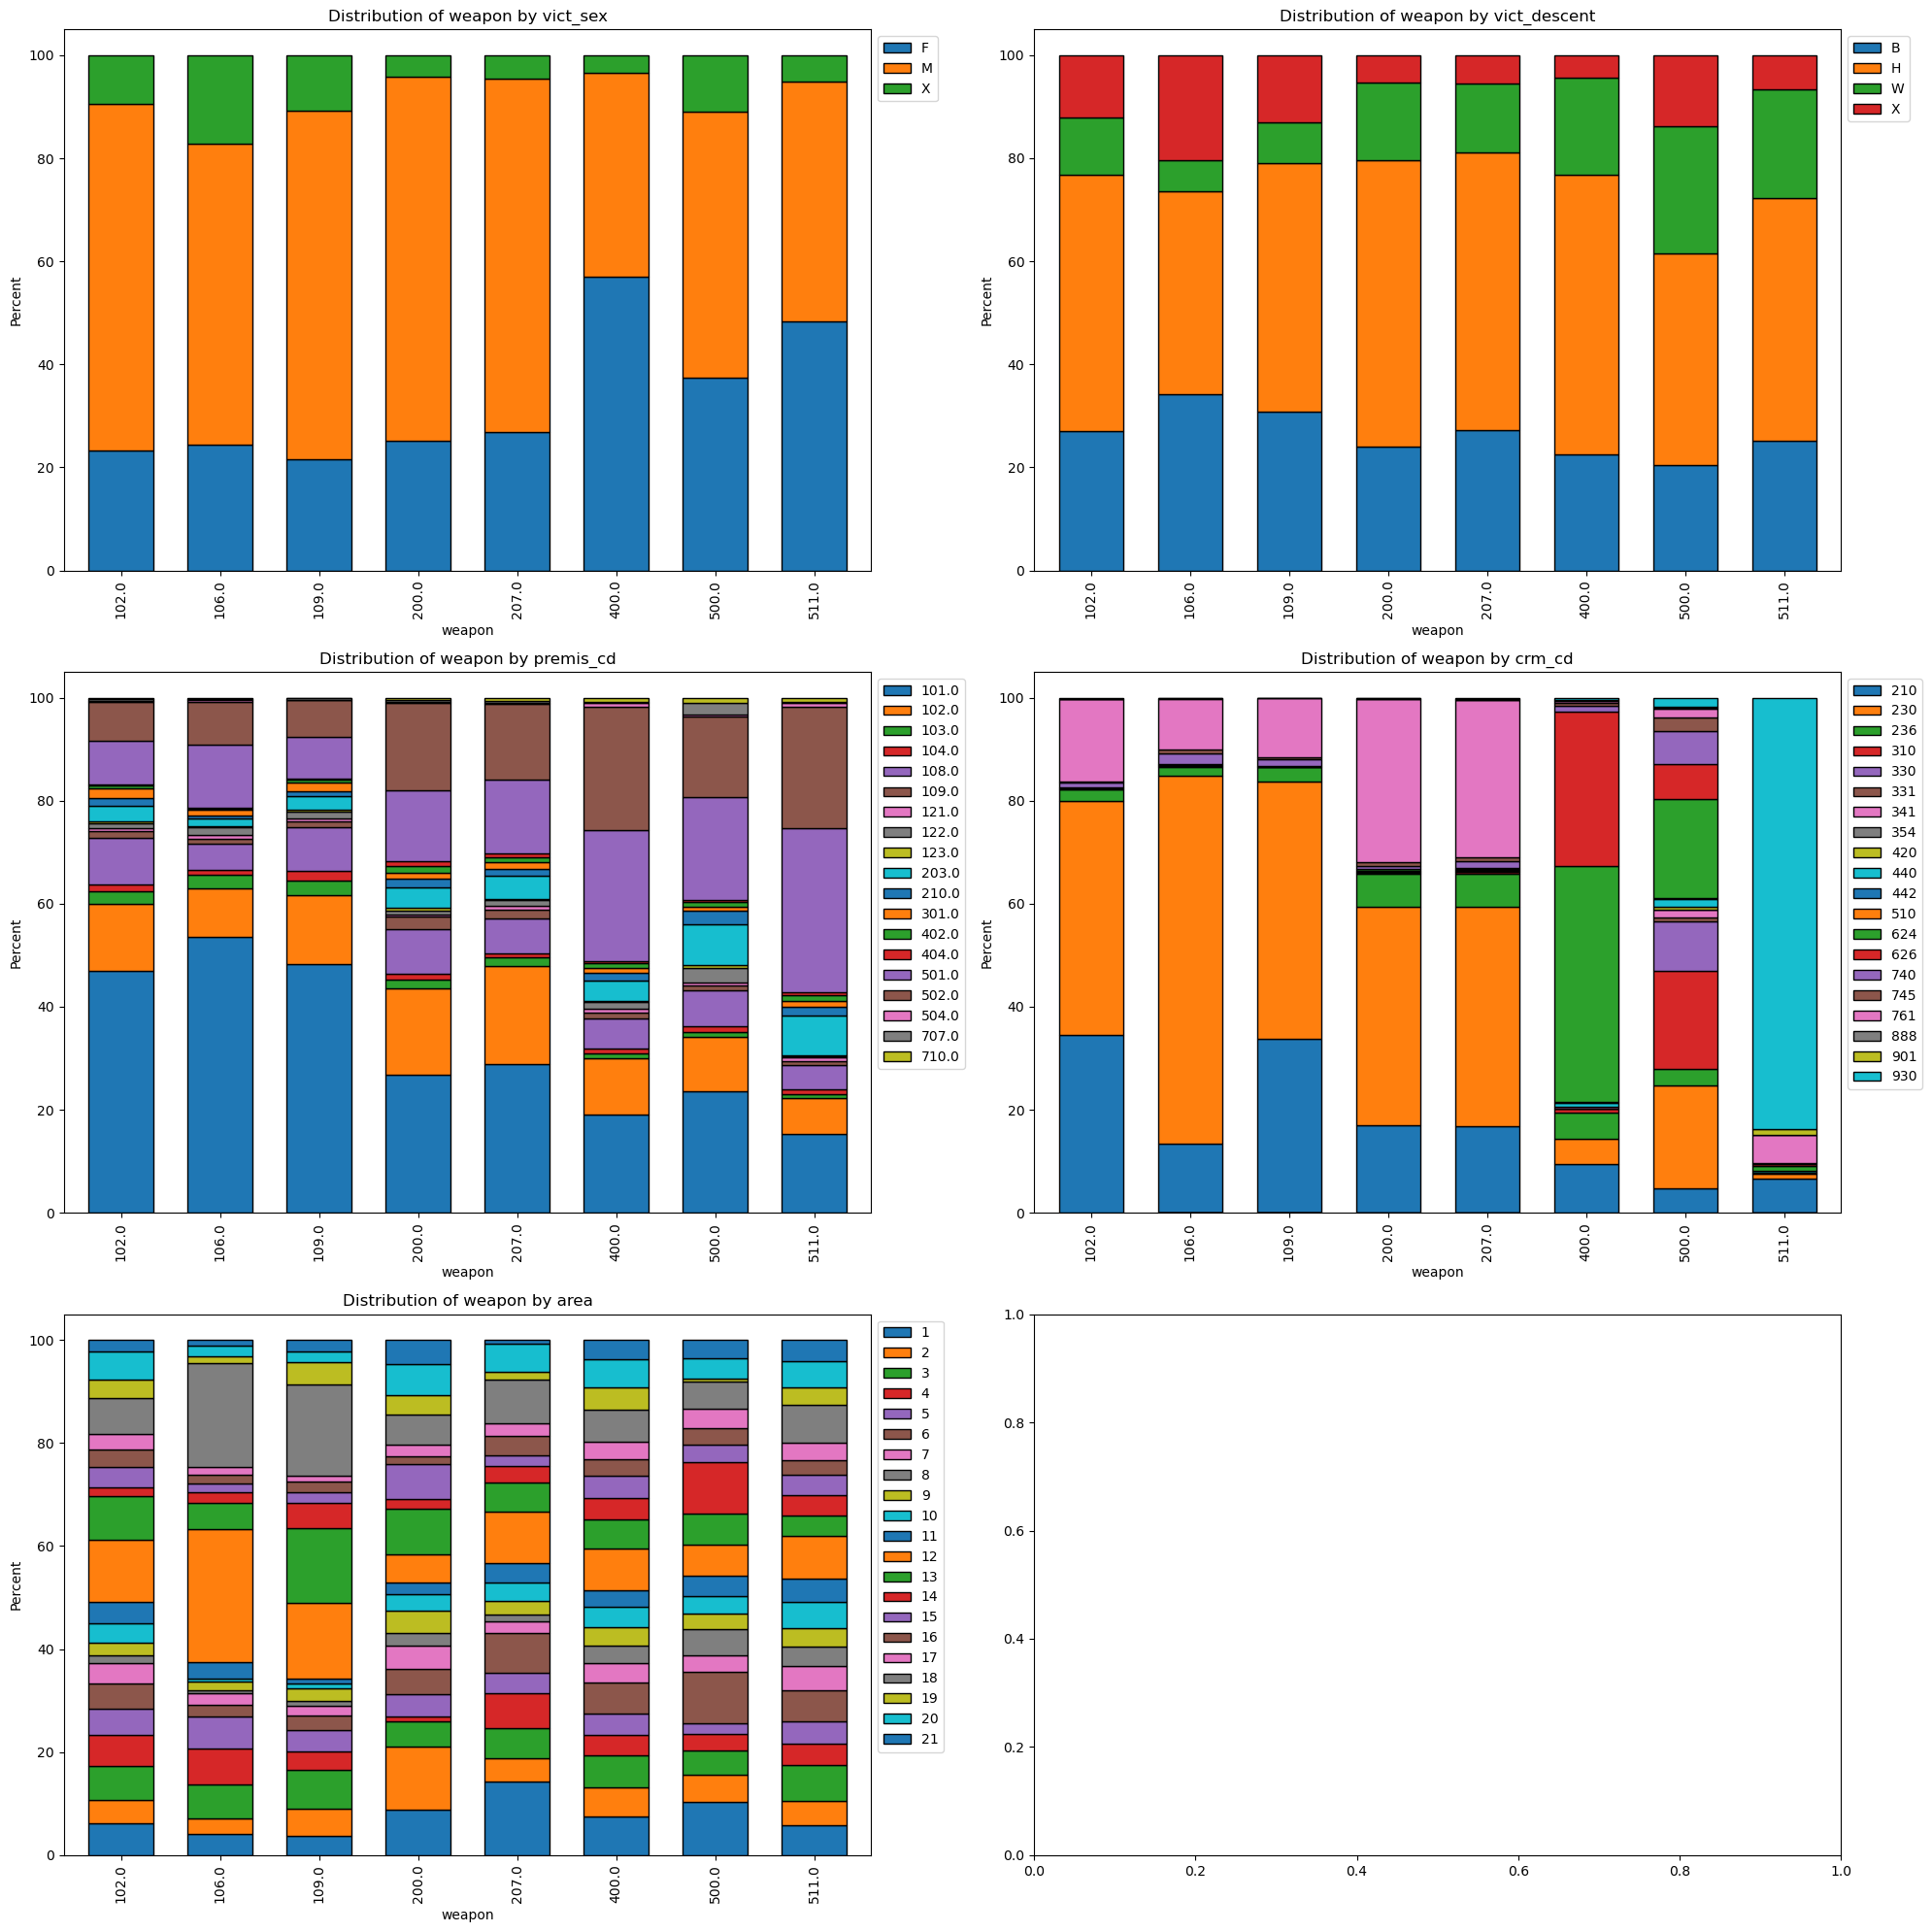

In [297]:
doBarplotWithHue(data=df_complete[cat_cols], normalize=True, filterPercentage=85)

### Heatmap for each categorical feature vs other categorical features
Colorbar is the number of combinations for the features in x and y axis

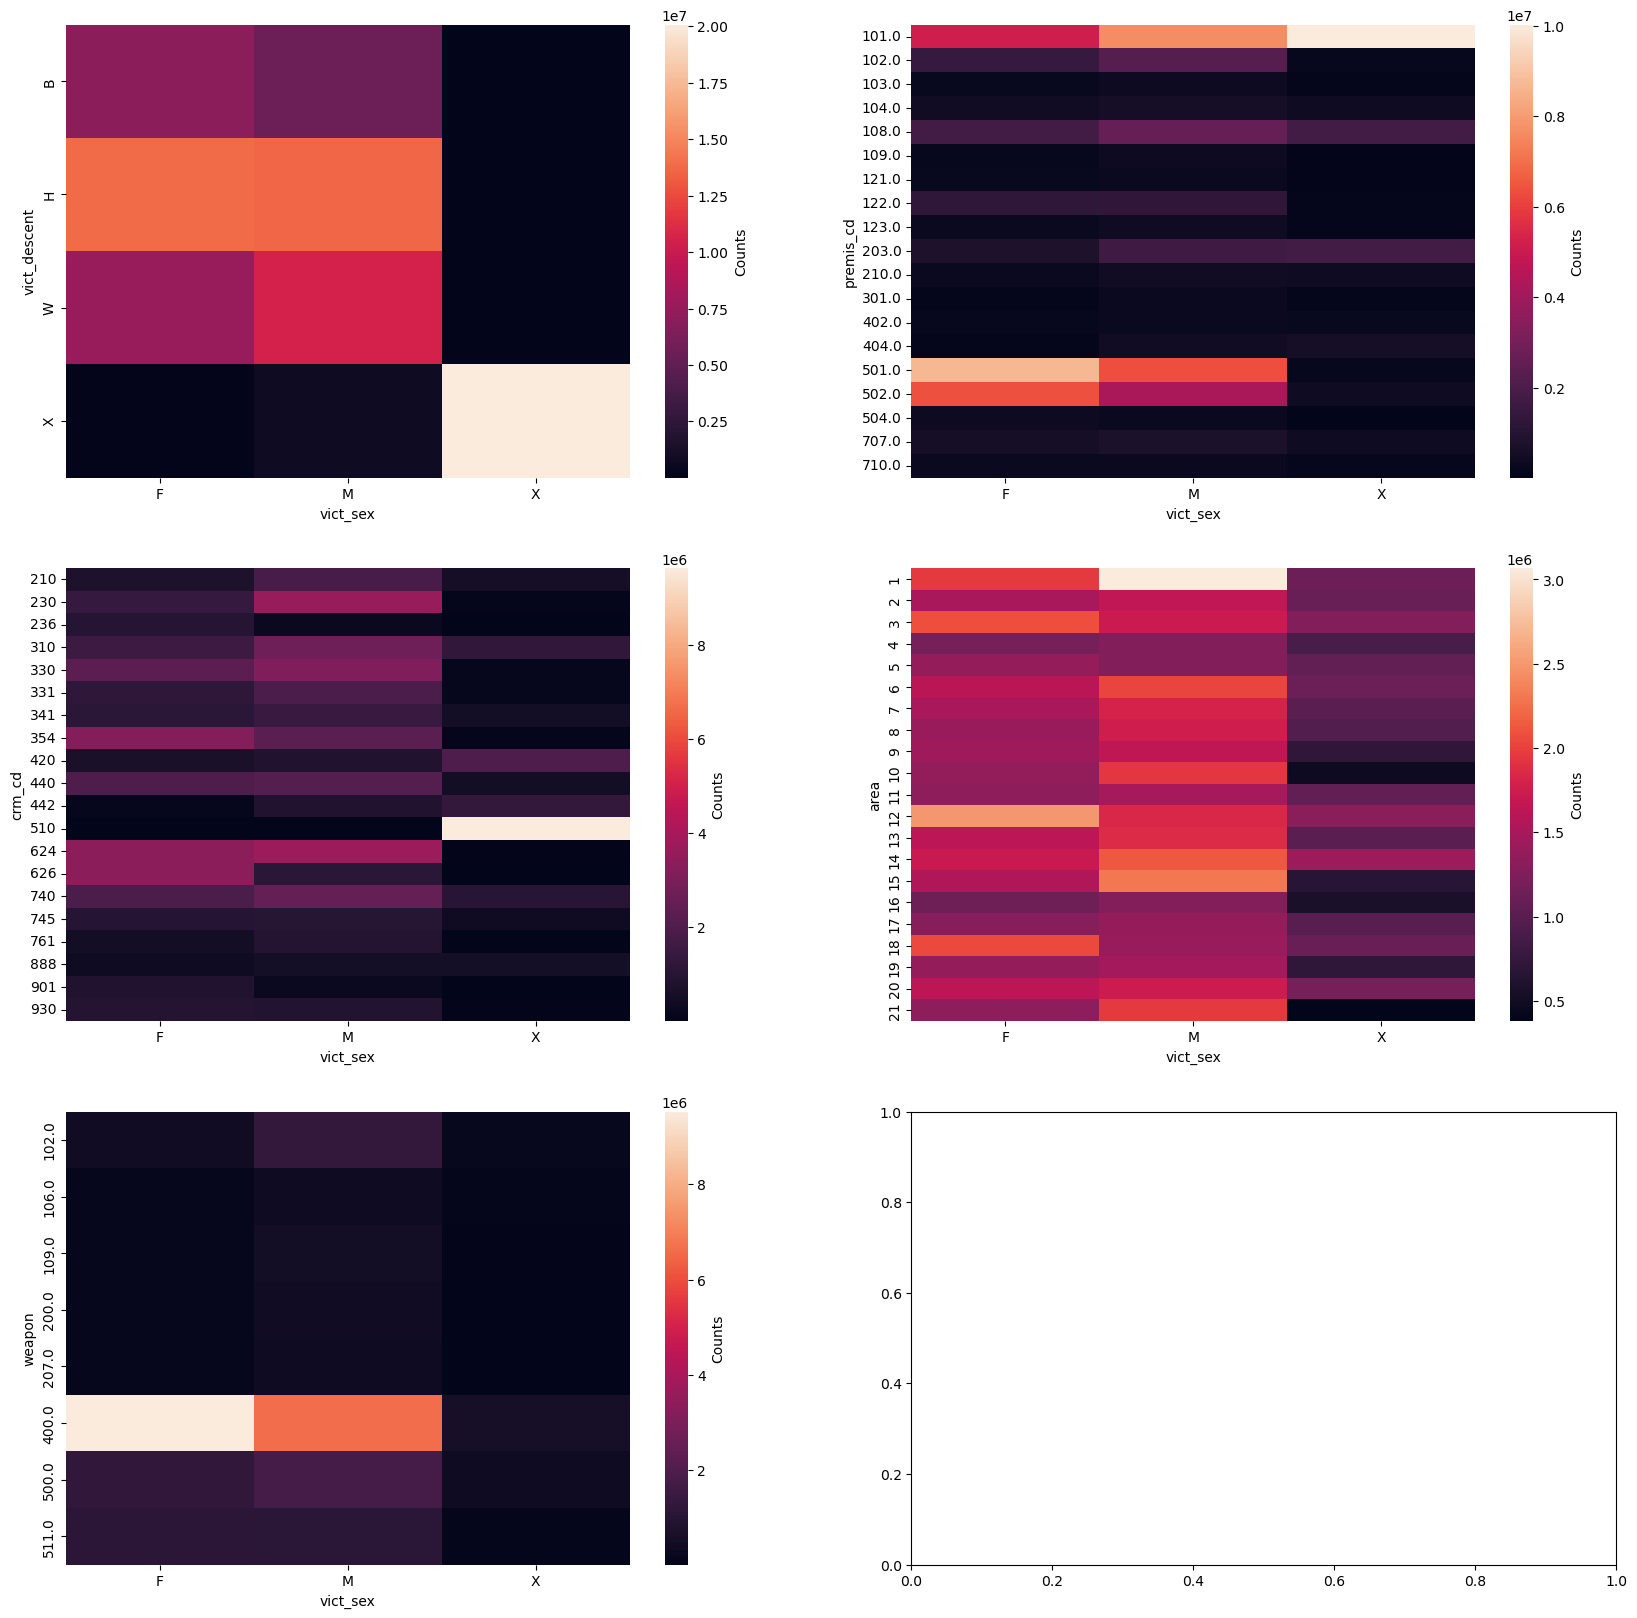

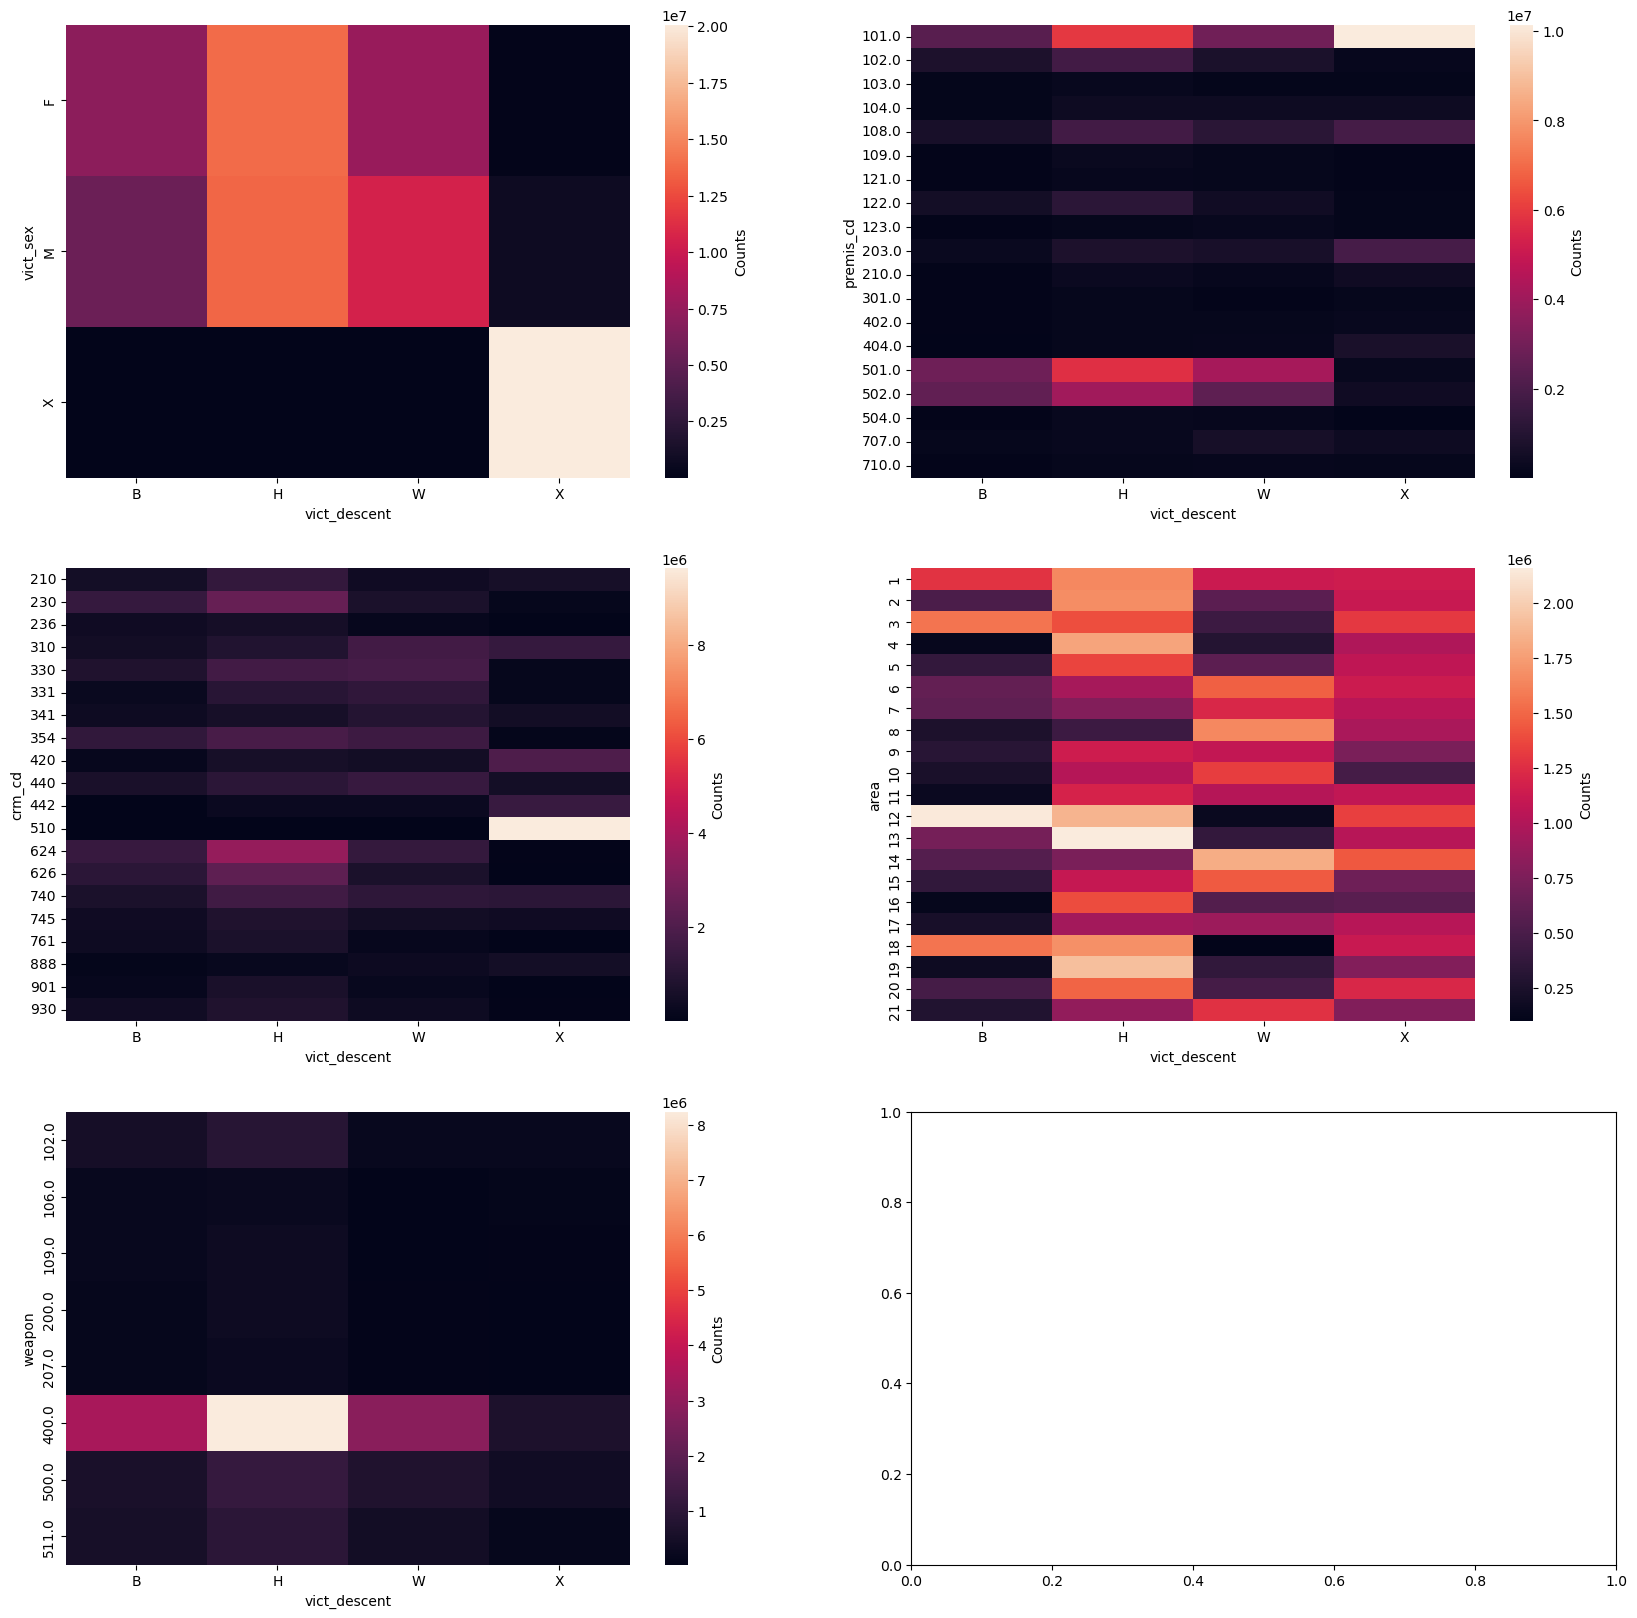

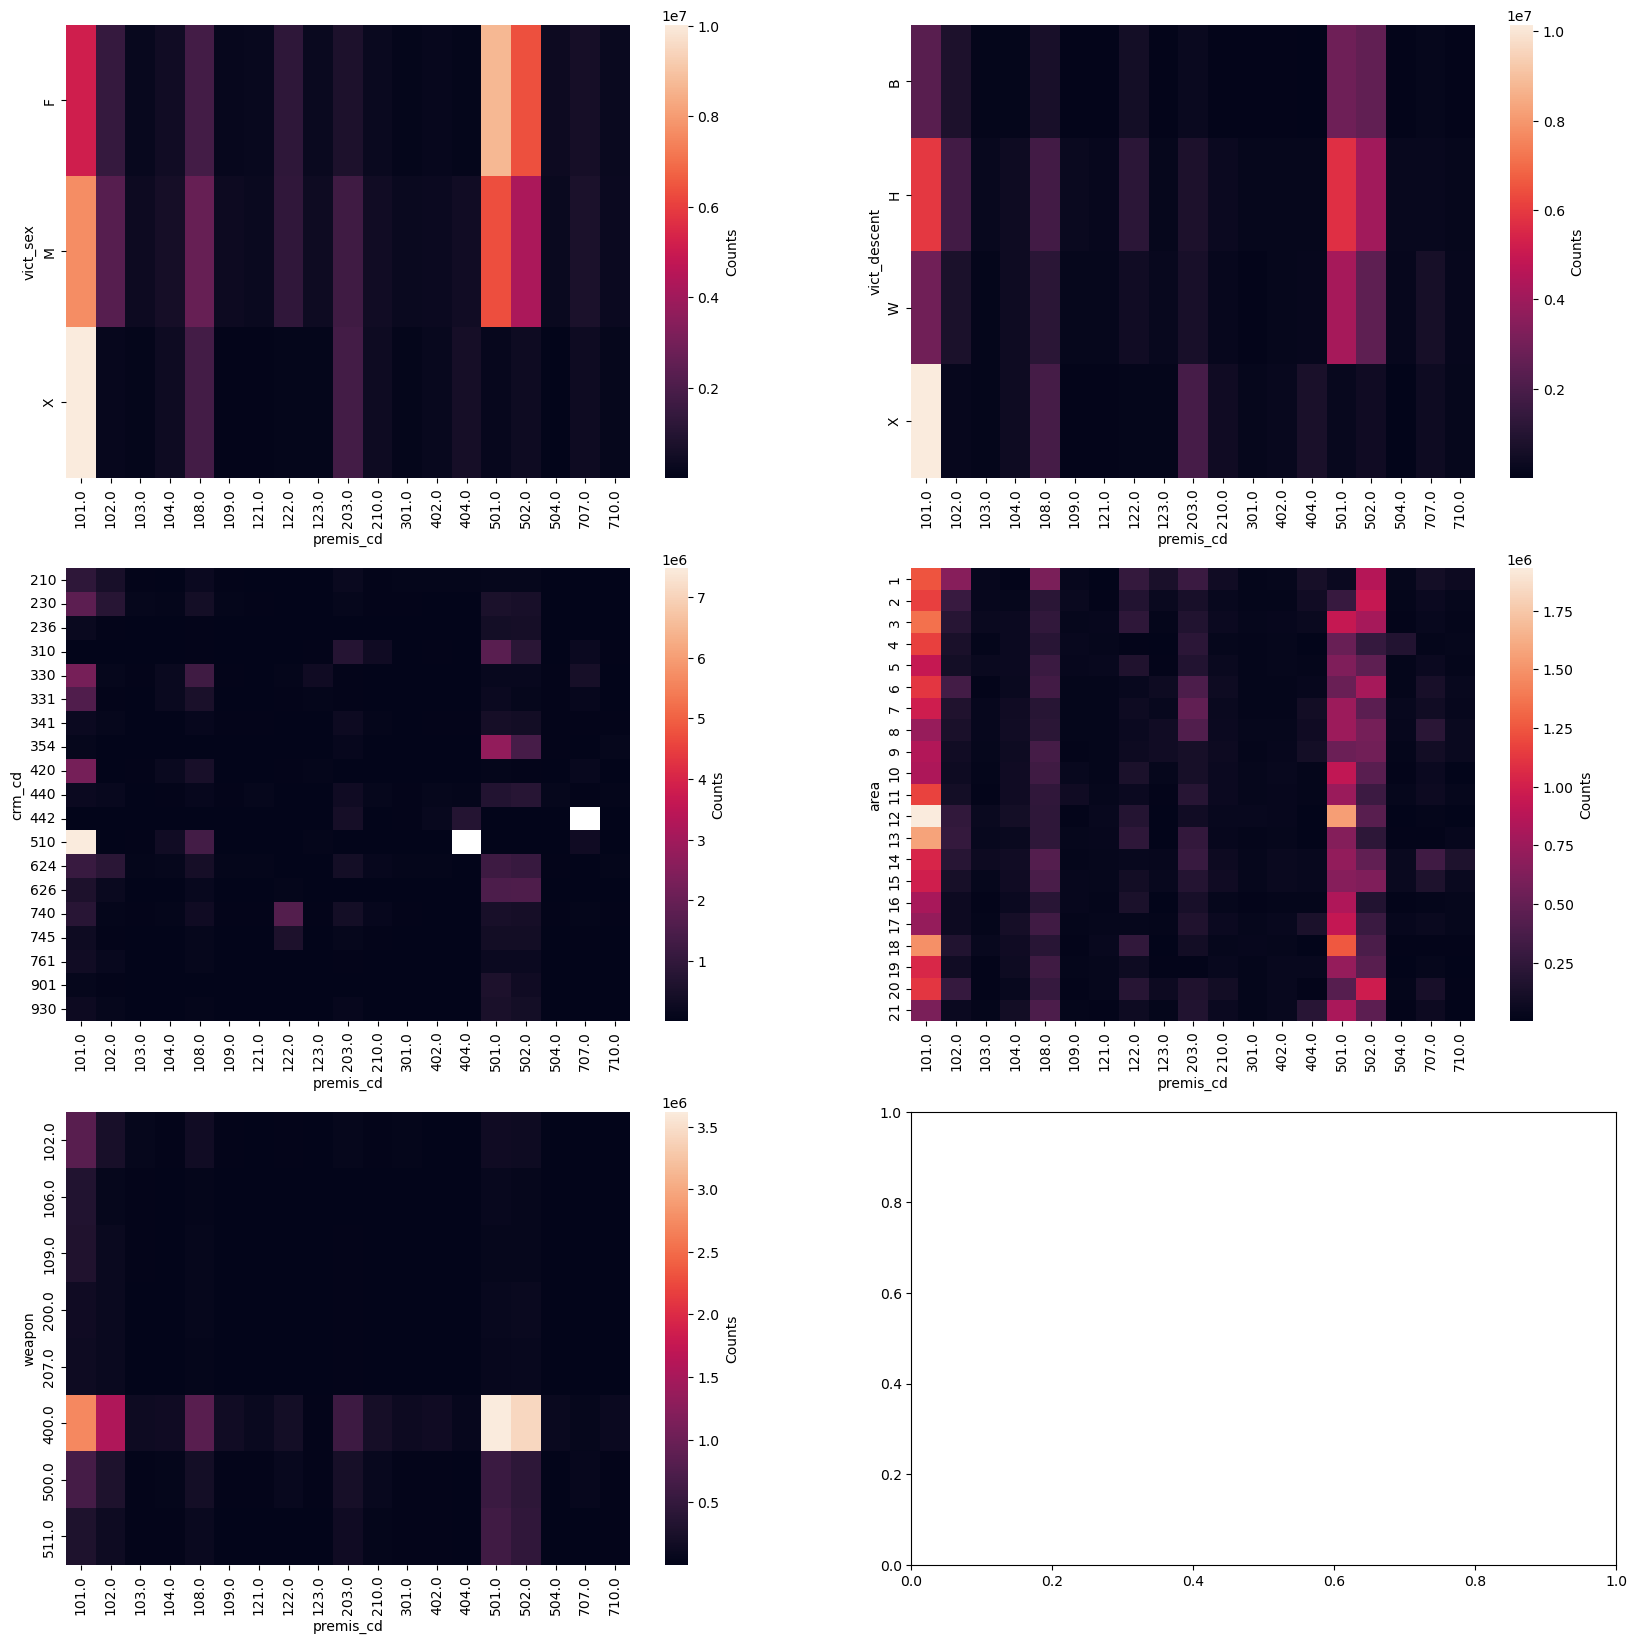

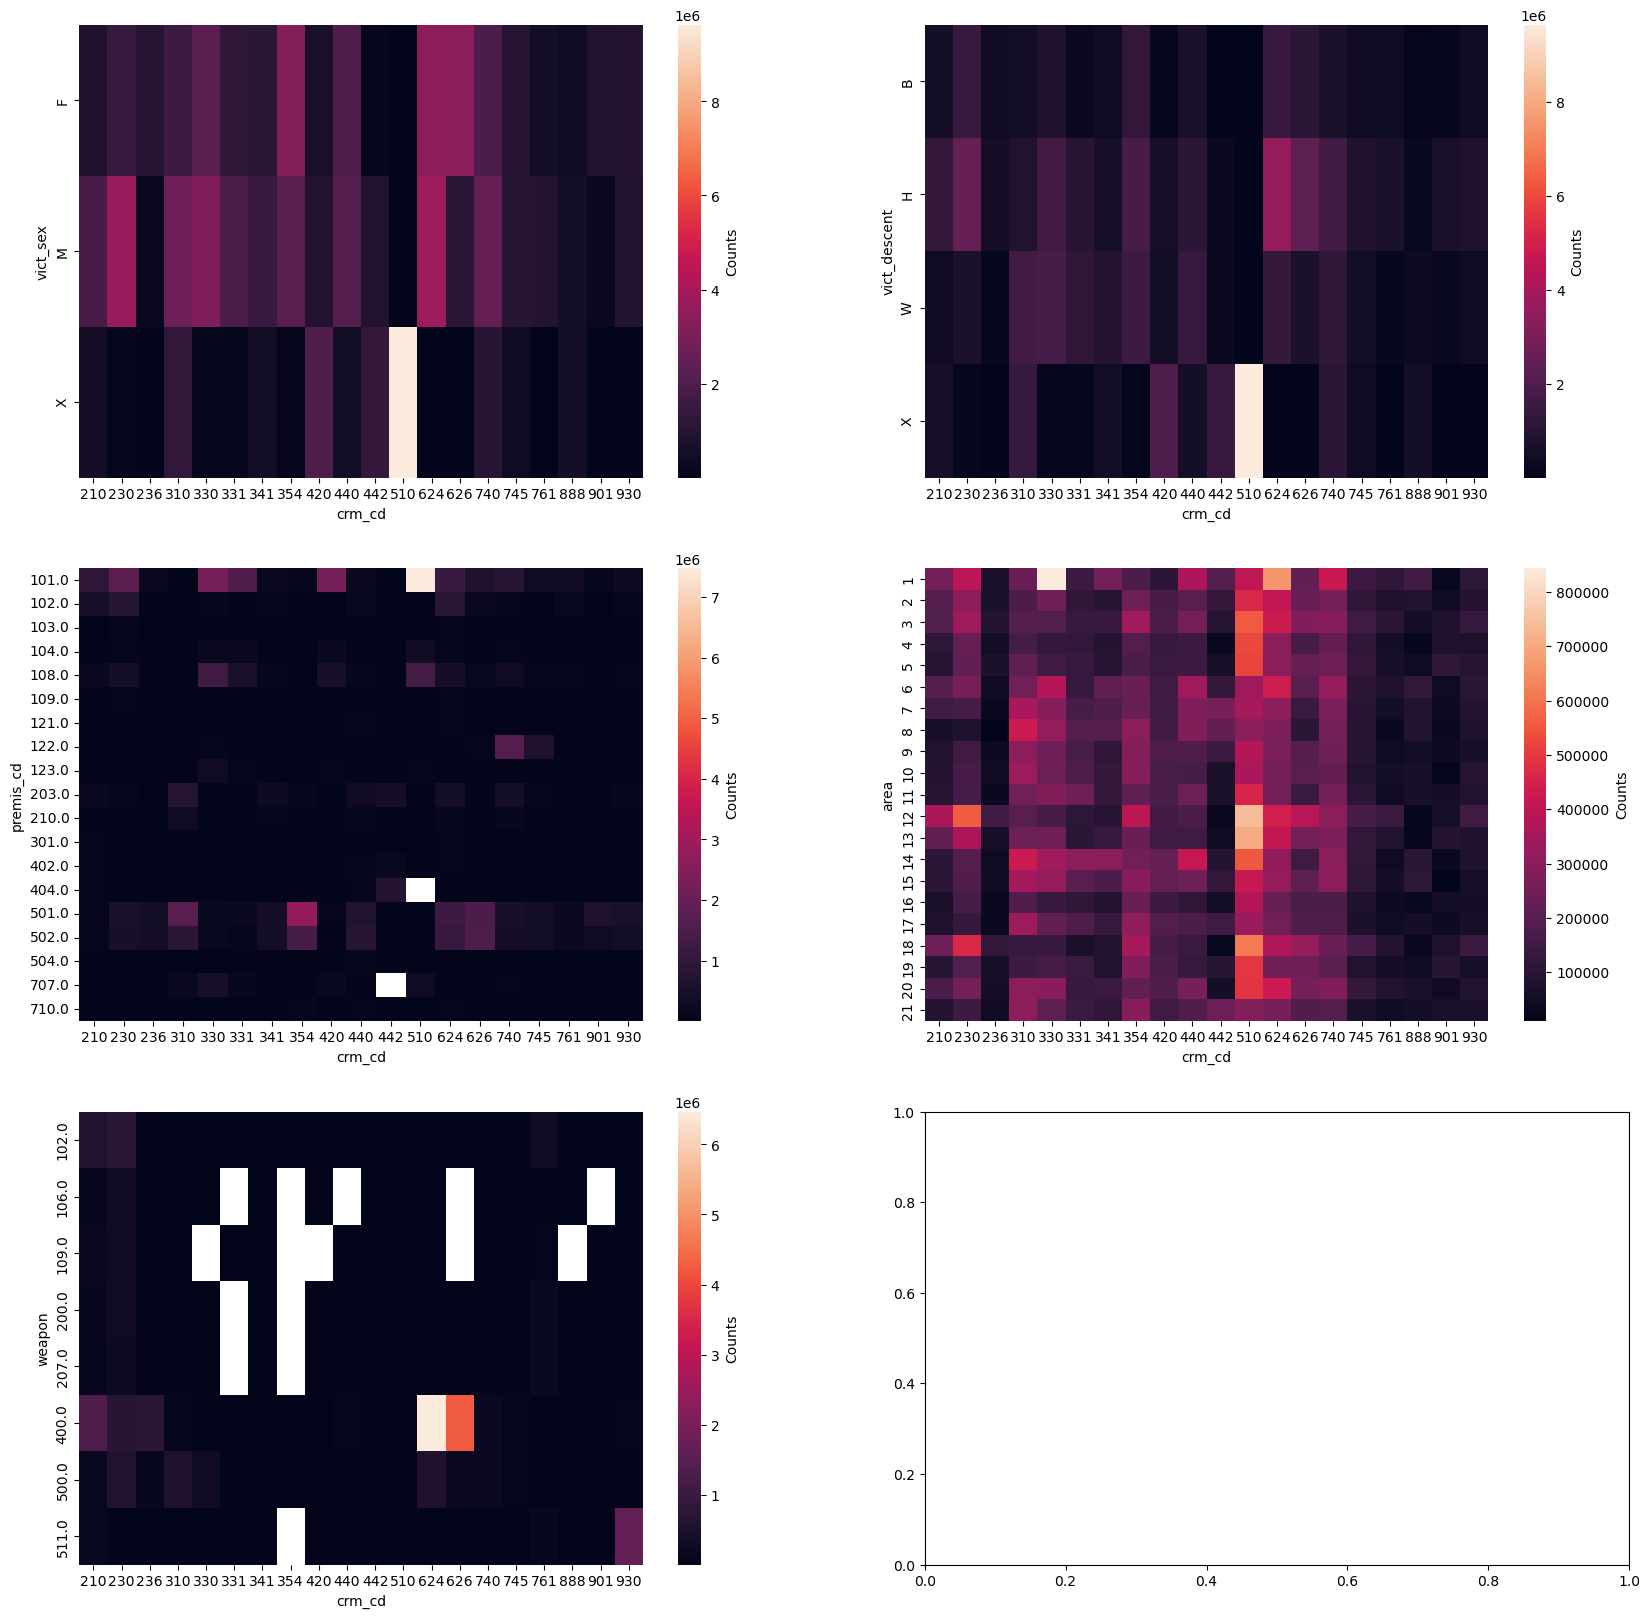

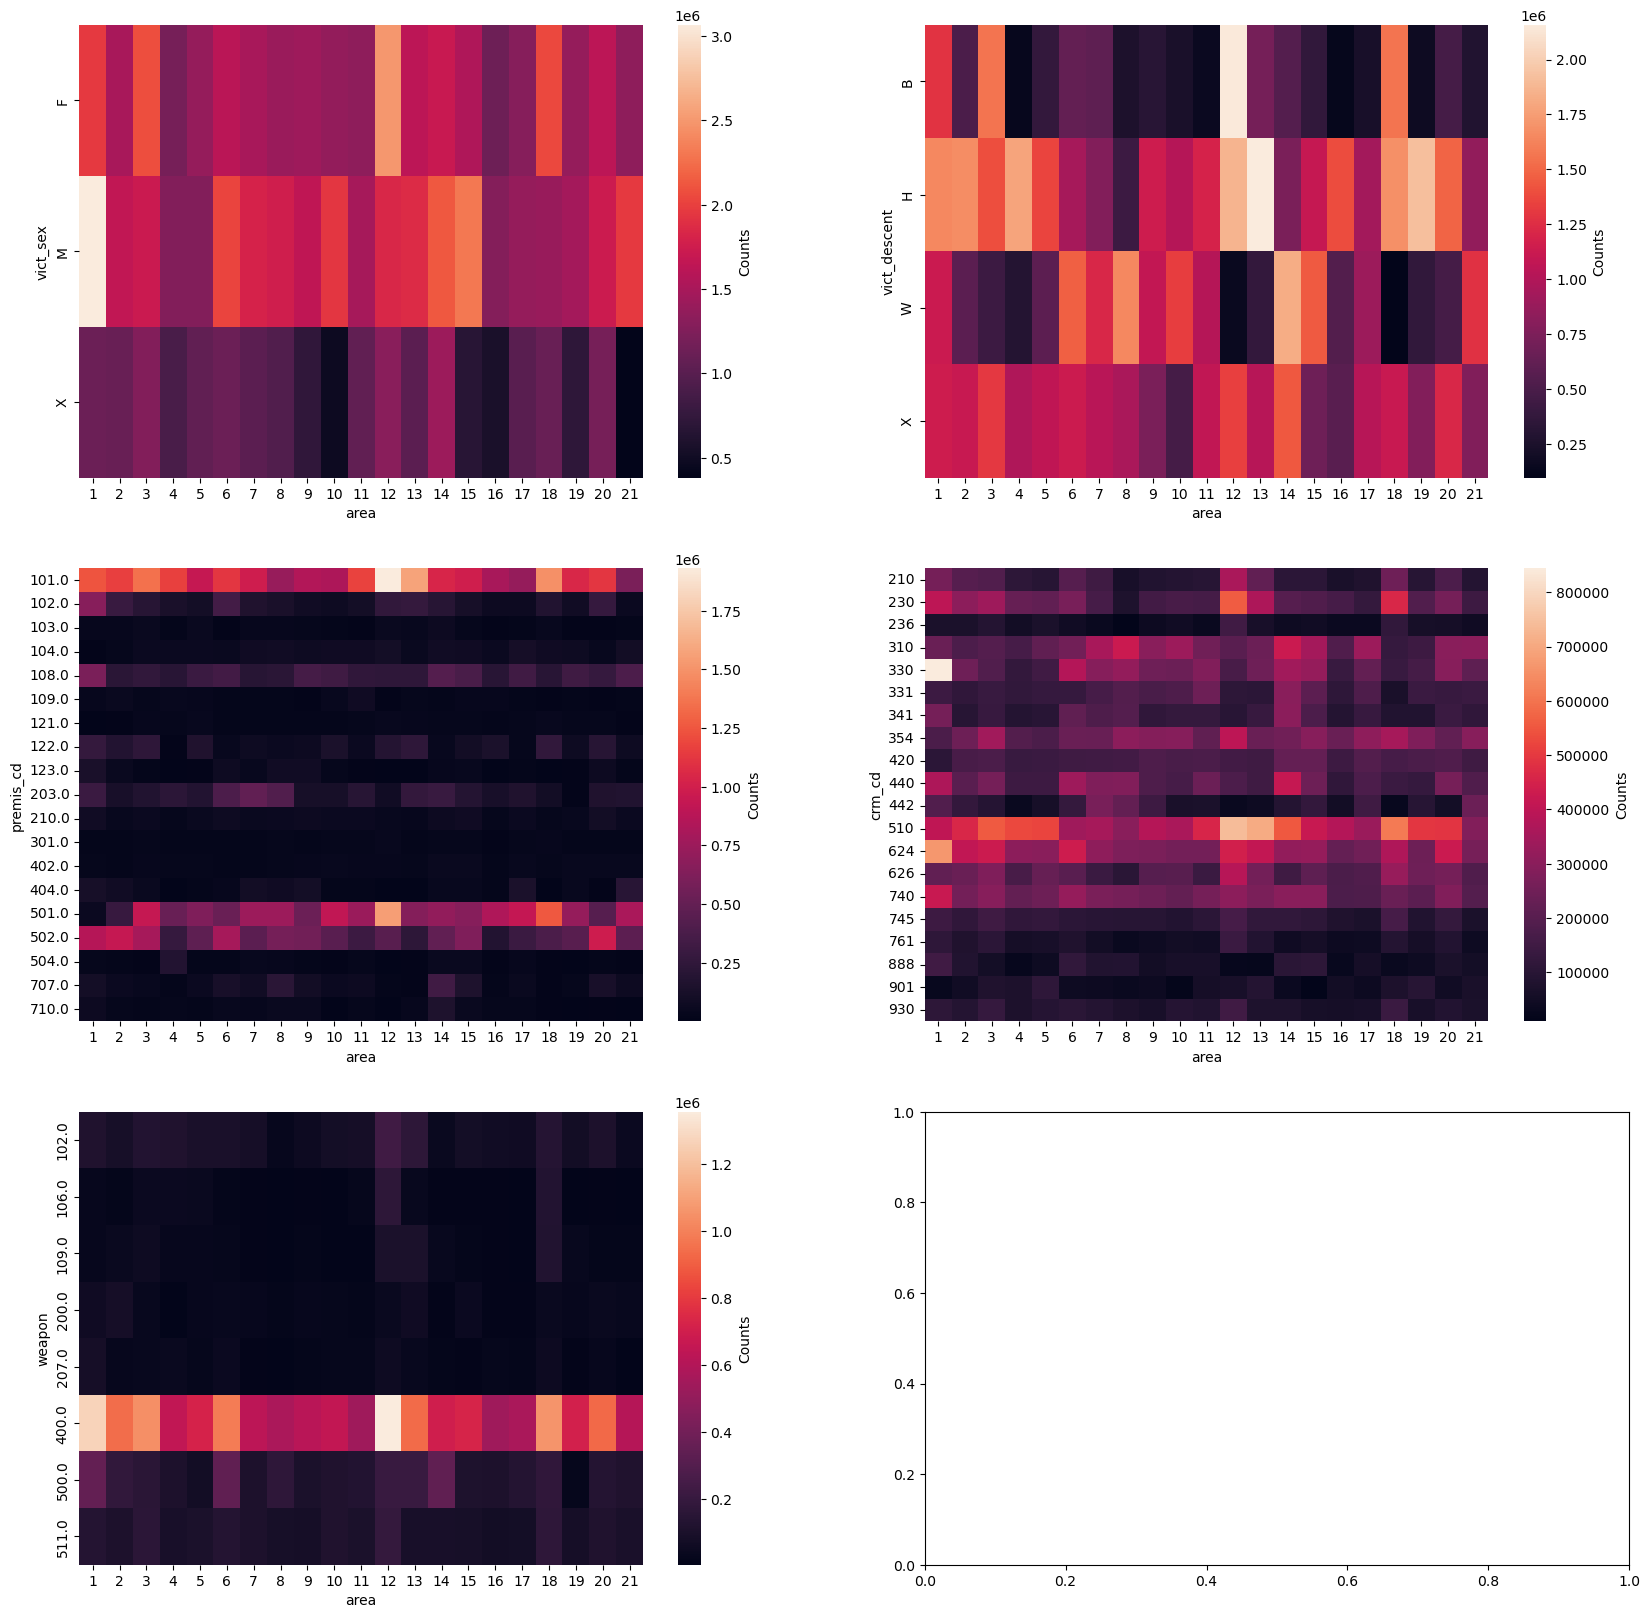

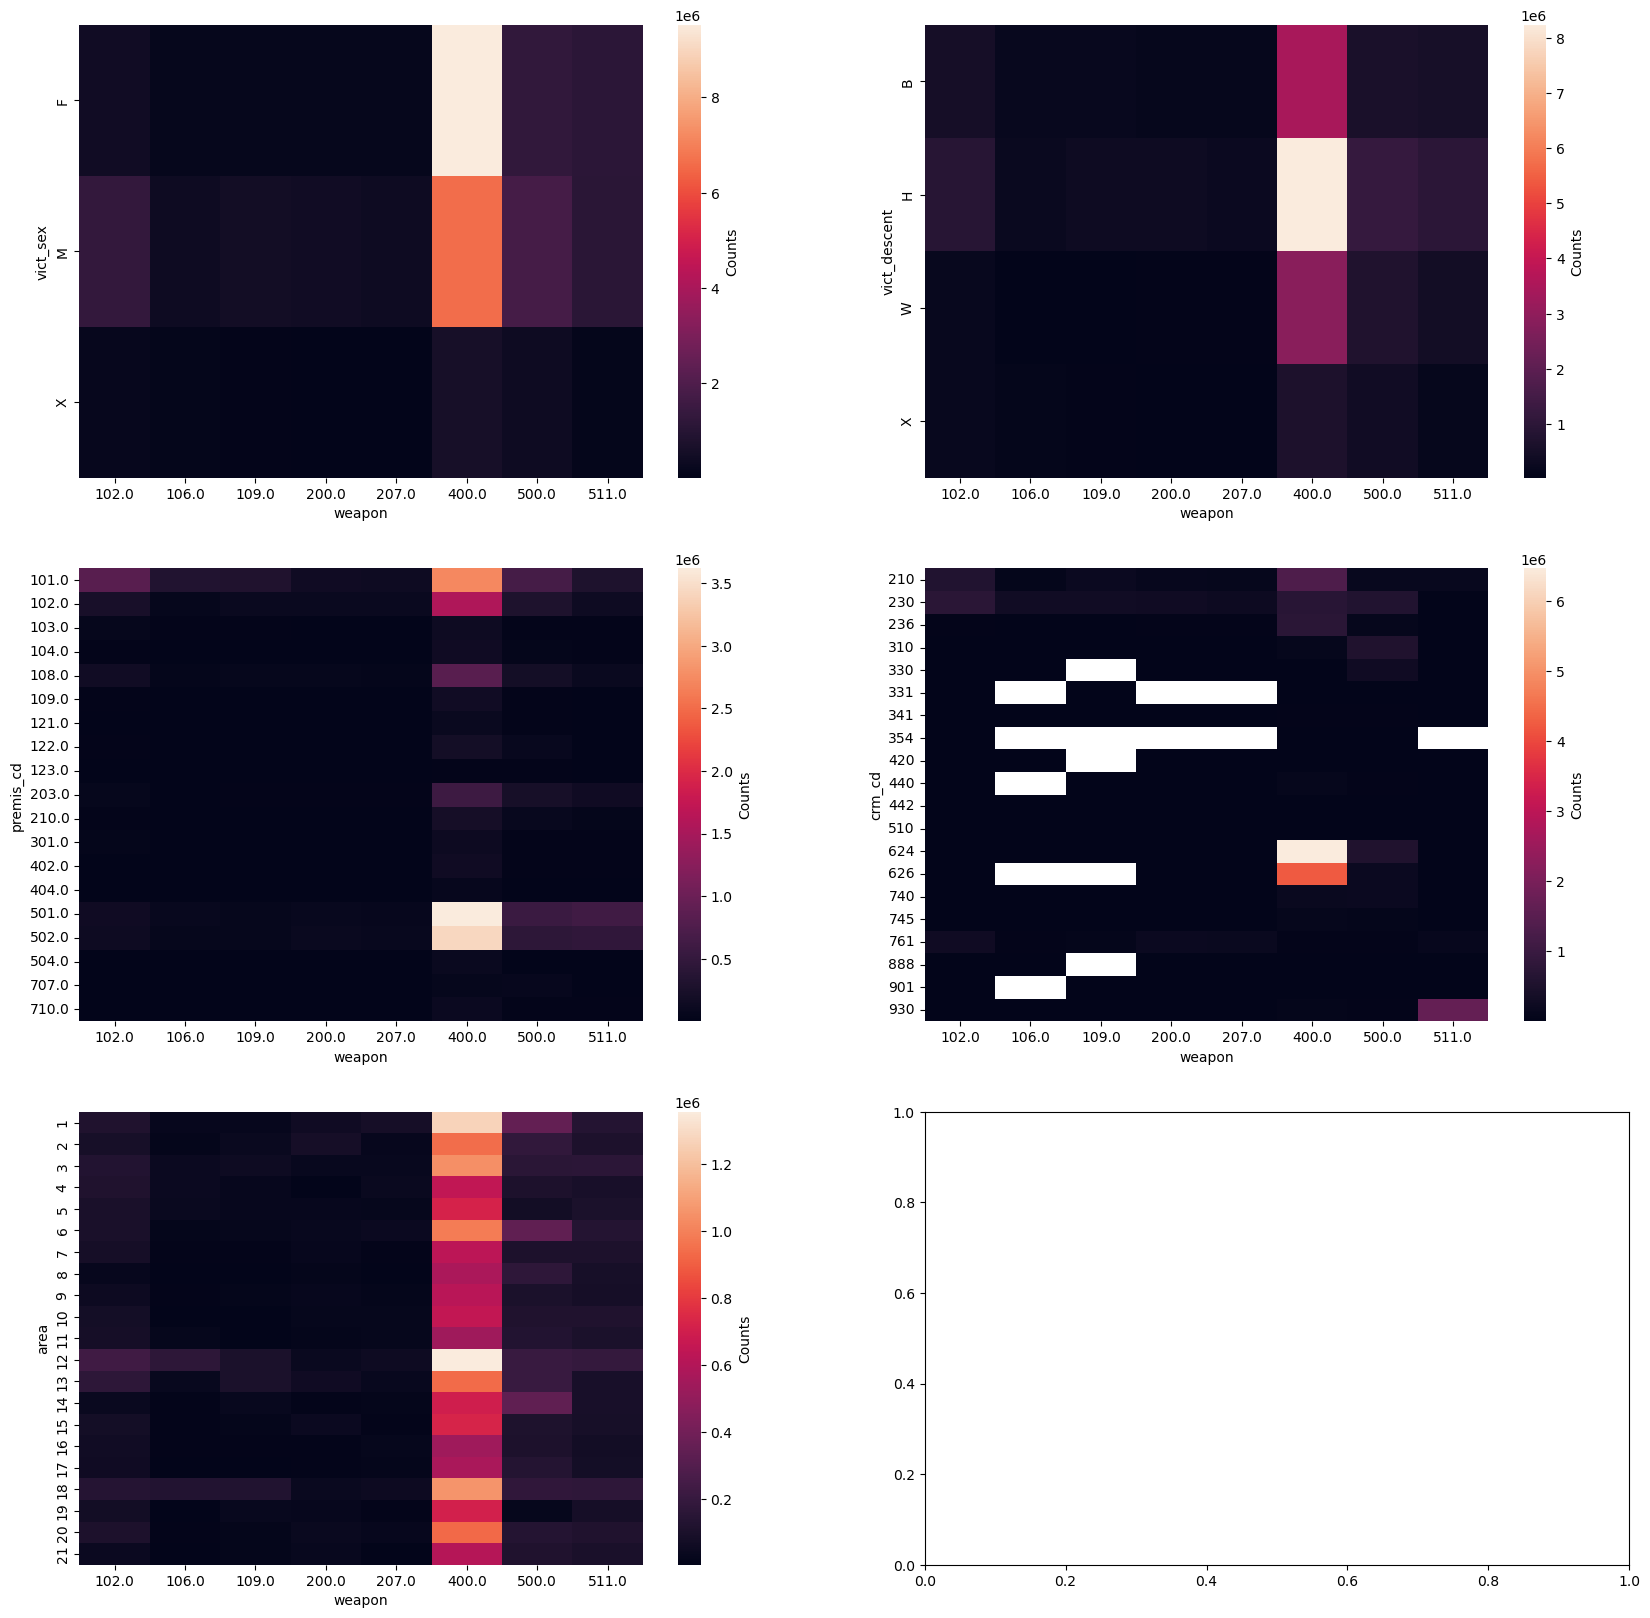

In [298]:
plotHeatmaps(data=df_complete[cat_cols], normalize=False, filterPercentage=85)

### Heatmap for each categorical feature vs other categorical features (Normalized)
Colorbar is the percentage of each combination for the feature in x-axis.

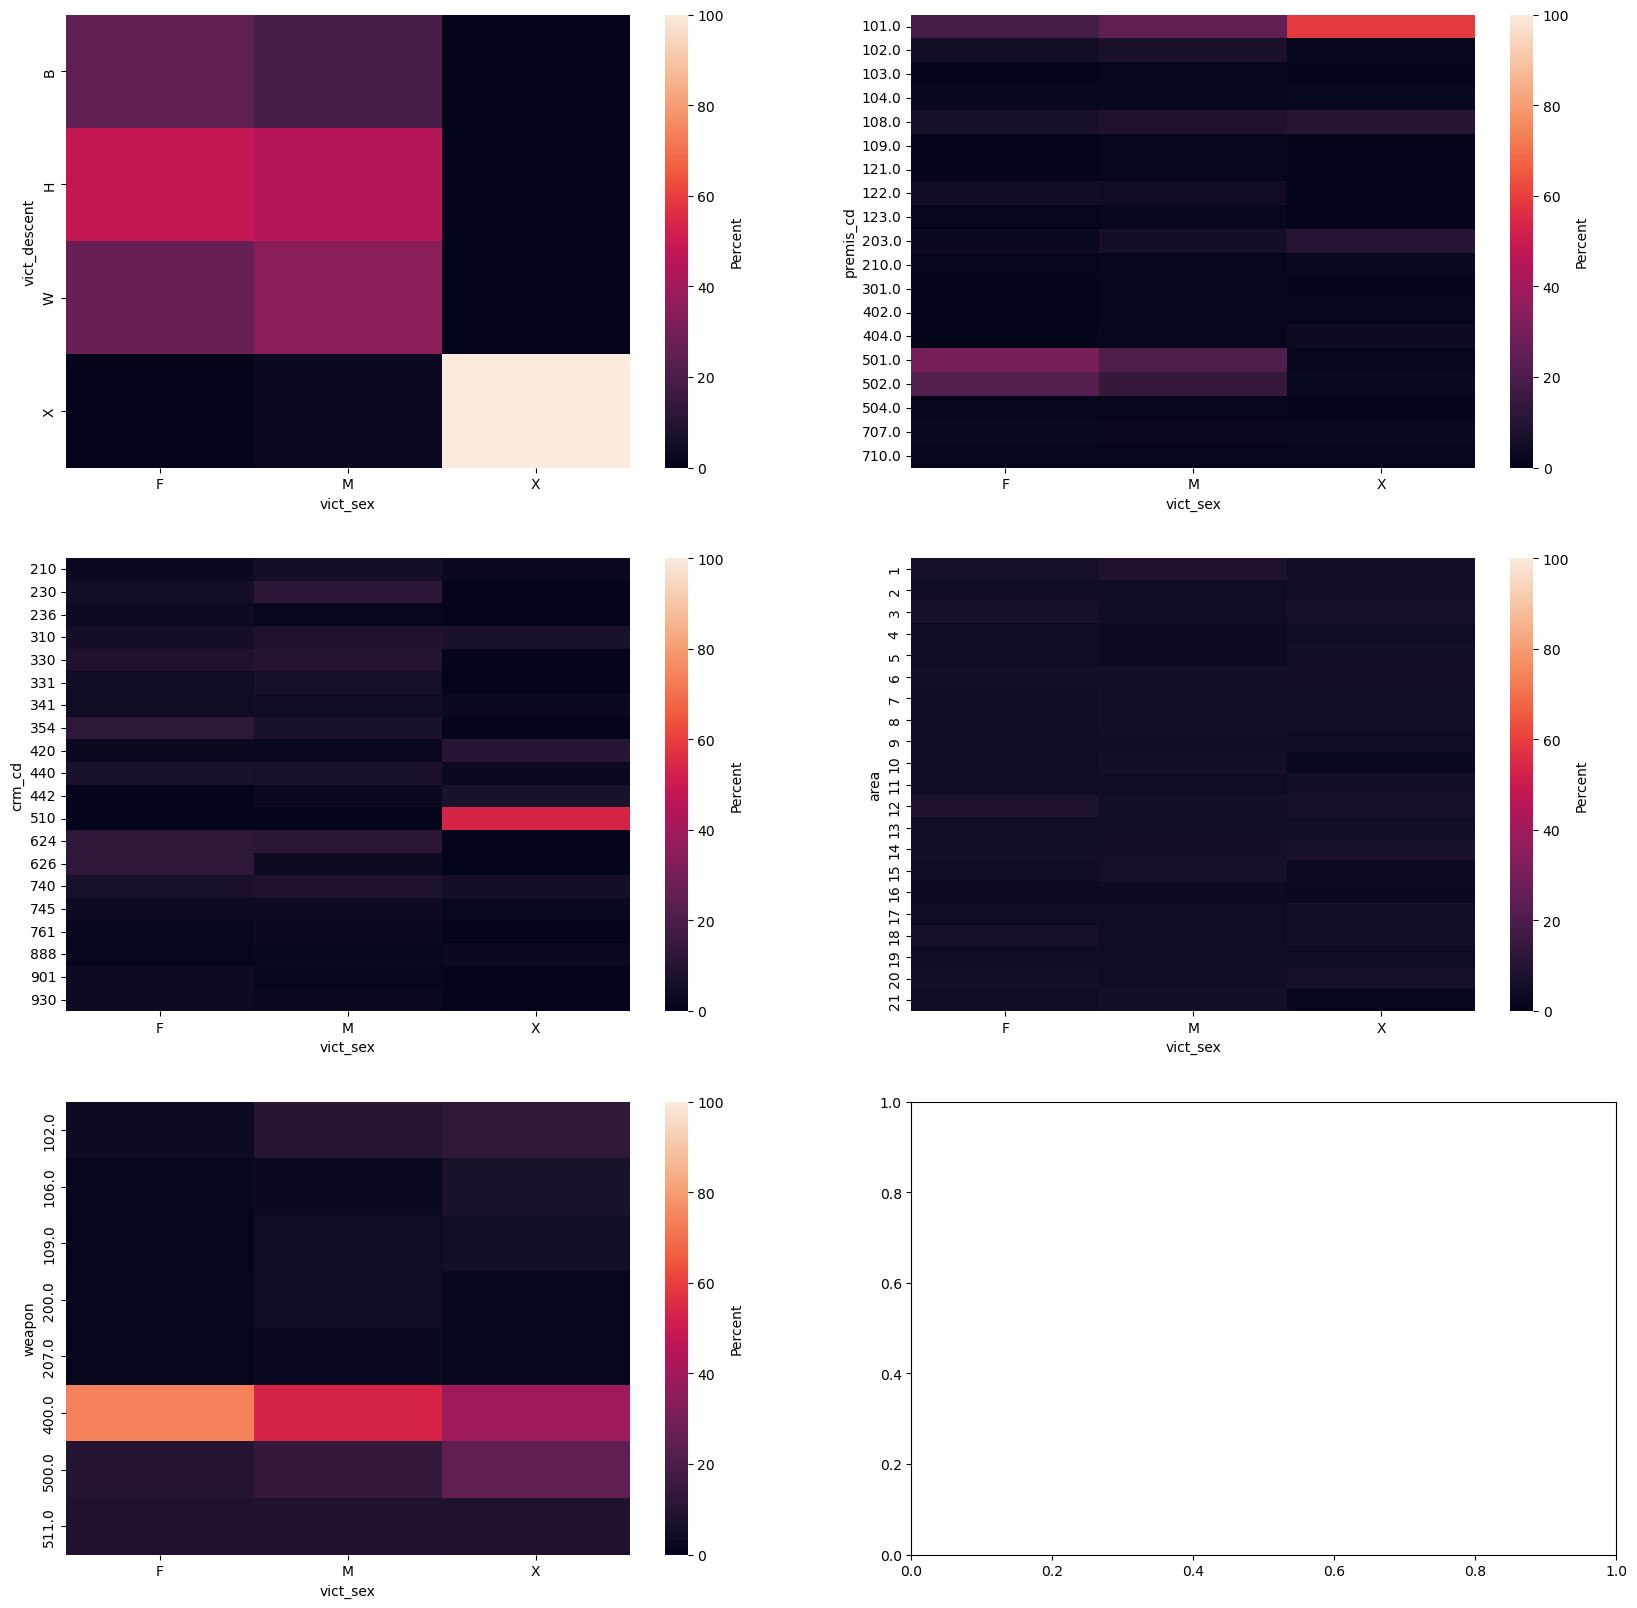

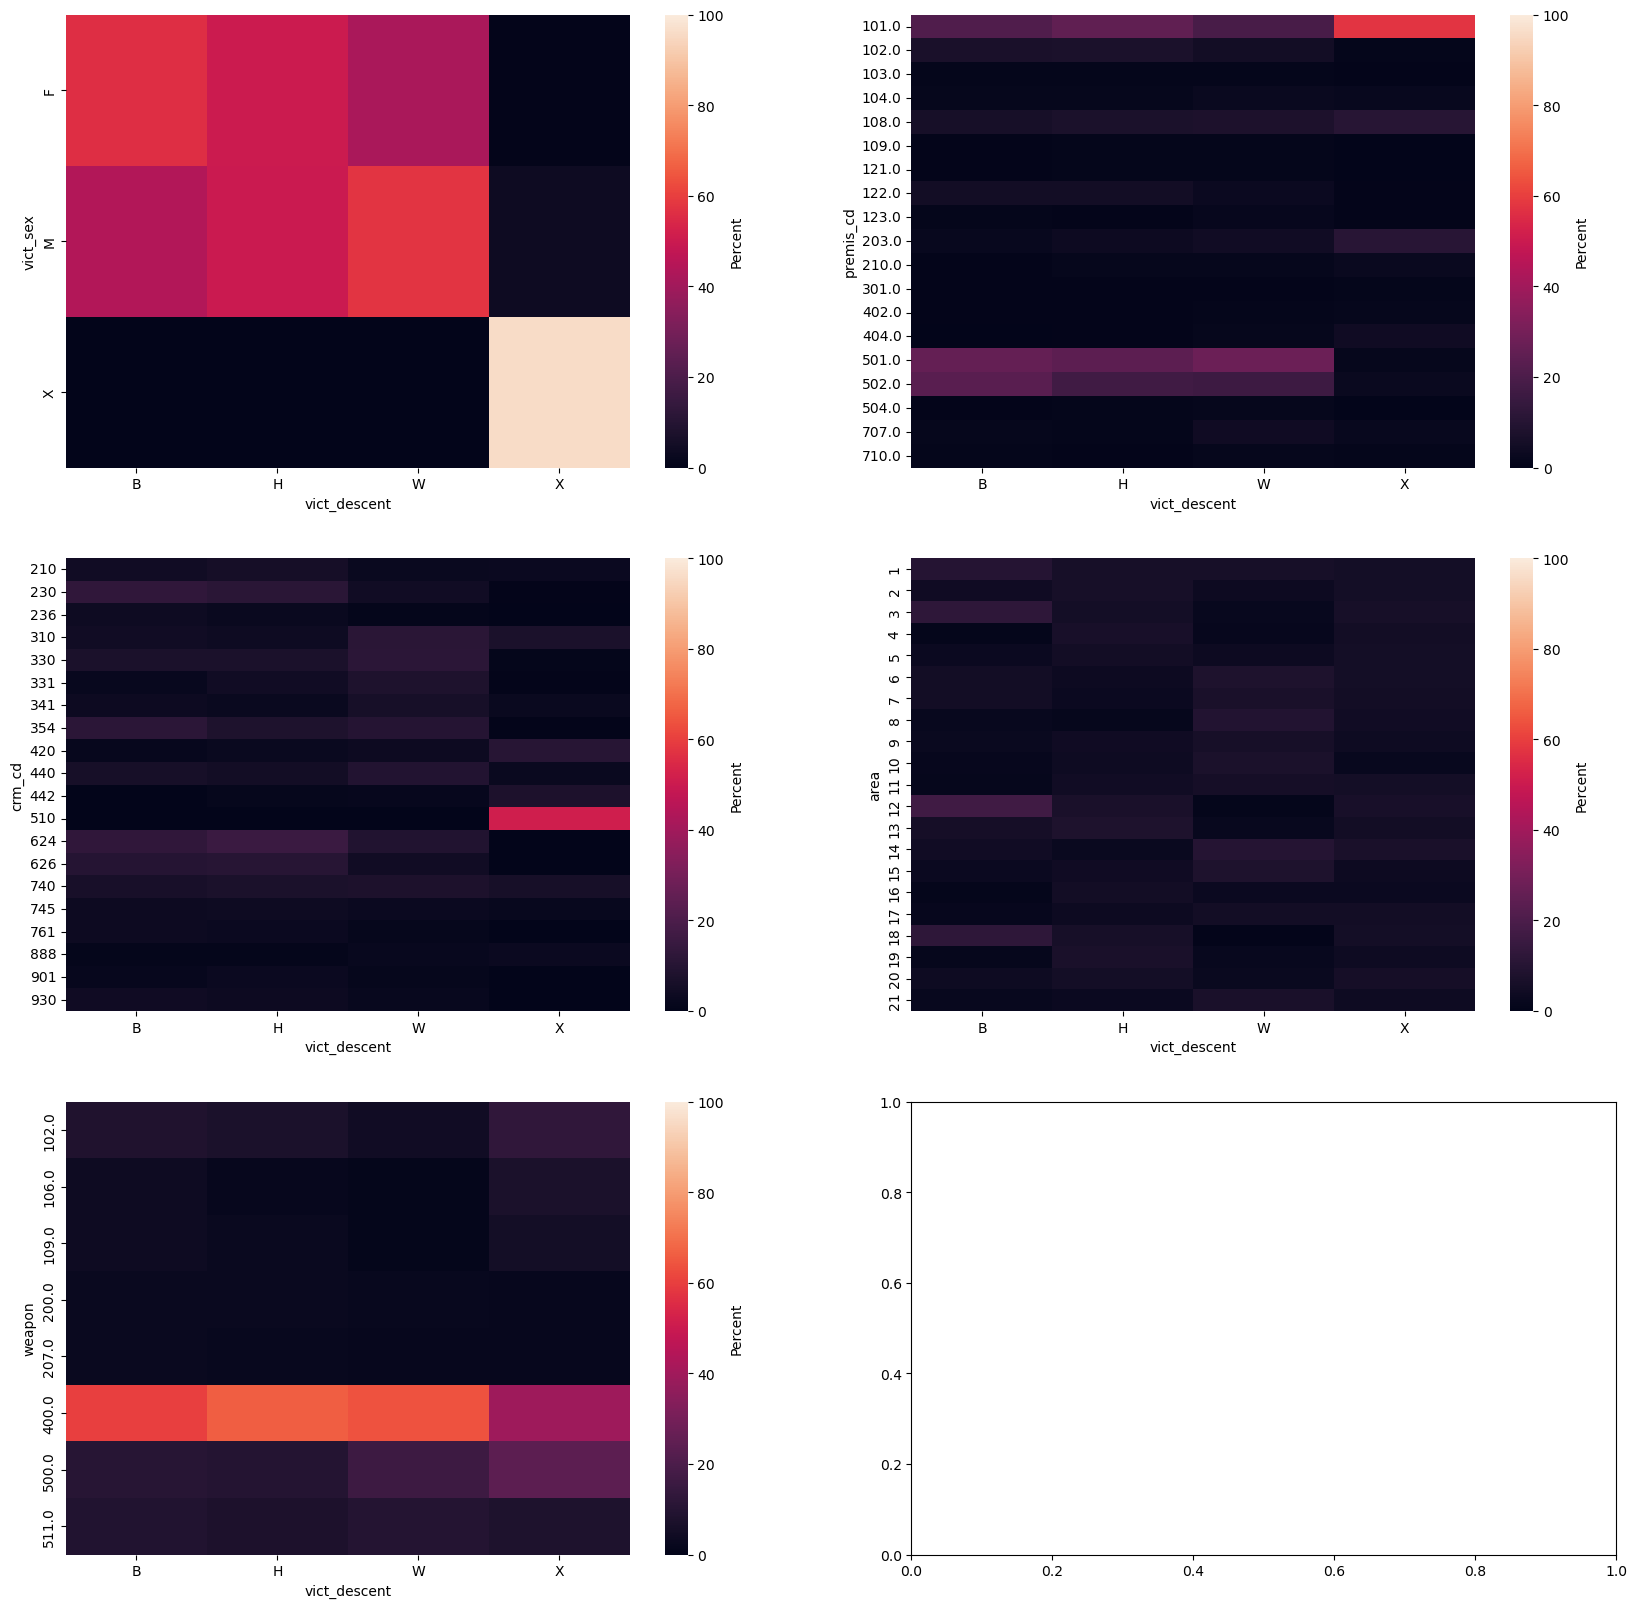

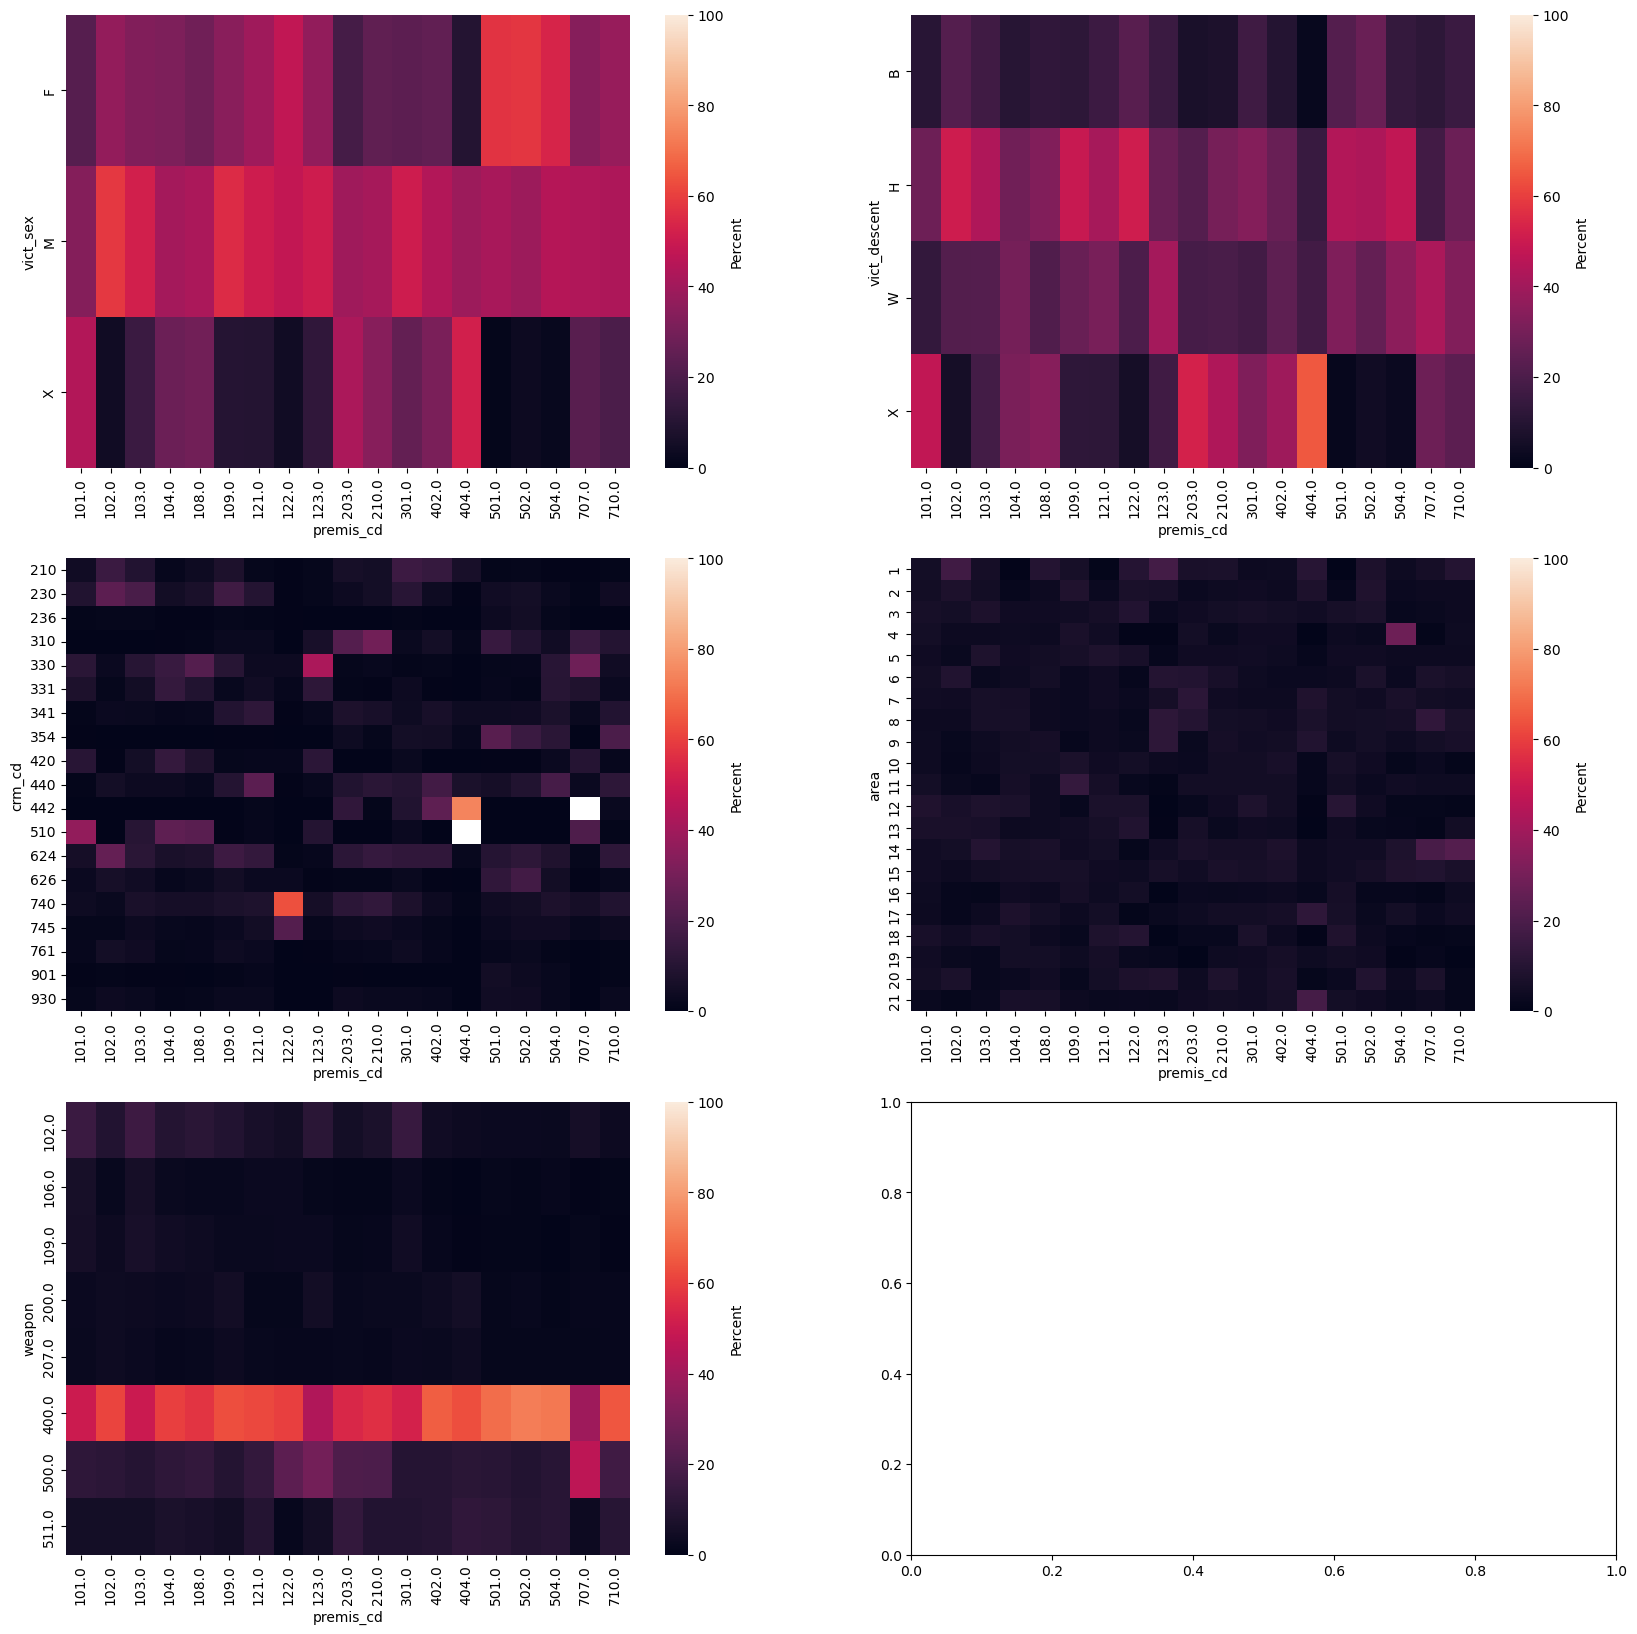

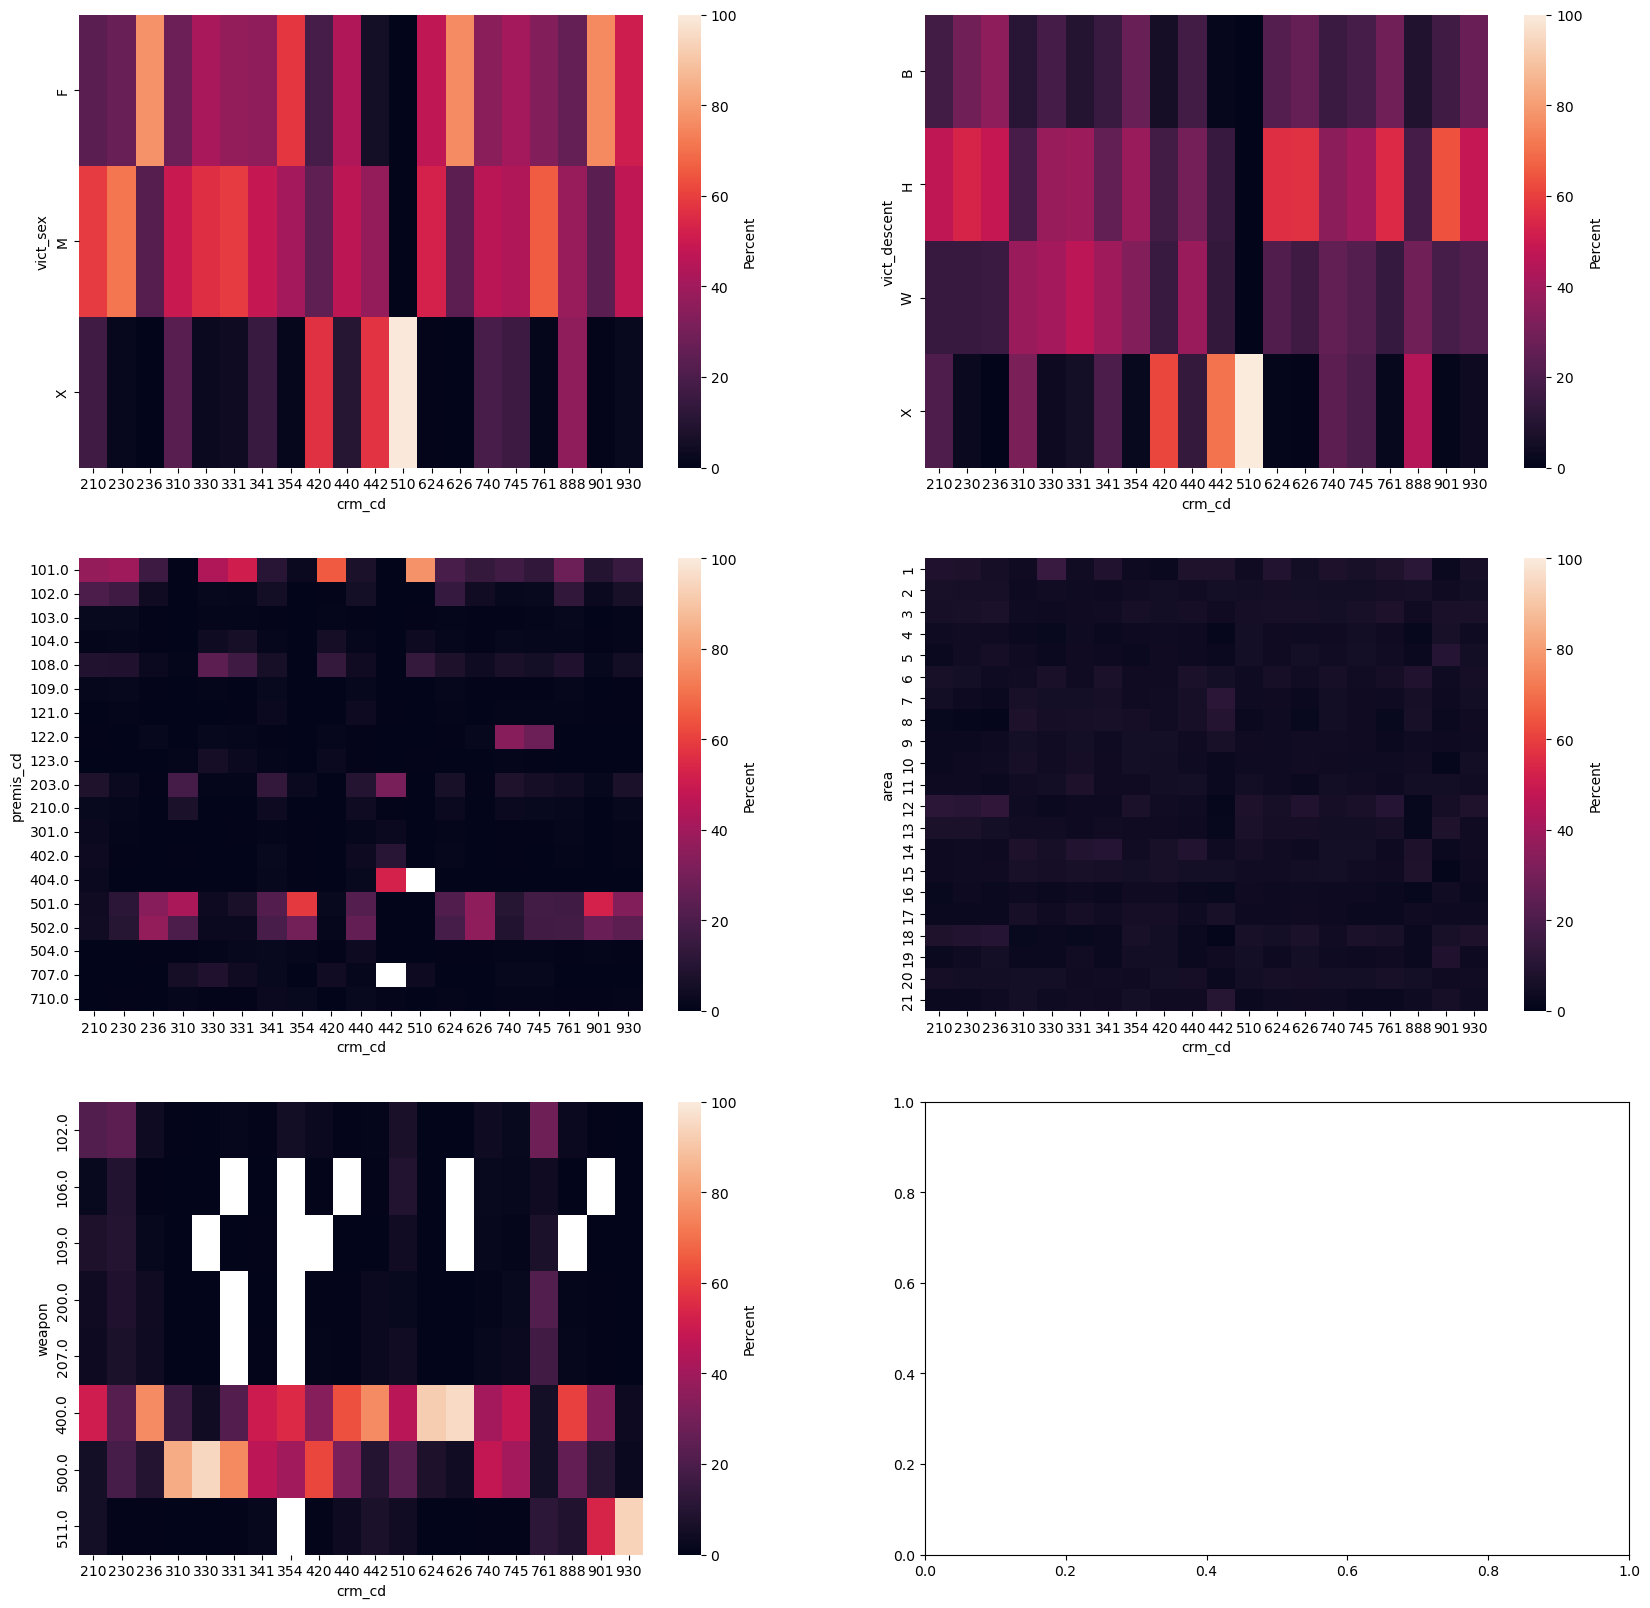

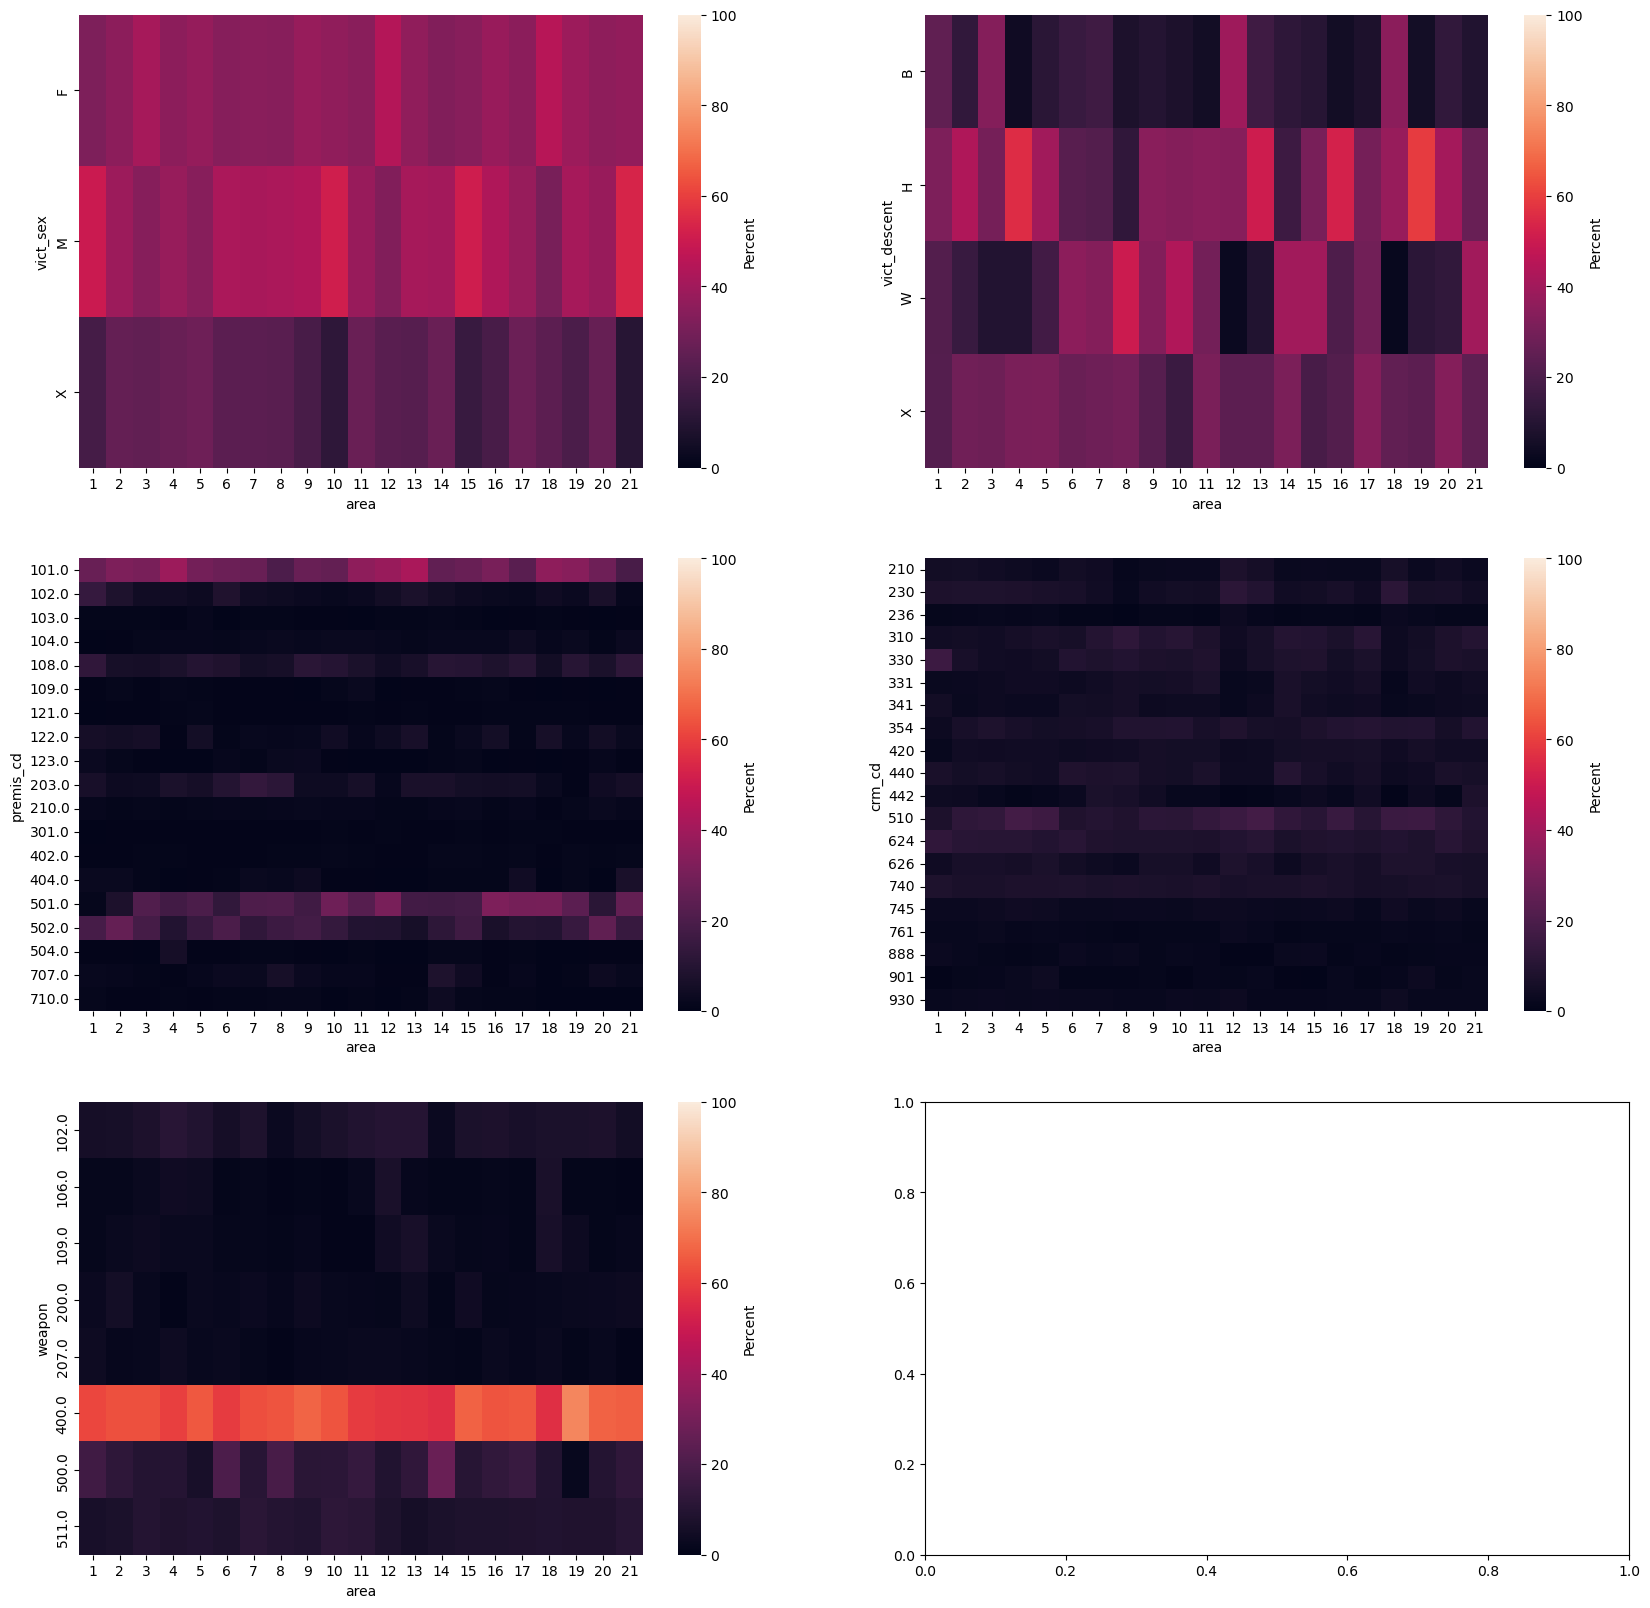

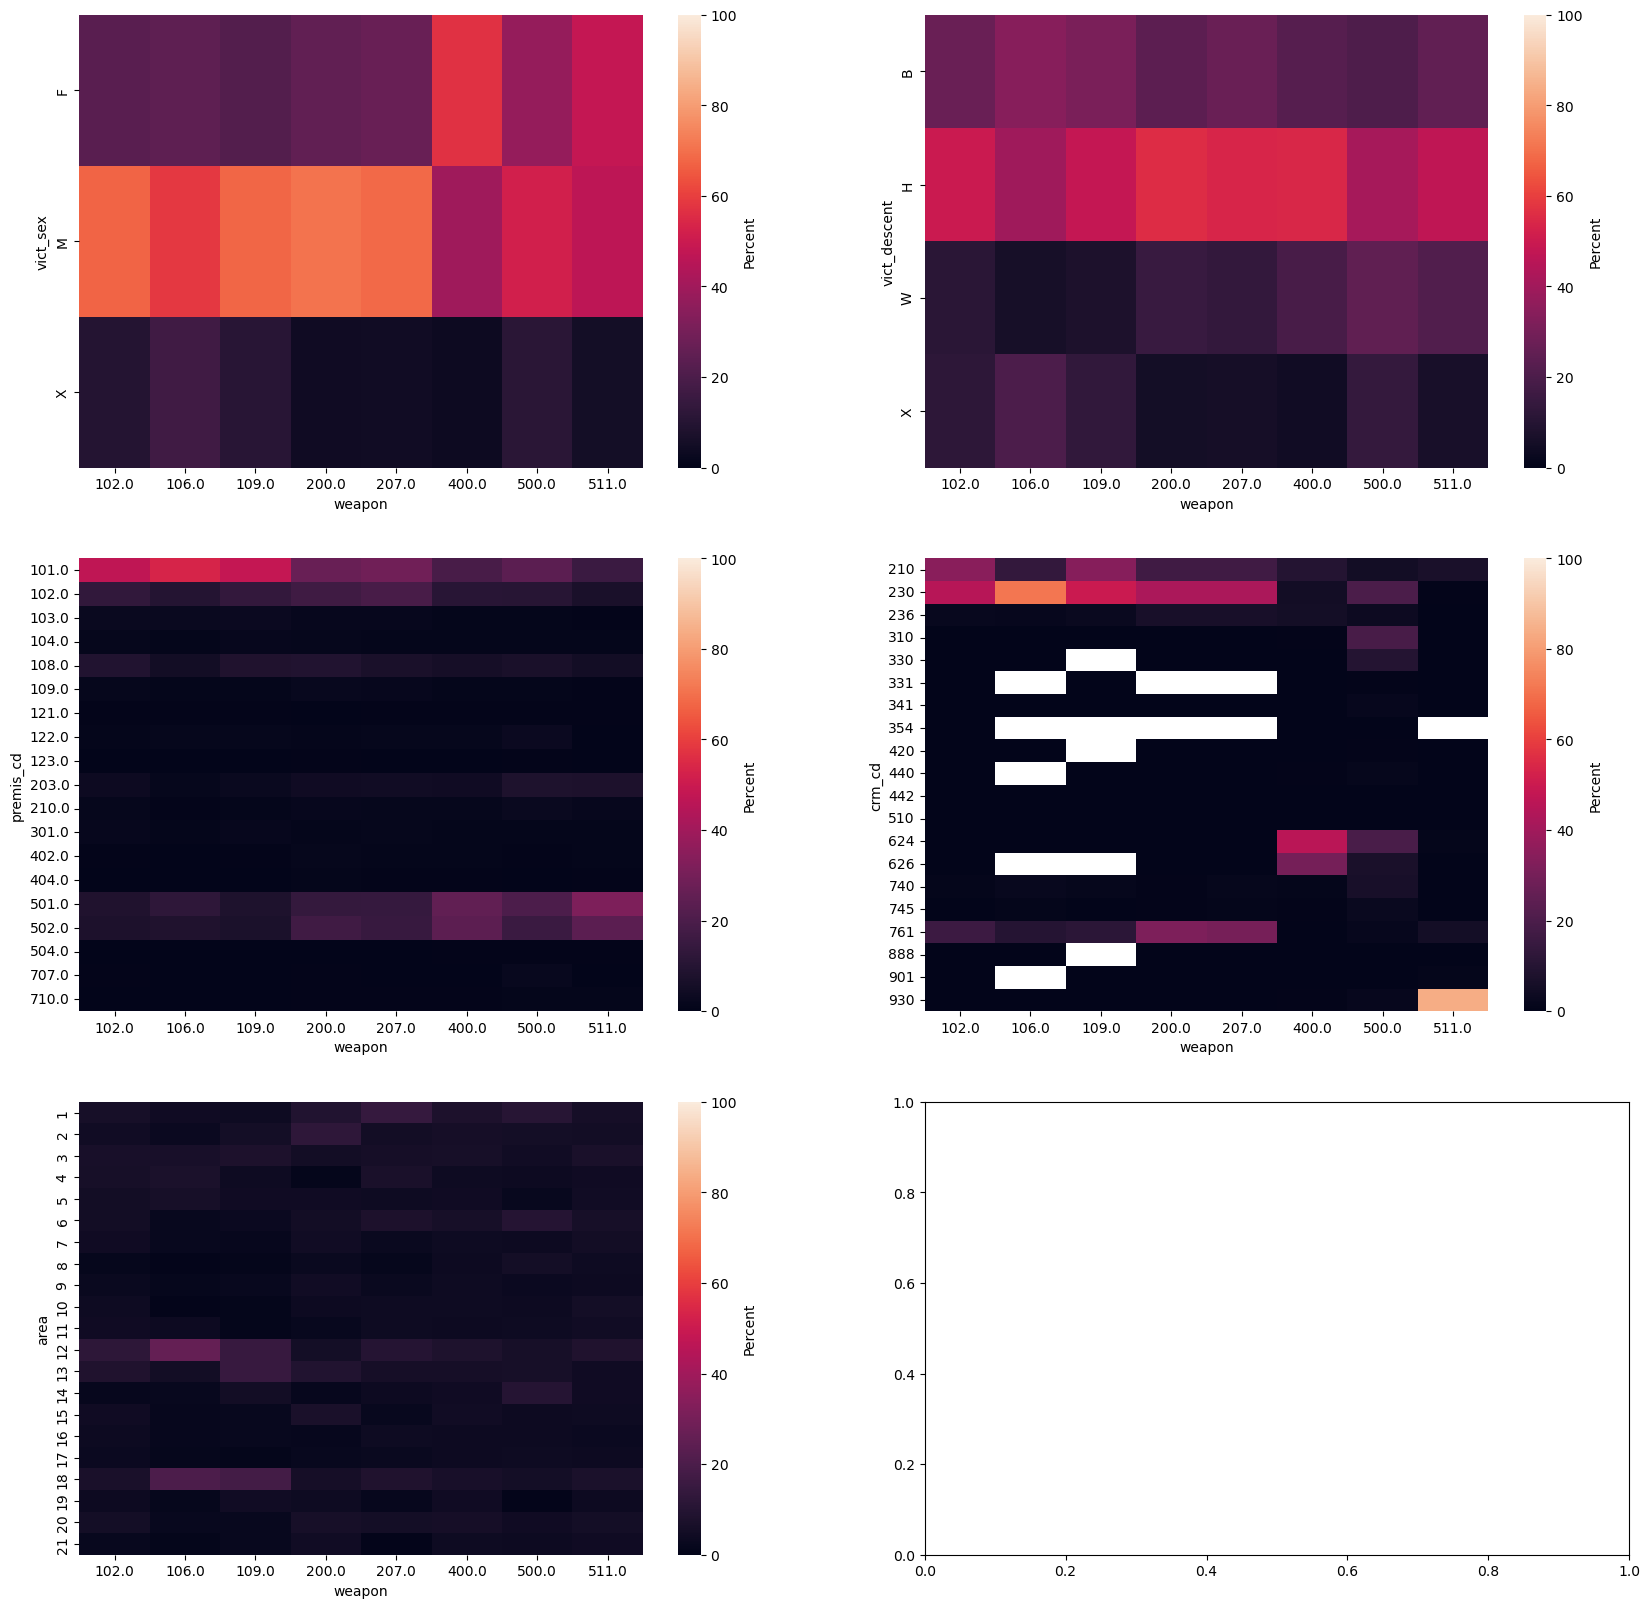

In [299]:
plotHeatmaps(data=df_complete[cat_cols], normalize=True, filterPercentage=85)

# Getting the meaning of codes in features

In [300]:
crm_codes = df['crm_cd'].unique().tolist()
df_filtered = data.loc[data['Crm Cd'].isin(crm_codes), ['Crm Cd', 'Crm Cd Desc']]
crm_code_meaning = df_filtered.groupby('Crm Cd').first().reset_index()
crm_code_meaning.set_index('Crm Cd')

Crm Cd Desc
Crm Cd                                                   
110                                     CRIMINAL HOMICIDE
113                               MANSLAUGHTER, NEGLIGENT
121                                        RAPE, FORCIBLE
122                                       RAPE, ATTEMPTED
210                                               ROBBERY
...                                                   ...
949                                       ILLEGAL DUMPING
950     DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $...
951     DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 &...
954                                          CONTRIBUTING
956               LETTERS, LEWD  -  TELEPHONE CALLS, LEWD

[137 rows x 1 columns]

In [301]:
premis_codes = df['premis_cd'].unique().tolist()
df_filtered = data.loc[data['Premis Cd'].isin(premis_codes), ['Premis Cd', 'Premis Desc']]
premis_code_meaning = df_filtered.groupby('Premis Cd').first().reset_index()
premis_code_meaning.set_index('Premis Cd')

Premis Desc
Premis Cd                         
101.0                       STREET
102.0                     SIDEWALK
103.0                        ALLEY
104.0                     DRIVEWAY
105.0      PEDESTRIAN OVERCROSSING
...                            ...
972.0                         None
973.0                         None
974.0                         None
975.0                         None
976.0                         None

[311 rows x 1 columns]

In [302]:
crm_codes = df['area'].unique().tolist()
df_filtered = data.loc[data['AREA'].isin(crm_codes), ['AREA', 'AREA NAME']]
crm_code_meaning = df_filtered.groupby('AREA').first().reset_index()
crm_code_meaning.set_index('AREA')

AREA NAME
AREA             
1         Central
2         Rampart
3       Southwest
4      Hollenbeck
5          Harbor
6       Hollywood
7        Wilshire
8         West LA
9        Van Nuys
10    West Valley
11      Northeast
12    77th Street
13         Newton
14        Pacific
15    N Hollywood
16       Foothill
17     Devonshire
18      Southeast
19        Mission
20        Olympic
21        Topanga

In [303]:
weapon_codes = df['weapon'].unique().tolist()
df_filtered = data.loc[data['Weapon Used Cd'].isin(crm_codes), ['Weapon Used Cd', 'Weapon Desc']]
crm_code_meaning = df_filtered.groupby('Weapon Used Cd').first().reset_index()
crm_code_meaning.set_index('Weapon Used Cd')

Empty DataFrame
Columns: [Weapon Desc]
Index: []

# pip install dython

from dython.nominal import theils_u

def catHeatmap(data):
    # data = data.copy()
    tmp = pd.DataFrame(columns=data.columns)

    for col1 in data.columns:
        for col2 in data.columns:
            theils_u_value = theils_u(x=data[col1], y=data[col2])
            tmp.loc[col1, col2] = theils_u_value
            
    tmp = tmp.apply(pd.to_numeric, errors='coerce')
    return tmp
                
# corr = catHeatmap(df[cat_cols])

sns.heatmap(corr)

sample_data = {
    'Column1': range(1, 11),  # Sample data for Column1
    'Column2': range(11, 21),  # Sample data for Column2
    'Column3': range(21, 31)  # Sample data for Column3
}
# sample_df = pd.DataFrame(sample_data, index=[0,9,8,7,6,5,4,3,2,1])
sample_df = pd.DataFrame(sample_data)
sample_df.index = [0,9,8,7,6,5,4,3,2,1]
sample_df